In [1]:
import tensorflow as tf
from lstm_timeseries import (data_proc, 
                             univariate_data, 
                             show_plot, 
                             baseline, 
                             multivariate_data,
                             single_step_model, 
                             TimeSeriesLSTM, 
                             plot_preds, 
                             train_val_tf)

import matplotlib.pyplot as plt
tf.random.set_seed(13)

In [2]:
%%time
df = data_proc()

Wall time: 1.21 s


In [3]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
TRAIN_SPLIT = 300000


# Part 1: Forecast a univariate time series

In [5]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

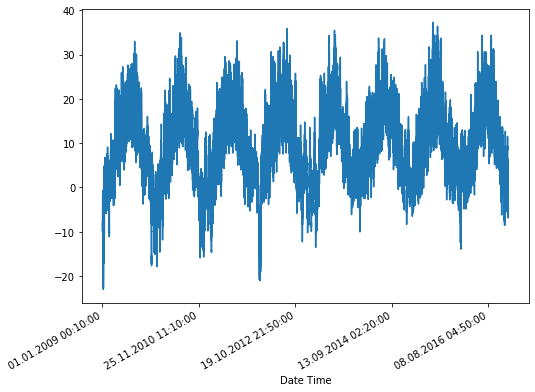

In [6]:
uni_data.plot(subplots=True);

In [7]:
uni_data = uni_data.values

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std


univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

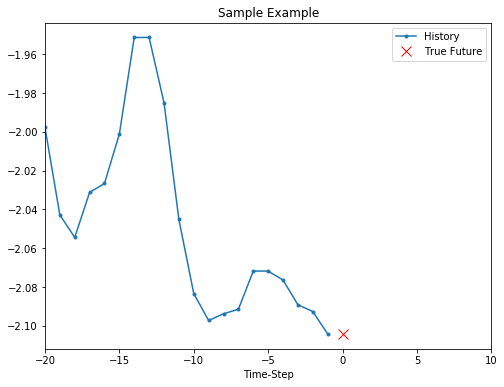

In [8]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example');

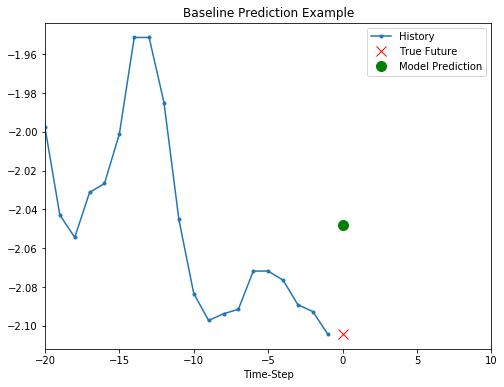

In [9]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example');

# Multivariate forecast with lstm

In [10]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


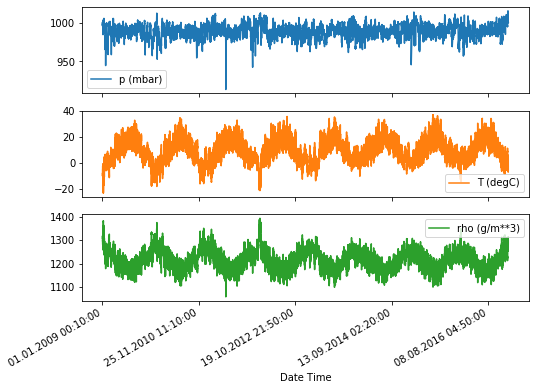

In [11]:
features.plot(subplots=True);

In [12]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset - data_mean)/data_std

# Single step model
* multivariate features to predict next time step

In [13]:
# data for the last 5 days is used (720 observations) predict 12h ahead
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)



In [14]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [15]:
%%time
trained_model, single_step_history = single_step_model(x_train_single, 
                                                       y_train_single,
                                                       x_val_single, 
                                                       y_val_single,
                                                       epochs=2)


Train for 200 steps, validate for 50 steps
Epoch 1/2
200/200 [==============================] - ETA: 11:53 - loss: 1.13 - ETA: 1:57 - loss: 0.9627 - ETA: 1:03 - loss: 0.795 - ETA: 43s - loss: 0.663 - ETA: 32s - loss: 0.59 - ETA: 25s - loss: 0.55 - ETA: 21s - loss: 0.52 - ETA: 18s - loss: 0.50 - ETA: 15s - loss: 0.48 - ETA: 13s - loss: 0.46 - ETA: 11s - loss: 0.45 - ETA: 10s - loss: 0.44 - ETA: 9s - loss: 0.4334 - ETA: 8s - loss: 0.424 - ETA: 7s - loss: 0.415 - ETA: 6s - loss: 0.406 - ETA: 6s - loss: 0.398 - ETA: 5s - loss: 0.389 - ETA: 5s - loss: 0.384 - ETA: 4s - loss: 0.376 - ETA: 4s - loss: 0.371 - ETA: 3s - loss: 0.367 - ETA: 3s - loss: 0.363 - ETA: 3s - loss: 0.360 - ETA: 2s - loss: 0.357 - ETA: 2s - loss: 0.353 - ETA: 2s - loss: 0.349 - ETA: 1s - loss: 0.345 - ETA: 1s - loss: 0.341 - ETA: 1s - loss: 0.338 - ETA: 1s - loss: 0.336 - ETA: 1s - loss: 0.334 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.328 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.325 - 6s 32ms

# Plot first 3 predictions
Use validation data for predictions

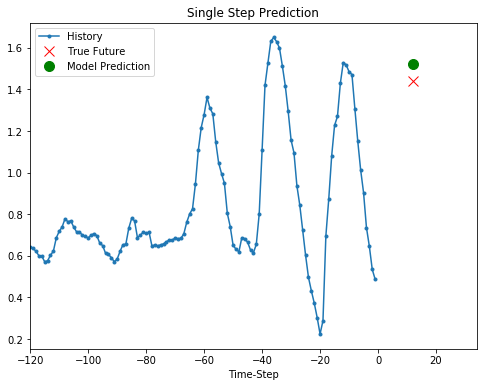

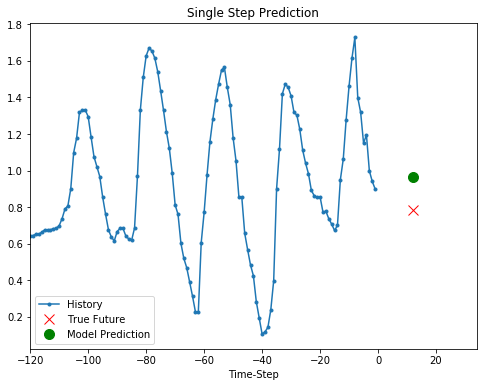

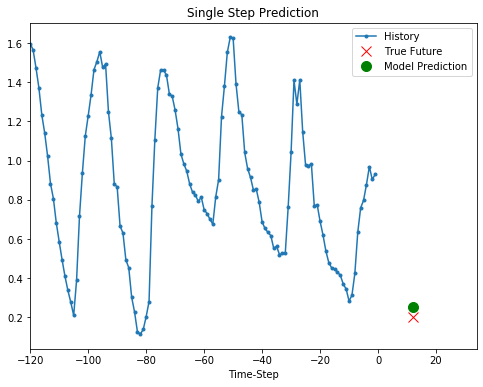

In [16]:

train_data_single, val_data_single = train_val_tf(x_train_single, y_train_single, x_val_single, y_val_single)
plot_preds(trained_model, val_data_single)



In [17]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

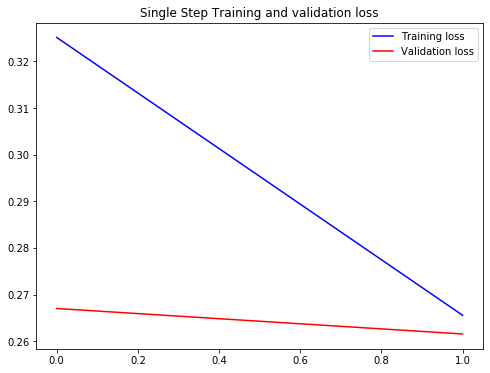

In [18]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

# Hyperparam search
### Hyperband
* Same data as in single step training above

In [19]:
%%time
from kerastuner.tuners import RandomSearch, Hyperband

hypermodel = TimeSeriesLSTM(num_outputs=1)
    
tuner = Hyperband(
    hypermodel,
    objective='mae',
    #max_trials=40,
    directory='my_dir',
    project_name='helloworld_hyperband', 
    max_epochs=2
)
tuner.search(x_train_single, y_train_single, epochs=2, validation_data=(x_val_single, y_val_single))

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 32256/299280 [==>...........................] - ETA: 4:18:30 - loss: 0.6486 - mae: 0.64 - ETA: 44:33 - loss: 1.1743 - mae: 1.1743 - ETA: 25:07 - loss: 1.1188 - mae: 1.11 - ETA: 17:50 - loss: 0.9737 - mae: 0.97 - ETA: 14:01 - loss: 0.8551 - mae: 0.85 - ETA: 11:40 - loss: 0.8167 - mae: 0.81 - ETA: 10:04 - loss: 0.8052 - mae: 0.80 - ETA: 8:54 - loss: 0.7924 - mae: 0.7924 - ETA: 8:00 - loss: 0.7759 - mae: 0.775 - ETA: 7:10 - loss: 0.7528 - mae: 0.752 - ETA: 6:31 - loss: 0.7286 - mae: 0.728 - ETA: 6:06 - loss: 0.7050 - mae: 0.705 - ETA: 5:45 - loss: 0.7082 - mae: 0.708 - ETA: 5:27 - loss: 0.7212 - mae: 0.721 - ETA: 5:11 - loss: 0.7127 - mae: 0.712 - ETA: 4:57 - loss: 0.6948 - mae: 0.694 - ETA: 4:45 - loss: 0.6831 - mae: 0.683 - ETA: 4:34 - loss: 0.6733 - mae: 0.673 - ETA: 4:25 - loss: 0.6583 - mae: 0.658 - ETA: 4:16 - loss: 0.6480 - mae: 0.648 - ETA: 4:09 - loss: 0.6408 - mae: 0.640 - ETA: 4:02 - loss: 0.6301 - mae: 0.630 - ETA: 3:55 - loss: 0.6250 - mae: 0.625 - ETA: 3:50 - loss: 0.6237 -

 64896/299280 [=====>........................] - ETA: 1:44 - loss: 0.3959 - mae: 0.395 - ETA: 1:44 - loss: 0.3958 - mae: 0.395 - ETA: 1:44 - loss: 0.3958 - mae: 0.395 - ETA: 1:43 - loss: 0.3955 - mae: 0.395 - ETA: 1:43 - loss: 0.3954 - mae: 0.395 - ETA: 1:43 - loss: 0.3952 - mae: 0.395 - ETA: 1:43 - loss: 0.3957 - mae: 0.395 - ETA: 1:43 - loss: 0.3951 - mae: 0.395 - ETA: 1:43 - loss: 0.3951 - mae: 0.395 - ETA: 1:43 - loss: 0.3948 - mae: 0.394 - ETA: 1:43 - loss: 0.3945 - mae: 0.394 - ETA: 1:43 - loss: 0.3940 - mae: 0.394 - ETA: 1:42 - loss: 0.3936 - mae: 0.393 - ETA: 1:42 - loss: 0.3931 - mae: 0.393 - ETA: 1:42 - loss: 0.3927 - mae: 0.392 - ETA: 1:42 - loss: 0.3924 - mae: 0.392 - ETA: 1:42 - loss: 0.3920 - mae: 0.392 - ETA: 1:42 - loss: 0.3917 - mae: 0.391 - ETA: 1:42 - loss: 0.3911 - mae: 0.391 - ETA: 1:41 - loss: 0.3907 - mae: 0.390 - ETA: 1:41 - loss: 0.3903 - mae: 0.390 - ETA: 1:41 - loss: 0.3897 - mae: 0.389 - ETA: 1:41 - loss: 0.3891 - mae: 0.389 - ETA: 1:41 - loss: 0.3886 - mae:

 97472/299280 [========>.....................] - ETA: 1:25 - loss: 0.3362 - mae: 0.336 - ETA: 1:25 - loss: 0.3360 - mae: 0.336 - ETA: 1:25 - loss: 0.3359 - mae: 0.335 - ETA: 1:25 - loss: 0.3357 - mae: 0.335 - ETA: 1:25 - loss: 0.3356 - mae: 0.335 - ETA: 1:25 - loss: 0.3354 - mae: 0.335 - ETA: 1:25 - loss: 0.3352 - mae: 0.335 - ETA: 1:25 - loss: 0.3350 - mae: 0.335 - ETA: 1:25 - loss: 0.3348 - mae: 0.334 - ETA: 1:24 - loss: 0.3346 - mae: 0.334 - ETA: 1:24 - loss: 0.3344 - mae: 0.334 - ETA: 1:24 - loss: 0.3343 - mae: 0.334 - ETA: 1:24 - loss: 0.3340 - mae: 0.334 - ETA: 1:24 - loss: 0.3338 - mae: 0.333 - ETA: 1:24 - loss: 0.3337 - mae: 0.333 - ETA: 1:24 - loss: 0.3336 - mae: 0.333 - ETA: 1:24 - loss: 0.3334 - mae: 0.333 - ETA: 1:24 - loss: 0.3333 - mae: 0.333 - ETA: 1:24 - loss: 0.3331 - mae: 0.333 - ETA: 1:24 - loss: 0.3329 - mae: 0.332 - ETA: 1:24 - loss: 0.3327 - mae: 0.332 - ETA: 1:24 - loss: 0.3326 - mae: 0.332 - ETA: 1:23 - loss: 0.3325 - mae: 0.332 - ETA: 1:23 - loss: 0.3323 - mae:

130112/299280 [============>.................] - ETA: 1:12 - loss: 0.3104 - mae: 0.310 - ETA: 1:12 - loss: 0.3108 - mae: 0.310 - ETA: 1:12 - loss: 0.3111 - mae: 0.311 - ETA: 1:12 - loss: 0.3113 - mae: 0.311 - ETA: 1:11 - loss: 0.3114 - mae: 0.311 - ETA: 1:11 - loss: 0.3117 - mae: 0.311 - ETA: 1:11 - loss: 0.3118 - mae: 0.311 - ETA: 1:11 - loss: 0.3118 - mae: 0.311 - ETA: 1:11 - loss: 0.3120 - mae: 0.312 - ETA: 1:11 - loss: 0.3125 - mae: 0.312 - ETA: 1:11 - loss: 0.3125 - mae: 0.312 - ETA: 1:11 - loss: 0.3127 - mae: 0.312 - ETA: 1:11 - loss: 0.3128 - mae: 0.312 - ETA: 1:11 - loss: 0.3132 - mae: 0.313 - ETA: 1:11 - loss: 0.3134 - mae: 0.313 - ETA: 1:11 - loss: 0.3134 - mae: 0.313 - ETA: 1:11 - loss: 0.3134 - mae: 0.313 - ETA: 1:11 - loss: 0.3134 - mae: 0.313 - ETA: 1:11 - loss: 0.3134 - mae: 0.313 - ETA: 1:11 - loss: 0.3133 - mae: 0.313 - ETA: 1:11 - loss: 0.3139 - mae: 0.313 - ETA: 1:10 - loss: 0.3141 - mae: 0.314 - ETA: 1:10 - loss: 0.3143 - mae: 0.314 - ETA: 1:10 - loss: 0.3148 - mae:

164512/299280 [===============>..............] - ETA: 1:00 - loss: 0.3057 - mae: 0.305 - ETA: 1:00 - loss: 0.3057 - mae: 0.305 - ETA: 1:00 - loss: 0.3056 - mae: 0.305 - ETA: 59s - loss: 0.3055 - mae: 0.305 - ETA: 59s - loss: 0.3055 - mae: 0.30 - ETA: 59s - loss: 0.3054 - mae: 0.30 - ETA: 59s - loss: 0.3053 - mae: 0.30 - ETA: 59s - loss: 0.3052 - mae: 0.30 - ETA: 59s - loss: 0.3051 - mae: 0.30 - ETA: 59s - loss: 0.3051 - mae: 0.30 - ETA: 59s - loss: 0.3050 - mae: 0.30 - ETA: 59s - loss: 0.3049 - mae: 0.30 - ETA: 59s - loss: 0.3048 - mae: 0.30 - ETA: 59s - loss: 0.3048 - mae: 0.30 - ETA: 59s - loss: 0.3047 - mae: 0.30 - ETA: 59s - loss: 0.3046 - mae: 0.30 - ETA: 59s - loss: 0.3046 - mae: 0.30 - ETA: 59s - loss: 0.3045 - mae: 0.30 - ETA: 59s - loss: 0.3045 - mae: 0.30 - ETA: 59s - loss: 0.3044 - mae: 0.30 - ETA: 58s - loss: 0.3044 - mae: 0.30 - ETA: 58s - loss: 0.3043 - mae: 0.30 - ETA: 58s - loss: 0.3043 - mae: 0.30 - ETA: 58s - loss: 0.3043 - mae: 0.30 - ETA: 58s - loss: 0.3042 - mae: 0

198912/299280 [==================>...........] - ETA: 47s - loss: 0.2937 - mae: 0.29 - ETA: 47s - loss: 0.2937 - mae: 0.29 - ETA: 47s - loss: 0.2937 - mae: 0.29 - ETA: 47s - loss: 0.2936 - mae: 0.29 - ETA: 47s - loss: 0.2936 - mae: 0.29 - ETA: 47s - loss: 0.2935 - mae: 0.29 - ETA: 47s - loss: 0.2935 - mae: 0.29 - ETA: 47s - loss: 0.2935 - mae: 0.29 - ETA: 47s - loss: 0.2934 - mae: 0.29 - ETA: 47s - loss: 0.2934 - mae: 0.29 - ETA: 47s - loss: 0.2934 - mae: 0.29 - ETA: 47s - loss: 0.2933 - mae: 0.29 - ETA: 46s - loss: 0.2933 - mae: 0.29 - ETA: 46s - loss: 0.2932 - mae: 0.29 - ETA: 46s - loss: 0.2932 - mae: 0.29 - ETA: 46s - loss: 0.2932 - mae: 0.29 - ETA: 46s - loss: 0.2931 - mae: 0.29 - ETA: 46s - loss: 0.2931 - mae: 0.29 - ETA: 46s - loss: 0.2930 - mae: 0.29 - ETA: 46s - loss: 0.2930 - mae: 0.29 - ETA: 46s - loss: 0.2930 - mae: 0.29 - ETA: 46s - loss: 0.2929 - mae: 0.29 - ETA: 46s - loss: 0.2929 - mae: 0.29 - ETA: 46s - loss: 0.2928 - mae: 0.29 - ETA: 46s - loss: 0.2928 - mae: 0.29 - E

233280/299280 [======================>.......] - ETA: 35s - loss: 0.2859 - mae: 0.28 - ETA: 35s - loss: 0.2859 - mae: 0.28 - ETA: 35s - loss: 0.2859 - mae: 0.28 - ETA: 35s - loss: 0.2859 - mae: 0.28 - ETA: 35s - loss: 0.2858 - mae: 0.28 - ETA: 34s - loss: 0.2858 - mae: 0.28 - ETA: 34s - loss: 0.2858 - mae: 0.28 - ETA: 34s - loss: 0.2857 - mae: 0.28 - ETA: 34s - loss: 0.2857 - mae: 0.28 - ETA: 34s - loss: 0.2857 - mae: 0.28 - ETA: 34s - loss: 0.2857 - mae: 0.28 - ETA: 34s - loss: 0.2857 - mae: 0.28 - ETA: 34s - loss: 0.2857 - mae: 0.28 - ETA: 34s - loss: 0.2856 - mae: 0.28 - ETA: 34s - loss: 0.2856 - mae: 0.28 - ETA: 34s - loss: 0.2856 - mae: 0.28 - ETA: 34s - loss: 0.2855 - mae: 0.28 - ETA: 34s - loss: 0.2855 - mae: 0.28 - ETA: 34s - loss: 0.2855 - mae: 0.28 - ETA: 34s - loss: 0.2855 - mae: 0.28 - ETA: 34s - loss: 0.2855 - mae: 0.28 - ETA: 34s - loss: 0.2855 - mae: 0.28 - ETA: 34s - loss: 0.2855 - mae: 0.28 - ETA: 33s - loss: 0.2855 - mae: 0.28 - ETA: 33s - loss: 0.2855 - mae: 0.28 - E

267680/299280 [=========================>....] - ETA: 23s - loss: 0.2802 - mae: 0.28 - ETA: 23s - loss: 0.2802 - mae: 0.28 - ETA: 22s - loss: 0.2802 - mae: 0.28 - ETA: 22s - loss: 0.2801 - mae: 0.28 - ETA: 22s - loss: 0.2801 - mae: 0.28 - ETA: 22s - loss: 0.2801 - mae: 0.28 - ETA: 22s - loss: 0.2800 - mae: 0.28 - ETA: 22s - loss: 0.2800 - mae: 0.28 - ETA: 22s - loss: 0.2800 - mae: 0.28 - ETA: 22s - loss: 0.2800 - mae: 0.28 - ETA: 22s - loss: 0.2799 - mae: 0.27 - ETA: 22s - loss: 0.2799 - mae: 0.27 - ETA: 22s - loss: 0.2799 - mae: 0.27 - ETA: 22s - loss: 0.2799 - mae: 0.27 - ETA: 22s - loss: 0.2799 - mae: 0.27 - ETA: 22s - loss: 0.2798 - mae: 0.27 - ETA: 22s - loss: 0.2798 - mae: 0.27 - ETA: 22s - loss: 0.2798 - mae: 0.27 - ETA: 22s - loss: 0.2797 - mae: 0.27 - ETA: 22s - loss: 0.2797 - mae: 0.27 - ETA: 21s - loss: 0.2797 - mae: 0.27 - ETA: 21s - loss: 0.2796 - mae: 0.27 - ETA: 21s - loss: 0.2796 - mae: 0.27 - ETA: 21s - loss: 0.2796 - mae: 0.27 - ETA: 21s - loss: 0.2795 - mae: 0.27 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.2750 - mae: 0.27 - ETA: 10s - loss: 0.2750 - mae: 0.27 - ETA: 10s - loss: 0.2749 - mae: 0.27 - ETA: 10s - loss: 0.2749 - mae: 0.27 - ETA: 10s - loss: 0.2749 - mae: 0.27 - ETA: 10s - loss: 0.2749 - mae: 0.27 - ETA: 10s - loss: 0.2748 - mae: 0.27 - ETA: 10s - loss: 0.2748 - mae: 0.27 - ETA: 10s - loss: 0.2748 - mae: 0.27 - ETA: 10s - loss: 0.2748 - mae: 0.27 - ETA: 10s - loss: 0.2748 - mae: 0.27 - ETA: 10s - loss: 0.2748 - mae: 0.27 - ETA: 10s - loss: 0.2747 - mae: 0.27 - ETA: 10s - loss: 0.2747 - mae: 0.27 - ETA: 10s - loss: 0.2747 - mae: 0.27 - ETA: 10s - loss: 0.2746 - mae: 0.27 - ETA: 10s - loss: 0.2746 - mae: 0.27 - ETA: 10s - loss: 0.2746 - mae: 0.27 - ETA: 9s - loss: 0.2746 - mae: 0.2746 - ETA: 9s - loss: 0.2746 - mae: 0.274 - ETA: 9s - loss: 0.2745 - mae: 0.274 - ETA: 9s - loss: 0.2745 - mae: 0.274 - ETA: 9s - loss: 0.2745 - mae: 0.274 - ETA: 9s - loss: 0.2745 - mae: 0.274 - ETA: 9s - loss: 0.2745 - mae: 0.274 - 

 32512/299280 [==>...........................] - ETA: 2:01 - loss: 0.3289 - mae: 0.328 - ETA: 1:47 - loss: 0.3304 - mae: 0.330 - ETA: 1:47 - loss: 0.2951 - mae: 0.295 - ETA: 1:46 - loss: 0.2798 - mae: 0.279 - ETA: 1:45 - loss: 0.2882 - mae: 0.288 - ETA: 1:45 - loss: 0.2904 - mae: 0.290 - ETA: 1:44 - loss: 0.2931 - mae: 0.293 - ETA: 1:44 - loss: 0.2950 - mae: 0.295 - ETA: 1:44 - loss: 0.2941 - mae: 0.294 - ETA: 1:43 - loss: 0.2959 - mae: 0.295 - ETA: 1:43 - loss: 0.2995 - mae: 0.299 - ETA: 1:43 - loss: 0.2991 - mae: 0.299 - ETA: 1:43 - loss: 0.3017 - mae: 0.301 - ETA: 1:43 - loss: 0.3020 - mae: 0.302 - ETA: 1:42 - loss: 0.3028 - mae: 0.302 - ETA: 1:42 - loss: 0.3060 - mae: 0.306 - ETA: 1:42 - loss: 0.3058 - mae: 0.305 - ETA: 1:41 - loss: 0.3066 - mae: 0.306 - ETA: 1:41 - loss: 0.3060 - mae: 0.306 - ETA: 1:41 - loss: 0.3072 - mae: 0.307 - ETA: 1:41 - loss: 0.3104 - mae: 0.310 - ETA: 1:40 - loss: 0.3124 - mae: 0.312 - ETA: 1:41 - loss: 0.3132 - mae: 0.313 - ETA: 1:41 - loss: 0.3132 - mae:

 65088/299280 [=====>........................] - ETA: 1:30 - loss: 0.2860 - mae: 0.286 - ETA: 1:30 - loss: 0.2857 - mae: 0.285 - ETA: 1:30 - loss: 0.2855 - mae: 0.285 - ETA: 1:30 - loss: 0.2854 - mae: 0.285 - ETA: 1:30 - loss: 0.2851 - mae: 0.285 - ETA: 1:30 - loss: 0.2847 - mae: 0.284 - ETA: 1:30 - loss: 0.2846 - mae: 0.284 - ETA: 1:30 - loss: 0.2844 - mae: 0.284 - ETA: 1:30 - loss: 0.2841 - mae: 0.284 - ETA: 1:30 - loss: 0.2839 - mae: 0.283 - ETA: 1:29 - loss: 0.2838 - mae: 0.283 - ETA: 1:29 - loss: 0.2837 - mae: 0.283 - ETA: 1:29 - loss: 0.2835 - mae: 0.283 - ETA: 1:29 - loss: 0.2834 - mae: 0.283 - ETA: 1:29 - loss: 0.2831 - mae: 0.283 - ETA: 1:29 - loss: 0.2830 - mae: 0.283 - ETA: 1:29 - loss: 0.2828 - mae: 0.282 - ETA: 1:29 - loss: 0.2826 - mae: 0.282 - ETA: 1:29 - loss: 0.2825 - mae: 0.282 - ETA: 1:29 - loss: 0.2821 - mae: 0.282 - ETA: 1:29 - loss: 0.2819 - mae: 0.281 - ETA: 1:29 - loss: 0.2817 - mae: 0.281 - ETA: 1:29 - loss: 0.2815 - mae: 0.281 - ETA: 1:29 - loss: 0.2814 - mae:

 97184/299280 [========>.....................] - ETA: 1:19 - loss: 0.2608 - mae: 0.260 - ETA: 1:19 - loss: 0.2607 - mae: 0.260 - ETA: 1:19 - loss: 0.2606 - mae: 0.260 - ETA: 1:19 - loss: 0.2605 - mae: 0.260 - ETA: 1:19 - loss: 0.2605 - mae: 0.260 - ETA: 1:19 - loss: 0.2603 - mae: 0.260 - ETA: 1:19 - loss: 0.2602 - mae: 0.260 - ETA: 1:19 - loss: 0.2602 - mae: 0.260 - ETA: 1:19 - loss: 0.2601 - mae: 0.260 - ETA: 1:19 - loss: 0.2600 - mae: 0.260 - ETA: 1:19 - loss: 0.2600 - mae: 0.260 - ETA: 1:19 - loss: 0.2599 - mae: 0.259 - ETA: 1:19 - loss: 0.2599 - mae: 0.259 - ETA: 1:19 - loss: 0.2598 - mae: 0.259 - ETA: 1:19 - loss: 0.2597 - mae: 0.259 - ETA: 1:19 - loss: 0.2597 - mae: 0.259 - ETA: 1:19 - loss: 0.2595 - mae: 0.259 - ETA: 1:19 - loss: 0.2595 - mae: 0.259 - ETA: 1:19 - loss: 0.2594 - mae: 0.259 - ETA: 1:19 - loss: 0.2594 - mae: 0.259 - ETA: 1:18 - loss: 0.2594 - mae: 0.259 - ETA: 1:18 - loss: 0.2594 - mae: 0.259 - ETA: 1:18 - loss: 0.2592 - mae: 0.259 - ETA: 1:18 - loss: 0.2592 - mae:

130144/299280 [============>.................] - ETA: 1:09 - loss: 0.2509 - mae: 0.250 - ETA: 1:09 - loss: 0.2508 - mae: 0.250 - ETA: 1:09 - loss: 0.2508 - mae: 0.250 - ETA: 1:09 - loss: 0.2507 - mae: 0.250 - ETA: 1:09 - loss: 0.2506 - mae: 0.250 - ETA: 1:09 - loss: 0.2505 - mae: 0.250 - ETA: 1:09 - loss: 0.2505 - mae: 0.250 - ETA: 1:09 - loss: 0.2504 - mae: 0.250 - ETA: 1:09 - loss: 0.2504 - mae: 0.250 - ETA: 1:09 - loss: 0.2504 - mae: 0.250 - ETA: 1:09 - loss: 0.2503 - mae: 0.250 - ETA: 1:09 - loss: 0.2503 - mae: 0.250 - ETA: 1:09 - loss: 0.2502 - mae: 0.250 - ETA: 1:08 - loss: 0.2502 - mae: 0.250 - ETA: 1:08 - loss: 0.2501 - mae: 0.250 - ETA: 1:08 - loss: 0.2501 - mae: 0.250 - ETA: 1:08 - loss: 0.2500 - mae: 0.250 - ETA: 1:08 - loss: 0.2500 - mae: 0.250 - ETA: 1:08 - loss: 0.2500 - mae: 0.250 - ETA: 1:08 - loss: 0.2499 - mae: 0.249 - ETA: 1:08 - loss: 0.2499 - mae: 0.249 - ETA: 1:08 - loss: 0.2499 - mae: 0.249 - ETA: 1:08 - loss: 0.2499 - mae: 0.249 - ETA: 1:08 - loss: 0.2499 - mae:

164512/299280 [===============>..............] - ETA: 58s - loss: 0.2449 - mae: 0.24 - ETA: 58s - loss: 0.2448 - mae: 0.24 - ETA: 58s - loss: 0.2448 - mae: 0.24 - ETA: 58s - loss: 0.2448 - mae: 0.24 - ETA: 58s - loss: 0.2448 - mae: 0.24 - ETA: 57s - loss: 0.2448 - mae: 0.24 - ETA: 57s - loss: 0.2448 - mae: 0.24 - ETA: 57s - loss: 0.2447 - mae: 0.24 - ETA: 57s - loss: 0.2447 - mae: 0.24 - ETA: 57s - loss: 0.2446 - mae: 0.24 - ETA: 57s - loss: 0.2446 - mae: 0.24 - ETA: 57s - loss: 0.2446 - mae: 0.24 - ETA: 57s - loss: 0.2446 - mae: 0.24 - ETA: 57s - loss: 0.2445 - mae: 0.24 - ETA: 57s - loss: 0.2445 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - E

198912/299280 [==================>...........] - ETA: 46s - loss: 0.2405 - mae: 0.24 - ETA: 46s - loss: 0.2405 - mae: 0.24 - ETA: 46s - loss: 0.2405 - mae: 0.24 - ETA: 46s - loss: 0.2404 - mae: 0.24 - ETA: 46s - loss: 0.2404 - mae: 0.24 - ETA: 46s - loss: 0.2404 - mae: 0.24 - ETA: 46s - loss: 0.2404 - mae: 0.24 - ETA: 46s - loss: 0.2404 - mae: 0.24 - ETA: 45s - loss: 0.2404 - mae: 0.24 - ETA: 45s - loss: 0.2403 - mae: 0.24 - ETA: 45s - loss: 0.2403 - mae: 0.24 - ETA: 45s - loss: 0.2403 - mae: 0.24 - ETA: 45s - loss: 0.2403 - mae: 0.24 - ETA: 45s - loss: 0.2403 - mae: 0.24 - ETA: 45s - loss: 0.2403 - mae: 0.24 - ETA: 45s - loss: 0.2403 - mae: 0.24 - ETA: 45s - loss: 0.2403 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2402 - mae: 0.24 - ETA: 45s - loss: 0.2401 - mae: 0.24 - ETA: 45s - loss: 0.2401 - mae: 0.24 - ETA: 45s - loss: 0.2400 - mae: 0.24 - E

232256/299280 [======================>.......] - ETA: 34s - loss: 0.2385 - mae: 0.23 - ETA: 34s - loss: 0.2385 - mae: 0.23 - ETA: 34s - loss: 0.2385 - mae: 0.23 - ETA: 34s - loss: 0.2385 - mae: 0.23 - ETA: 34s - loss: 0.2385 - mae: 0.23 - ETA: 34s - loss: 0.2385 - mae: 0.23 - ETA: 34s - loss: 0.2384 - mae: 0.23 - ETA: 34s - loss: 0.2384 - mae: 0.23 - ETA: 34s - loss: 0.2384 - mae: 0.23 - ETA: 33s - loss: 0.2384 - mae: 0.23 - ETA: 33s - loss: 0.2384 - mae: 0.23 - ETA: 33s - loss: 0.2384 - mae: 0.23 - ETA: 33s - loss: 0.2384 - mae: 0.23 - ETA: 33s - loss: 0.2384 - mae: 0.23 - ETA: 33s - loss: 0.2384 - mae: 0.23 - ETA: 33s - loss: 0.2384 - mae: 0.23 - ETA: 33s - loss: 0.2383 - mae: 0.23 - ETA: 33s - loss: 0.2383 - mae: 0.23 - ETA: 33s - loss: 0.2383 - mae: 0.23 - ETA: 33s - loss: 0.2383 - mae: 0.23 - ETA: 33s - loss: 0.2383 - mae: 0.23 - ETA: 33s - loss: 0.2383 - mae: 0.23 - ETA: 33s - loss: 0.2383 - mae: 0.23 - ETA: 33s - loss: 0.2383 - mae: 0.23 - ETA: 33s - loss: 0.2382 - mae: 0.23 - E

265952/299280 [=========================>....] - ETA: 23s - loss: 0.2390 - mae: 0.23 - ETA: 23s - loss: 0.2390 - mae: 0.23 - ETA: 23s - loss: 0.2390 - mae: 0.23 - ETA: 22s - loss: 0.2390 - mae: 0.23 - ETA: 22s - loss: 0.2390 - mae: 0.23 - ETA: 22s - loss: 0.2390 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2390 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 22s - loss: 0.2389 - mae: 0.23 - ETA: 21s - loss: 0.2389 - mae: 0.23 - ETA: 21s - loss: 0.2389 - mae: 0.23 - ETA: 21s - loss: 0.2389 - mae: 0.23 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2371 - mae: 0.23 - ETA: 11s - loss: 0.2371 - mae: 0.23 - ETA: 11s - loss: 0.2371 - mae: 0.23 - ETA: 11s - loss: 0.2371 - mae: 0.23 - ETA: 11s - loss: 0.2371 - mae: 0.23 - ETA: 11s - loss: 0.2371 - mae: 0.23 - ETA: 11s - loss: 0.2370 - mae: 0.23 - ETA: 11s - loss: 0.2370 - mae: 0.23 - ETA: 11s - loss: 0.2370 - mae: 0.23 - ETA: 11s - loss: 0.2370 - mae: 0.23 - ETA: 11s - loss: 0.2370 - mae: 0.23 - ETA: 10s - loss: 0.2370 - mae: 0.23 - ETA: 10s - loss: 0.2370 - mae: 0.23 - ETA: 10s - loss: 0.2369 - mae: 0.23 - ETA: 10s - loss: 0.2369 - mae: 0.23 - ETA: 10s - loss: 0.2369 - mae: 0.23 - ETA: 10s - loss: 0.2369 - mae: 0.23 - ETA: 10s - loss: 0.2369 - mae: 0.23 - ETA: 10s - loss: 0.2369 - mae: 0.23 - ETA: 10s - loss: 0.2369 - mae: 0.23 - ETA: 10s - loss: 0.2369 - mae: 0.23 - ETA: 10s - loss: 0.2369 - mae: 0.23 - ETA: 10s - loss: 0.2368 - mae: 0.23 - ETA: 10s - loss: 0.2368 - mae: 0.23 - ETA: 10s - loss: 0.2368 - mae: 0.23 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 31776/299280 [==>...........................] - ETA: 4:39:06 - loss: 0.6660 - mae: 0.66 - ETA: 48:02 - loss: 0.4488 - mae: 0.4488 - ETA: 27:02 - loss: 0.4159 - mae: 0.41 - ETA: 19:08 - loss: 0.3891 - mae: 0.38 - ETA: 15:00 - loss: 0.3791 - mae: 0.37 - ETA: 12:28 - loss: 0.3703 - mae: 0.37 - ETA: 10:44 - loss: 0.3587 - mae: 0.35 - ETA: 9:30 - loss: 0.3576 - mae: 0.3576 - ETA: 8:44 - loss: 0.3540 - mae: 0.354 - ETA: 8:07 - loss: 0.3506 - mae: 0.350 - ETA: 7:36 - loss: 0.3460 - mae: 0.346 - ETA: 7:03 - loss: 0.3429 - mae: 0.342 - ETA: 6:35 - loss: 0.3410 - mae: 0.341 - ETA: 6:12 - loss: 0.3399 - mae: 0.339 - ETA: 5:52 - loss: 0.3366 - mae: 0.336 - ETA: 5:36 - loss: 0.3368 - mae: 0.336 - ETA: 5:21 - loss: 0.3373 - mae: 0.337 - ETA: 5:07 - loss: 0.3337 - mae: 0.333 - ETA: 4:56 - loss: 0.3311 - mae: 0.331 - ETA: 4:46 - loss: 0.3294 - mae: 0.329 - ETA: 4:36 - loss: 0.3294 - mae: 0.329 - ETA: 4:28 - loss: 0.3283 - mae: 0.328 - ETA: 4:20 - loss: 0.3254 - mae: 0.325 - ETA: 4:13 - loss: 0.3236 -

 63232/299280 [=====>........................] - ETA: 1:52 - loss: 0.2810 - mae: 0.281 - ETA: 1:52 - loss: 0.2810 - mae: 0.281 - ETA: 1:52 - loss: 0.2809 - mae: 0.280 - ETA: 1:52 - loss: 0.2807 - mae: 0.280 - ETA: 1:51 - loss: 0.2807 - mae: 0.280 - ETA: 1:51 - loss: 0.2807 - mae: 0.280 - ETA: 1:51 - loss: 0.2806 - mae: 0.280 - ETA: 1:51 - loss: 0.2805 - mae: 0.280 - ETA: 1:51 - loss: 0.2805 - mae: 0.280 - ETA: 1:51 - loss: 0.2806 - mae: 0.280 - ETA: 1:51 - loss: 0.2804 - mae: 0.280 - ETA: 1:51 - loss: 0.2803 - mae: 0.280 - ETA: 1:50 - loss: 0.2802 - mae: 0.280 - ETA: 1:50 - loss: 0.2801 - mae: 0.280 - ETA: 1:50 - loss: 0.2800 - mae: 0.280 - ETA: 1:50 - loss: 0.2800 - mae: 0.280 - ETA: 1:50 - loss: 0.2800 - mae: 0.280 - ETA: 1:50 - loss: 0.2800 - mae: 0.280 - ETA: 1:50 - loss: 0.2801 - mae: 0.280 - ETA: 1:50 - loss: 0.2802 - mae: 0.280 - ETA: 1:49 - loss: 0.2801 - mae: 0.280 - ETA: 1:49 - loss: 0.2800 - mae: 0.280 - ETA: 1:49 - loss: 0.2800 - mae: 0.280 - ETA: 1:49 - loss: 0.2801 - mae:

 95008/299280 [========>.....................] - ETA: 1:33 - loss: 0.2710 - mae: 0.271 - ETA: 1:33 - loss: 0.2710 - mae: 0.271 - ETA: 1:33 - loss: 0.2709 - mae: 0.270 - ETA: 1:33 - loss: 0.2709 - mae: 0.270 - ETA: 1:33 - loss: 0.2709 - mae: 0.270 - ETA: 1:33 - loss: 0.2708 - mae: 0.270 - ETA: 1:33 - loss: 0.2707 - mae: 0.270 - ETA: 1:33 - loss: 0.2708 - mae: 0.270 - ETA: 1:33 - loss: 0.2706 - mae: 0.270 - ETA: 1:33 - loss: 0.2706 - mae: 0.270 - ETA: 1:33 - loss: 0.2705 - mae: 0.270 - ETA: 1:32 - loss: 0.2705 - mae: 0.270 - ETA: 1:32 - loss: 0.2704 - mae: 0.270 - ETA: 1:32 - loss: 0.2705 - mae: 0.270 - ETA: 1:32 - loss: 0.2705 - mae: 0.270 - ETA: 1:32 - loss: 0.2705 - mae: 0.270 - ETA: 1:32 - loss: 0.2704 - mae: 0.270 - ETA: 1:32 - loss: 0.2705 - mae: 0.270 - ETA: 1:32 - loss: 0.2704 - mae: 0.270 - ETA: 1:32 - loss: 0.2703 - mae: 0.270 - ETA: 1:32 - loss: 0.2702 - mae: 0.270 - ETA: 1:32 - loss: 0.2701 - mae: 0.270 - ETA: 1:32 - loss: 0.2701 - mae: 0.270 - ETA: 1:32 - loss: 0.2700 - mae:

127520/299280 [===========>..................] - ETA: 1:18 - loss: 0.2649 - mae: 0.264 - ETA: 1:18 - loss: 0.2648 - mae: 0.264 - ETA: 1:18 - loss: 0.2648 - mae: 0.264 - ETA: 1:18 - loss: 0.2648 - mae: 0.264 - ETA: 1:18 - loss: 0.2648 - mae: 0.264 - ETA: 1:18 - loss: 0.2647 - mae: 0.264 - ETA: 1:18 - loss: 0.2647 - mae: 0.264 - ETA: 1:18 - loss: 0.2647 - mae: 0.264 - ETA: 1:18 - loss: 0.2647 - mae: 0.264 - ETA: 1:18 - loss: 0.2647 - mae: 0.264 - ETA: 1:18 - loss: 0.2646 - mae: 0.264 - ETA: 1:17 - loss: 0.2646 - mae: 0.264 - ETA: 1:17 - loss: 0.2646 - mae: 0.264 - ETA: 1:17 - loss: 0.2646 - mae: 0.264 - ETA: 1:17 - loss: 0.2645 - mae: 0.264 - ETA: 1:17 - loss: 0.2644 - mae: 0.264 - ETA: 1:17 - loss: 0.2644 - mae: 0.264 - ETA: 1:17 - loss: 0.2644 - mae: 0.264 - ETA: 1:17 - loss: 0.2644 - mae: 0.264 - ETA: 1:17 - loss: 0.2643 - mae: 0.264 - ETA: 1:17 - loss: 0.2643 - mae: 0.264 - ETA: 1:17 - loss: 0.2643 - mae: 0.264 - ETA: 1:17 - loss: 0.2643 - mae: 0.264 - ETA: 1:17 - loss: 0.2642 - mae:

160928/299280 [===============>..............] - ETA: 1:04 - loss: 0.2612 - mae: 0.261 - ETA: 1:04 - loss: 0.2612 - mae: 0.261 - ETA: 1:04 - loss: 0.2612 - mae: 0.261 - ETA: 1:04 - loss: 0.2612 - mae: 0.261 - ETA: 1:04 - loss: 0.2612 - mae: 0.261 - ETA: 1:04 - loss: 0.2612 - mae: 0.261 - ETA: 1:04 - loss: 0.2612 - mae: 0.261 - ETA: 1:04 - loss: 0.2611 - mae: 0.261 - ETA: 1:04 - loss: 0.2611 - mae: 0.261 - ETA: 1:04 - loss: 0.2611 - mae: 0.261 - ETA: 1:04 - loss: 0.2611 - mae: 0.261 - ETA: 1:04 - loss: 0.2610 - mae: 0.261 - ETA: 1:04 - loss: 0.2610 - mae: 0.261 - ETA: 1:03 - loss: 0.2610 - mae: 0.261 - ETA: 1:03 - loss: 0.2610 - mae: 0.261 - ETA: 1:03 - loss: 0.2610 - mae: 0.261 - ETA: 1:03 - loss: 0.2610 - mae: 0.261 - ETA: 1:03 - loss: 0.2610 - mae: 0.261 - ETA: 1:03 - loss: 0.2610 - mae: 0.261 - ETA: 1:03 - loss: 0.2610 - mae: 0.261 - ETA: 1:03 - loss: 0.2610 - mae: 0.261 - ETA: 1:03 - loss: 0.2609 - mae: 0.260 - ETA: 1:03 - loss: 0.2609 - mae: 0.260 - ETA: 1:03 - loss: 0.2609 - mae:

194976/299280 [==================>...........] - ETA: 51s - loss: 0.2575 - mae: 0.25 - ETA: 51s - loss: 0.2575 - mae: 0.25 - ETA: 51s - loss: 0.2575 - mae: 0.25 - ETA: 51s - loss: 0.2575 - mae: 0.25 - ETA: 51s - loss: 0.2575 - mae: 0.25 - ETA: 51s - loss: 0.2575 - mae: 0.25 - ETA: 51s - loss: 0.2575 - mae: 0.25 - ETA: 51s - loss: 0.2575 - mae: 0.25 - ETA: 51s - loss: 0.2574 - mae: 0.25 - ETA: 51s - loss: 0.2574 - mae: 0.25 - ETA: 51s - loss: 0.2574 - mae: 0.25 - ETA: 50s - loss: 0.2574 - mae: 0.25 - ETA: 50s - loss: 0.2573 - mae: 0.25 - ETA: 50s - loss: 0.2573 - mae: 0.25 - ETA: 50s - loss: 0.2573 - mae: 0.25 - ETA: 50s - loss: 0.2573 - mae: 0.25 - ETA: 50s - loss: 0.2572 - mae: 0.25 - ETA: 50s - loss: 0.2572 - mae: 0.25 - ETA: 50s - loss: 0.2572 - mae: 0.25 - ETA: 50s - loss: 0.2572 - mae: 0.25 - ETA: 50s - loss: 0.2572 - mae: 0.25 - ETA: 50s - loss: 0.2571 - mae: 0.25 - ETA: 50s - loss: 0.2571 - mae: 0.25 - ETA: 50s - loss: 0.2571 - mae: 0.25 - ETA: 50s - loss: 0.2571 - mae: 0.25 - E

229120/299280 [=====================>........] - ETA: 38s - loss: 0.2547 - mae: 0.25 - ETA: 38s - loss: 0.2546 - mae: 0.25 - ETA: 38s - loss: 0.2546 - mae: 0.25 - ETA: 38s - loss: 0.2546 - mae: 0.25 - ETA: 38s - loss: 0.2546 - mae: 0.25 - ETA: 38s - loss: 0.2546 - mae: 0.25 - ETA: 38s - loss: 0.2545 - mae: 0.25 - ETA: 38s - loss: 0.2545 - mae: 0.25 - ETA: 38s - loss: 0.2545 - mae: 0.25 - ETA: 38s - loss: 0.2545 - mae: 0.25 - ETA: 37s - loss: 0.2545 - mae: 0.25 - ETA: 37s - loss: 0.2545 - mae: 0.25 - ETA: 37s - loss: 0.2545 - mae: 0.25 - ETA: 37s - loss: 0.2545 - mae: 0.25 - ETA: 37s - loss: 0.2545 - mae: 0.25 - ETA: 37s - loss: 0.2545 - mae: 0.25 - ETA: 37s - loss: 0.2545 - mae: 0.25 - ETA: 37s - loss: 0.2544 - mae: 0.25 - ETA: 37s - loss: 0.2544 - mae: 0.25 - ETA: 37s - loss: 0.2544 - mae: 0.25 - ETA: 37s - loss: 0.2544 - mae: 0.25 - ETA: 37s - loss: 0.2544 - mae: 0.25 - ETA: 37s - loss: 0.2544 - mae: 0.25 - ETA: 37s - loss: 0.2544 - mae: 0.25 - ETA: 37s - loss: 0.2543 - mae: 0.25 - E

263168/299280 [=========================>....] - ETA: 25s - loss: 0.2518 - mae: 0.25 - ETA: 25s - loss: 0.2518 - mae: 0.25 - ETA: 25s - loss: 0.2518 - mae: 0.25 - ETA: 25s - loss: 0.2518 - mae: 0.25 - ETA: 25s - loss: 0.2518 - mae: 0.25 - ETA: 25s - loss: 0.2518 - mae: 0.25 - ETA: 25s - loss: 0.2518 - mae: 0.25 - ETA: 25s - loss: 0.2518 - mae: 0.25 - ETA: 25s - loss: 0.2518 - mae: 0.25 - ETA: 25s - loss: 0.2517 - mae: 0.25 - ETA: 25s - loss: 0.2517 - mae: 0.25 - ETA: 25s - loss: 0.2517 - mae: 0.25 - ETA: 25s - loss: 0.2517 - mae: 0.25 - ETA: 24s - loss: 0.2517 - mae: 0.25 - ETA: 24s - loss: 0.2516 - mae: 0.25 - ETA: 24s - loss: 0.2516 - mae: 0.25 - ETA: 24s - loss: 0.2516 - mae: 0.25 - ETA: 24s - loss: 0.2516 - mae: 0.25 - ETA: 24s - loss: 0.2516 - mae: 0.25 - ETA: 24s - loss: 0.2516 - mae: 0.25 - ETA: 24s - loss: 0.2516 - mae: 0.25 - ETA: 24s - loss: 0.2515 - mae: 0.25 - ETA: 24s - loss: 0.2516 - mae: 0.25 - ETA: 24s - loss: 0.2515 - mae: 0.25 - ETA: 24s - loss: 0.2515 - mae: 0.25 - E

297536/299280 [============================>.] - ETA: 13s - loss: 0.2494 - mae: 0.24 - ETA: 13s - loss: 0.2494 - mae: 0.24 - ETA: 13s - loss: 0.2494 - mae: 0.24 - ETA: 12s - loss: 0.2494 - mae: 0.24 - ETA: 12s - loss: 0.2494 - mae: 0.24 - ETA: 12s - loss: 0.2494 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2493 - mae: 0.24 - ETA: 12s - loss: 0.2492 - mae: 0.24 - ETA: 12s - loss: 0.2492 - mae: 0.24 - ETA: 12s - loss: 0.2492 - mae: 0.24 - ETA: 12s - loss: 0.2492 - mae: 0.24 - ETA: 12s - loss: 0.2492 - mae: 0.24 - ETA: 11s - loss: 0.2492 - mae: 0.24 - ETA: 11s - loss: 0.2492 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2473 - mae: 0.247 - ETA: 0s - loss: 0.2473 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - ETA: 0s - loss: 0.2472 - mae: 0.247 - 131s 437us/sample - loss: 0.2472 - mae: 0.2472 - val_loss: 0.2466 - val_mae: 0.2466
Epoch 2/2


 32160/299280 [==>...........................] - ETA: 2:10 - loss: 0.2641 - mae: 0.264 - ETA: 1:51 - loss: 0.2247 - mae: 0.224 - ETA: 1:47 - loss: 0.2301 - mae: 0.230 - ETA: 1:46 - loss: 0.2231 - mae: 0.223 - ETA: 1:46 - loss: 0.2331 - mae: 0.233 - ETA: 1:45 - loss: 0.2316 - mae: 0.231 - ETA: 1:44 - loss: 0.2316 - mae: 0.231 - ETA: 1:44 - loss: 0.2307 - mae: 0.230 - ETA: 1:43 - loss: 0.2280 - mae: 0.228 - ETA: 1:43 - loss: 0.2271 - mae: 0.227 - ETA: 1:43 - loss: 0.2287 - mae: 0.228 - ETA: 1:43 - loss: 0.2258 - mae: 0.225 - ETA: 1:43 - loss: 0.2256 - mae: 0.225 - ETA: 1:43 - loss: 0.2245 - mae: 0.224 - ETA: 1:43 - loss: 0.2234 - mae: 0.223 - ETA: 1:43 - loss: 0.2251 - mae: 0.225 - ETA: 1:43 - loss: 0.2232 - mae: 0.223 - ETA: 1:43 - loss: 0.2236 - mae: 0.223 - ETA: 1:44 - loss: 0.2230 - mae: 0.223 - ETA: 1:44 - loss: 0.2236 - mae: 0.223 - ETA: 1:45 - loss: 0.2240 - mae: 0.224 - ETA: 1:45 - loss: 0.2245 - mae: 0.224 - ETA: 1:45 - loss: 0.2238 - mae: 0.223 - ETA: 1:45 - loss: 0.2242 - mae:

 64000/299280 [=====>........................] - ETA: 1:35 - loss: 0.2258 - mae: 0.225 - ETA: 1:35 - loss: 0.2258 - mae: 0.225 - ETA: 1:35 - loss: 0.2257 - mae: 0.225 - ETA: 1:35 - loss: 0.2257 - mae: 0.225 - ETA: 1:35 - loss: 0.2256 - mae: 0.225 - ETA: 1:35 - loss: 0.2256 - mae: 0.225 - ETA: 1:35 - loss: 0.2256 - mae: 0.225 - ETA: 1:35 - loss: 0.2256 - mae: 0.225 - ETA: 1:35 - loss: 0.2255 - mae: 0.225 - ETA: 1:35 - loss: 0.2254 - mae: 0.225 - ETA: 1:35 - loss: 0.2254 - mae: 0.225 - ETA: 1:35 - loss: 0.2254 - mae: 0.225 - ETA: 1:35 - loss: 0.2254 - mae: 0.225 - ETA: 1:35 - loss: 0.2255 - mae: 0.225 - ETA: 1:35 - loss: 0.2254 - mae: 0.225 - ETA: 1:35 - loss: 0.2254 - mae: 0.225 - ETA: 1:34 - loss: 0.2254 - mae: 0.225 - ETA: 1:34 - loss: 0.2254 - mae: 0.225 - ETA: 1:34 - loss: 0.2255 - mae: 0.225 - ETA: 1:34 - loss: 0.2255 - mae: 0.225 - ETA: 1:34 - loss: 0.2254 - mae: 0.225 - ETA: 1:34 - loss: 0.2254 - mae: 0.225 - ETA: 1:34 - loss: 0.2253 - mae: 0.225 - ETA: 1:34 - loss: 0.2253 - mae:

 95808/299280 [========>.....................] - ETA: 1:24 - loss: 0.2239 - mae: 0.223 - ETA: 1:24 - loss: 0.2239 - mae: 0.223 - ETA: 1:24 - loss: 0.2239 - mae: 0.223 - ETA: 1:24 - loss: 0.2239 - mae: 0.223 - ETA: 1:24 - loss: 0.2238 - mae: 0.223 - ETA: 1:24 - loss: 0.2238 - mae: 0.223 - ETA: 1:24 - loss: 0.2239 - mae: 0.223 - ETA: 1:24 - loss: 0.2239 - mae: 0.223 - ETA: 1:24 - loss: 0.2238 - mae: 0.223 - ETA: 1:24 - loss: 0.2239 - mae: 0.223 - ETA: 1:24 - loss: 0.2238 - mae: 0.223 - ETA: 1:24 - loss: 0.2238 - mae: 0.223 - ETA: 1:23 - loss: 0.2238 - mae: 0.223 - ETA: 1:23 - loss: 0.2238 - mae: 0.223 - ETA: 1:23 - loss: 0.2238 - mae: 0.223 - ETA: 1:23 - loss: 0.2238 - mae: 0.223 - ETA: 1:23 - loss: 0.2238 - mae: 0.223 - ETA: 1:23 - loss: 0.2237 - mae: 0.223 - ETA: 1:23 - loss: 0.2238 - mae: 0.223 - ETA: 1:23 - loss: 0.2238 - mae: 0.223 - ETA: 1:23 - loss: 0.2238 - mae: 0.223 - ETA: 1:23 - loss: 0.2238 - mae: 0.223 - ETA: 1:23 - loss: 0.2237 - mae: 0.223 - ETA: 1:23 - loss: 0.2237 - mae:

128032/299280 [===========>..................] - ETA: 1:13 - loss: 0.2223 - mae: 0.222 - ETA: 1:13 - loss: 0.2223 - mae: 0.222 - ETA: 1:13 - loss: 0.2222 - mae: 0.222 - ETA: 1:13 - loss: 0.2223 - mae: 0.222 - ETA: 1:13 - loss: 0.2222 - mae: 0.222 - ETA: 1:13 - loss: 0.2222 - mae: 0.222 - ETA: 1:13 - loss: 0.2222 - mae: 0.222 - ETA: 1:12 - loss: 0.2222 - mae: 0.222 - ETA: 1:12 - loss: 0.2222 - mae: 0.222 - ETA: 1:12 - loss: 0.2222 - mae: 0.222 - ETA: 1:12 - loss: 0.2222 - mae: 0.222 - ETA: 1:12 - loss: 0.2222 - mae: 0.222 - ETA: 1:12 - loss: 0.2222 - mae: 0.222 - ETA: 1:12 - loss: 0.2221 - mae: 0.222 - ETA: 1:12 - loss: 0.2221 - mae: 0.222 - ETA: 1:12 - loss: 0.2222 - mae: 0.222 - ETA: 1:12 - loss: 0.2222 - mae: 0.222 - ETA: 1:12 - loss: 0.2222 - mae: 0.222 - ETA: 1:12 - loss: 0.2221 - mae: 0.222 - ETA: 1:12 - loss: 0.2221 - mae: 0.222 - ETA: 1:12 - loss: 0.2221 - mae: 0.222 - ETA: 1:12 - loss: 0.2221 - mae: 0.222 - ETA: 1:12 - loss: 0.2221 - mae: 0.222 - ETA: 1:12 - loss: 0.2221 - mae:

161696/299280 [===============>..............] - ETA: 1:01 - loss: 0.2206 - mae: 0.220 - ETA: 1:01 - loss: 0.2205 - mae: 0.220 - ETA: 1:01 - loss: 0.2205 - mae: 0.220 - ETA: 1:01 - loss: 0.2205 - mae: 0.220 - ETA: 1:01 - loss: 0.2205 - mae: 0.220 - ETA: 1:01 - loss: 0.2204 - mae: 0.220 - ETA: 1:01 - loss: 0.2204 - mae: 0.220 - ETA: 1:01 - loss: 0.2204 - mae: 0.220 - ETA: 1:01 - loss: 0.2204 - mae: 0.220 - ETA: 1:01 - loss: 0.2204 - mae: 0.220 - ETA: 1:01 - loss: 0.2203 - mae: 0.220 - ETA: 1:01 - loss: 0.2204 - mae: 0.220 - ETA: 1:01 - loss: 0.2204 - mae: 0.220 - ETA: 1:00 - loss: 0.2204 - mae: 0.220 - ETA: 1:00 - loss: 0.2203 - mae: 0.220 - ETA: 1:00 - loss: 0.2203 - mae: 0.220 - ETA: 1:00 - loss: 0.2203 - mae: 0.220 - ETA: 1:00 - loss: 0.2203 - mae: 0.220 - ETA: 1:00 - loss: 0.2203 - mae: 0.220 - ETA: 1:00 - loss: 0.2203 - mae: 0.220 - ETA: 1:00 - loss: 0.2204 - mae: 0.220 - ETA: 1:00 - loss: 0.2203 - mae: 0.220 - ETA: 1:00 - loss: 0.2203 - mae: 0.220 - ETA: 1:00 - loss: 0.2203 - mae:

194624/299280 [==================>...........] - ETA: 49s - loss: 0.2188 - mae: 0.21 - ETA: 49s - loss: 0.2187 - mae: 0.21 - ETA: 49s - loss: 0.2187 - mae: 0.21 - ETA: 49s - loss: 0.2187 - mae: 0.21 - ETA: 49s - loss: 0.2187 - mae: 0.21 - ETA: 49s - loss: 0.2187 - mae: 0.21 - ETA: 49s - loss: 0.2187 - mae: 0.21 - ETA: 49s - loss: 0.2187 - mae: 0.21 - ETA: 49s - loss: 0.2187 - mae: 0.21 - ETA: 49s - loss: 0.2186 - mae: 0.21 - ETA: 49s - loss: 0.2186 - mae: 0.21 - ETA: 49s - loss: 0.2186 - mae: 0.21 - ETA: 49s - loss: 0.2186 - mae: 0.21 - ETA: 49s - loss: 0.2186 - mae: 0.21 - ETA: 49s - loss: 0.2186 - mae: 0.21 - ETA: 48s - loss: 0.2186 - mae: 0.21 - ETA: 48s - loss: 0.2186 - mae: 0.21 - ETA: 48s - loss: 0.2186 - mae: 0.21 - ETA: 48s - loss: 0.2186 - mae: 0.21 - ETA: 48s - loss: 0.2186 - mae: 0.21 - ETA: 48s - loss: 0.2186 - mae: 0.21 - ETA: 48s - loss: 0.2185 - mae: 0.21 - ETA: 48s - loss: 0.2185 - mae: 0.21 - ETA: 48s - loss: 0.2185 - mae: 0.21 - ETA: 48s - loss: 0.2185 - mae: 0.21 - E

228960/299280 [=====================>........] - ETA: 37s - loss: 0.2169 - mae: 0.21 - ETA: 37s - loss: 0.2169 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 37s - loss: 0.2168 - mae: 0.21 - ETA: 36s - loss: 0.2167 - mae: 0.21 - ETA: 36s - loss: 0.2167 - mae: 0.21 - ETA: 36s - loss: 0.2167 - mae: 0.21 - ETA: 36s - loss: 0.2167 - mae: 0.21 - ETA: 36s - loss: 0.2167 - mae: 0.21 - ETA: 36s - loss: 0.2167 - mae: 0.21 - ETA: 36s - loss: 0.2167 - mae: 0.21 - ETA: 36s - loss: 0.2167 - mae: 0.21 - ETA: 36s - loss: 0.2167 - mae: 0.21 - E

263328/299280 [=========================>....] - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2151 - mae: 0.21 - ETA: 25s - loss: 0.2150 - mae: 0.21 - ETA: 25s - loss: 0.2150 - mae: 0.21 - ETA: 25s - loss: 0.2150 - mae: 0.21 - ETA: 25s - loss: 0.2150 - mae: 0.21 - ETA: 24s - loss: 0.2150 - mae: 0.21 - ETA: 24s - loss: 0.2150 - mae: 0.21 - ETA: 24s - loss: 0.2150 - mae: 0.21 - ETA: 24s - loss: 0.2150 - mae: 0.21 - ETA: 24s - loss: 0.2150 - mae: 0.21 - ETA: 24s - loss: 0.2150 - mae: 0.21 - ETA: 24s - loss: 0.2150 - mae: 0.21 - ETA: 24s - loss: 0.2150 - mae: 0.21 - ETA: 24s - loss: 0.2150 - mae: 0.21 - ETA: 24s - loss: 0.2150 - mae: 0.21 - ETA: 24s - loss: 0.2150 - mae: 0.21 - ETA: 24s - loss: 0.2149 - mae: 0.21 - ETA: 24s - loss: 0.2149 - mae: 0.21 - ETA: 24s - loss: 0.2149 - mae: 0.21 - ETA: 24s - loss: 0.2149 - mae: 0.21 - ETA: 24s - loss: 0.2149 - mae: 0.21 - ETA: 24s - loss: 0.2149 - mae: 0.21 - E

297696/299280 [============================>.] - ETA: 12s - loss: 0.2133 - mae: 0.21 - ETA: 12s - loss: 0.2132 - mae: 0.21 - ETA: 12s - loss: 0.2132 - mae: 0.21 - ETA: 12s - loss: 0.2132 - mae: 0.21 - ETA: 12s - loss: 0.2132 - mae: 0.21 - ETA: 12s - loss: 0.2132 - mae: 0.21 - ETA: 12s - loss: 0.2132 - mae: 0.21 - ETA: 12s - loss: 0.2132 - mae: 0.21 - ETA: 12s - loss: 0.2132 - mae: 0.21 - ETA: 12s - loss: 0.2131 - mae: 0.21 - ETA: 12s - loss: 0.2131 - mae: 0.21 - ETA: 12s - loss: 0.2131 - mae: 0.21 - ETA: 12s - loss: 0.2131 - mae: 0.21 - ETA: 12s - loss: 0.2131 - mae: 0.21 - ETA: 12s - loss: 0.2131 - mae: 0.21 - ETA: 12s - loss: 0.2131 - mae: 0.21 - ETA: 12s - loss: 0.2131 - mae: 0.21 - ETA: 11s - loss: 0.2131 - mae: 0.21 - ETA: 11s - loss: 0.2131 - mae: 0.21 - ETA: 11s - loss: 0.2131 - mae: 0.21 - ETA: 11s - loss: 0.2131 - mae: 0.21 - ETA: 11s - loss: 0.2130 - mae: 0.21 - ETA: 11s - loss: 0.2130 - mae: 0.21 - ETA: 11s - loss: 0.2130 - mae: 0.21 - ETA: 11s - loss: 0.2130 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2111 - mae: 0.211 - ETA: 0s - loss: 0.2111 - mae: 0.211 - ETA: 0s - loss: 0.2111 - mae: 0.211 - ETA: 0s - loss: 0.2111 - mae: 0.211 - ETA: 0s - loss: 0.2111 - mae: 0.211 - ETA: 0s - loss: 0.2111 - mae: 0.211 - ETA: 0s - loss: 0.2111 - mae: 0.211 - ETA: 0s - loss: 0.2111 - mae: 0.211 - ETA: 0s - loss: 0.2111 - mae: 0.211 - 127s 424us/sample - loss: 0.2111 - mae: 0.2111 - val_loss: 0.2633 - val_mae: 0.2633


INFO:tensorflow:Oracle triggered exit
Wall time: 8min 30s


In [20]:
models = tuner.get_best_models(num_models=1)

In [21]:
tuner.results_summary()

In [22]:
models

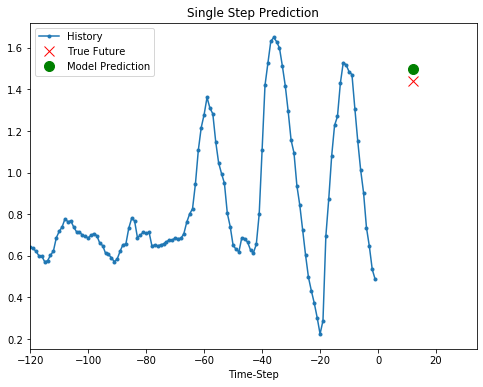

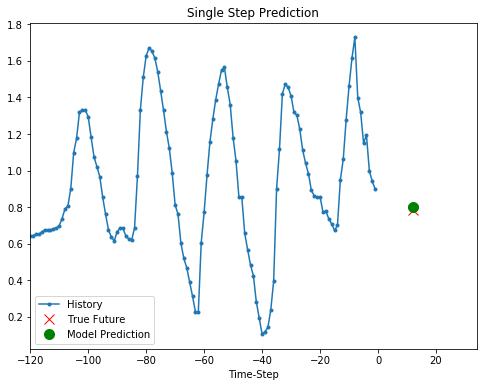

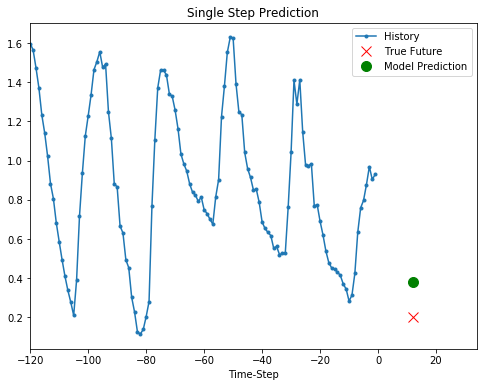

 66048/119759 [===============>..............] - ETA: 24:19 - loss: 0.2196 - mae: 0.21 - ETA: 2:44 - loss: 0.2508 - mae: 0.2508 - ETA: 1:36 - loss: 0.2800 - mae: 0.280 - ETA: 1:10 - loss: 0.2559 - mae: 0.255 - ETA: 57s - loss: 0.2829 - mae: 0.282 - ETA: 49s - loss: 0.2828 - mae: 0.28 - ETA: 45s - loss: 0.2612 - mae: 0.26 - ETA: 41s - loss: 0.2538 - mae: 0.25 - ETA: 39s - loss: 0.2470 - mae: 0.24 - ETA: 37s - loss: 0.2616 - mae: 0.26 - ETA: 35s - loss: 0.2684 - mae: 0.26 - ETA: 33s - loss: 0.2632 - mae: 0.26 - ETA: 32s - loss: 0.2506 - mae: 0.25 - ETA: 31s - loss: 0.2468 - mae: 0.24 - ETA: 30s - loss: 0.2370 - mae: 0.23 - ETA: 29s - loss: 0.2423 - mae: 0.24 - ETA: 29s - loss: 0.2457 - mae: 0.24 - ETA: 28s - loss: 0.2397 - mae: 0.23 - ETA: 27s - loss: 0.2380 - mae: 0.23 - ETA: 27s - loss: 0.2341 - mae: 0.23 - ETA: 26s - loss: 0.2404 - mae: 0.24 - ETA: 26s - loss: 0.2452 - mae: 0.24 - ETA: 25s - loss: 0.2442 - mae: 0.24 - ETA: 25s - loss: 0.2491 - mae: 0.24 - ETA: 25s - loss: 0.2536 - mae

119759/119759 [==============================] - ETA: 9s - loss: 0.2751 - mae: 0.275 - ETA: 9s - loss: 0.2759 - mae: 0.275 - ETA: 9s - loss: 0.2761 - mae: 0.276 - ETA: 9s - loss: 0.2758 - mae: 0.275 - ETA: 9s - loss: 0.2753 - mae: 0.275 - ETA: 9s - loss: 0.2750 - mae: 0.275 - ETA: 9s - loss: 0.2747 - mae: 0.274 - ETA: 9s - loss: 0.2749 - mae: 0.274 - ETA: 9s - loss: 0.2747 - mae: 0.274 - ETA: 9s - loss: 0.2743 - mae: 0.274 - ETA: 8s - loss: 0.2738 - mae: 0.273 - ETA: 8s - loss: 0.2733 - mae: 0.273 - ETA: 8s - loss: 0.2730 - mae: 0.273 - ETA: 8s - loss: 0.2729 - mae: 0.272 - ETA: 8s - loss: 0.2738 - mae: 0.273 - ETA: 8s - loss: 0.2739 - mae: 0.273 - ETA: 8s - loss: 0.2738 - mae: 0.273 - ETA: 8s - loss: 0.2748 - mae: 0.274 - ETA: 8s - loss: 0.2745 - mae: 0.274 - ETA: 8s - loss: 0.2748 - mae: 0.274 - ETA: 8s - loss: 0.2747 - mae: 0.274 - ETA: 8s - loss: 0.2747 - mae: 0.274 - ETA: 8s - loss: 0.2747 - mae: 0.274 - ETA: 8s - loss: 0.2740 - mae: 0.274 - ETA: 8s - loss: 0.2742 - mae: 0.274 - E

In [23]:
plot_preds(models[0], val_data_single)

tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_val_single, y_val_single)

#  Random Search

In [24]:
%%time

randommodel = TimeSeriesLSTM(num_outputs=1)

random_tuner = RandomSearch(
    randommodel,
    objective='mae',
    max_trials=5,
#     executions_per_trial=2,
    directory='my_dir',
    project_name='helloworld_random')

random_tuner.search(x_train_single, y_train_single, epochs=2, validation_data=(x_val_single, y_val_single))

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 32192/299280 [==>...........................] - ETA: 4:18:12 - loss: 0.6887 - mae: 0.68 - ETA: 44:29 - loss: 0.7014 - mae: 0.7014 - ETA: 25:04 - loss: 0.6925 - mae: 0.69 - ETA: 17:47 - loss: 0.6509 - mae: 0.65 - ETA: 13:58 - loss: 0.6199 - mae: 0.61 - ETA: 11:39 - loss: 0.5855 - mae: 0.58 - ETA: 10:03 - loss: 0.5548 - mae: 0.55 - ETA: 8:53 - loss: 0.5323 - mae: 0.5323 - ETA: 8:01 - loss: 0.5129 - mae: 0.512 - ETA: 7:20 - loss: 0.4972 - mae: 0.497 - ETA: 6:47 - loss: 0.4848 - mae: 0.484 - ETA: 6:20 - loss: 0.4753 - mae: 0.475 - ETA: 5:57 - loss: 0.4658 - mae: 0.465 - ETA: 5:38 - loss: 0.4586 - mae: 0.458 - ETA: 5:22 - loss: 0.4539 - mae: 0.453 - ETA: 5:07 - loss: 0.4492 - mae: 0.449 - ETA: 4:55 - loss: 0.4445 - mae: 0.444 - ETA: 4:44 - loss: 0.4390 - mae: 0.439 - ETA: 4:34 - loss: 0.4326 - mae: 0.432 - ETA: 4:25 - loss: 0.4291 - mae: 0.429 - ETA: 4:17 - loss: 0.4261 - mae: 0.426 - ETA: 4:10 - loss: 0.4234 - mae: 0.423 - ETA: 4:03 - loss: 0.4207 - mae: 0.420 - ETA: 3:57 - loss: 0.4169 -

 64800/299280 [=====>........................] - ETA: 1:48 - loss: 0.3036 - mae: 0.303 - ETA: 1:48 - loss: 0.3033 - mae: 0.303 - ETA: 1:48 - loss: 0.3032 - mae: 0.303 - ETA: 1:48 - loss: 0.3031 - mae: 0.303 - ETA: 1:48 - loss: 0.3029 - mae: 0.302 - ETA: 1:48 - loss: 0.3028 - mae: 0.302 - ETA: 1:48 - loss: 0.3027 - mae: 0.302 - ETA: 1:48 - loss: 0.3026 - mae: 0.302 - ETA: 1:47 - loss: 0.3024 - mae: 0.302 - ETA: 1:47 - loss: 0.3022 - mae: 0.302 - ETA: 1:47 - loss: 0.3021 - mae: 0.302 - ETA: 1:47 - loss: 0.3018 - mae: 0.301 - ETA: 1:47 - loss: 0.3019 - mae: 0.301 - ETA: 1:47 - loss: 0.3019 - mae: 0.301 - ETA: 1:47 - loss: 0.3017 - mae: 0.301 - ETA: 1:47 - loss: 0.3017 - mae: 0.301 - ETA: 1:46 - loss: 0.3017 - mae: 0.301 - ETA: 1:46 - loss: 0.3016 - mae: 0.301 - ETA: 1:46 - loss: 0.3014 - mae: 0.301 - ETA: 1:46 - loss: 0.3014 - mae: 0.301 - ETA: 1:46 - loss: 0.3014 - mae: 0.301 - ETA: 1:46 - loss: 0.3012 - mae: 0.301 - ETA: 1:46 - loss: 0.3010 - mae: 0.301 - ETA: 1:45 - loss: 0.3009 - mae:

 97440/299280 [========>.....................] - ETA: 1:29 - loss: 0.2851 - mae: 0.285 - ETA: 1:29 - loss: 0.2850 - mae: 0.285 - ETA: 1:29 - loss: 0.2849 - mae: 0.284 - ETA: 1:29 - loss: 0.2849 - mae: 0.284 - ETA: 1:29 - loss: 0.2849 - mae: 0.284 - ETA: 1:29 - loss: 0.2848 - mae: 0.284 - ETA: 1:28 - loss: 0.2847 - mae: 0.284 - ETA: 1:28 - loss: 0.2847 - mae: 0.284 - ETA: 1:28 - loss: 0.2845 - mae: 0.284 - ETA: 1:28 - loss: 0.2845 - mae: 0.284 - ETA: 1:28 - loss: 0.2843 - mae: 0.284 - ETA: 1:28 - loss: 0.2843 - mae: 0.284 - ETA: 1:28 - loss: 0.2842 - mae: 0.284 - ETA: 1:28 - loss: 0.2841 - mae: 0.284 - ETA: 1:28 - loss: 0.2841 - mae: 0.284 - ETA: 1:28 - loss: 0.2841 - mae: 0.284 - ETA: 1:28 - loss: 0.2840 - mae: 0.284 - ETA: 1:28 - loss: 0.2840 - mae: 0.284 - ETA: 1:28 - loss: 0.2840 - mae: 0.284 - ETA: 1:27 - loss: 0.2839 - mae: 0.283 - ETA: 1:27 - loss: 0.2838 - mae: 0.283 - ETA: 1:27 - loss: 0.2838 - mae: 0.283 - ETA: 1:27 - loss: 0.2837 - mae: 0.283 - ETA: 1:27 - loss: 0.2837 - mae:

130080/299280 [============>.................] - ETA: 1:15 - loss: 0.2749 - mae: 0.274 - ETA: 1:15 - loss: 0.2749 - mae: 0.274 - ETA: 1:15 - loss: 0.2749 - mae: 0.274 - ETA: 1:15 - loss: 0.2748 - mae: 0.274 - ETA: 1:15 - loss: 0.2748 - mae: 0.274 - ETA: 1:14 - loss: 0.2748 - mae: 0.274 - ETA: 1:14 - loss: 0.2747 - mae: 0.274 - ETA: 1:14 - loss: 0.2746 - mae: 0.274 - ETA: 1:14 - loss: 0.2746 - mae: 0.274 - ETA: 1:14 - loss: 0.2746 - mae: 0.274 - ETA: 1:14 - loss: 0.2745 - mae: 0.274 - ETA: 1:14 - loss: 0.2745 - mae: 0.274 - ETA: 1:14 - loss: 0.2744 - mae: 0.274 - ETA: 1:14 - loss: 0.2744 - mae: 0.274 - ETA: 1:14 - loss: 0.2744 - mae: 0.274 - ETA: 1:14 - loss: 0.2744 - mae: 0.274 - ETA: 1:14 - loss: 0.2744 - mae: 0.274 - ETA: 1:14 - loss: 0.2743 - mae: 0.274 - ETA: 1:14 - loss: 0.2743 - mae: 0.274 - ETA: 1:14 - loss: 0.2743 - mae: 0.274 - ETA: 1:14 - loss: 0.2743 - mae: 0.274 - ETA: 1:13 - loss: 0.2742 - mae: 0.274 - ETA: 1:13 - loss: 0.2742 - mae: 0.274 - ETA: 1:13 - loss: 0.2741 - mae:

164064/299280 [===============>..............] - ETA: 1:02 - loss: 0.2696 - mae: 0.269 - ETA: 1:02 - loss: 0.2696 - mae: 0.269 - ETA: 1:02 - loss: 0.2696 - mae: 0.269 - ETA: 1:02 - loss: 0.2696 - mae: 0.269 - ETA: 1:02 - loss: 0.2695 - mae: 0.269 - ETA: 1:02 - loss: 0.2695 - mae: 0.269 - ETA: 1:01 - loss: 0.2695 - mae: 0.269 - ETA: 1:01 - loss: 0.2695 - mae: 0.269 - ETA: 1:01 - loss: 0.2694 - mae: 0.269 - ETA: 1:01 - loss: 0.2694 - mae: 0.269 - ETA: 1:01 - loss: 0.2693 - mae: 0.269 - ETA: 1:01 - loss: 0.2693 - mae: 0.269 - ETA: 1:01 - loss: 0.2693 - mae: 0.269 - ETA: 1:01 - loss: 0.2693 - mae: 0.269 - ETA: 1:01 - loss: 0.2692 - mae: 0.269 - ETA: 1:01 - loss: 0.2692 - mae: 0.269 - ETA: 1:01 - loss: 0.2692 - mae: 0.269 - ETA: 1:01 - loss: 0.2692 - mae: 0.269 - ETA: 1:01 - loss: 0.2692 - mae: 0.269 - ETA: 1:01 - loss: 0.2692 - mae: 0.269 - ETA: 1:01 - loss: 0.2692 - mae: 0.269 - ETA: 1:01 - loss: 0.2692 - mae: 0.269 - ETA: 1:01 - loss: 0.2691 - mae: 0.269 - ETA: 1:00 - loss: 0.2691 - mae:

198464/299280 [==================>...........] - ETA: 49s - loss: 0.2652 - mae: 0.26 - ETA: 49s - loss: 0.2651 - mae: 0.26 - ETA: 49s - loss: 0.2651 - mae: 0.26 - ETA: 49s - loss: 0.2651 - mae: 0.26 - ETA: 49s - loss: 0.2651 - mae: 0.26 - ETA: 49s - loss: 0.2651 - mae: 0.26 - ETA: 49s - loss: 0.2650 - mae: 0.26 - ETA: 48s - loss: 0.2650 - mae: 0.26 - ETA: 48s - loss: 0.2650 - mae: 0.26 - ETA: 48s - loss: 0.2651 - mae: 0.26 - ETA: 48s - loss: 0.2650 - mae: 0.26 - ETA: 48s - loss: 0.2650 - mae: 0.26 - ETA: 48s - loss: 0.2650 - mae: 0.26 - ETA: 48s - loss: 0.2650 - mae: 0.26 - ETA: 48s - loss: 0.2650 - mae: 0.26 - ETA: 48s - loss: 0.2649 - mae: 0.26 - ETA: 48s - loss: 0.2649 - mae: 0.26 - ETA: 48s - loss: 0.2649 - mae: 0.26 - ETA: 48s - loss: 0.2649 - mae: 0.26 - ETA: 48s - loss: 0.2649 - mae: 0.26 - ETA: 48s - loss: 0.2648 - mae: 0.26 - ETA: 48s - loss: 0.2648 - mae: 0.26 - ETA: 48s - loss: 0.2648 - mae: 0.26 - ETA: 48s - loss: 0.2648 - mae: 0.26 - ETA: 47s - loss: 0.2648 - mae: 0.26 - E

232864/299280 [======================>.......] - ETA: 36s - loss: 0.2622 - mae: 0.26 - ETA: 36s - loss: 0.2622 - mae: 0.26 - ETA: 36s - loss: 0.2622 - mae: 0.26 - ETA: 36s - loss: 0.2621 - mae: 0.26 - ETA: 36s - loss: 0.2621 - mae: 0.26 - ETA: 36s - loss: 0.2621 - mae: 0.26 - ETA: 36s - loss: 0.2621 - mae: 0.26 - ETA: 36s - loss: 0.2621 - mae: 0.26 - ETA: 36s - loss: 0.2621 - mae: 0.26 - ETA: 36s - loss: 0.2621 - mae: 0.26 - ETA: 36s - loss: 0.2621 - mae: 0.26 - ETA: 35s - loss: 0.2621 - mae: 0.26 - ETA: 35s - loss: 0.2621 - mae: 0.26 - ETA: 35s - loss: 0.2621 - mae: 0.26 - ETA: 35s - loss: 0.2621 - mae: 0.26 - ETA: 35s - loss: 0.2620 - mae: 0.26 - ETA: 35s - loss: 0.2620 - mae: 0.26 - ETA: 35s - loss: 0.2620 - mae: 0.26 - ETA: 35s - loss: 0.2620 - mae: 0.26 - ETA: 35s - loss: 0.2620 - mae: 0.26 - ETA: 35s - loss: 0.2620 - mae: 0.26 - ETA: 35s - loss: 0.2620 - mae: 0.26 - ETA: 35s - loss: 0.2620 - mae: 0.26 - ETA: 35s - loss: 0.2620 - mae: 0.26 - ETA: 35s - loss: 0.2620 - mae: 0.26 - E

267264/299280 [=========================>....] - ETA: 24s - loss: 0.2595 - mae: 0.25 - ETA: 23s - loss: 0.2595 - mae: 0.25 - ETA: 23s - loss: 0.2595 - mae: 0.25 - ETA: 23s - loss: 0.2595 - mae: 0.25 - ETA: 23s - loss: 0.2595 - mae: 0.25 - ETA: 23s - loss: 0.2595 - mae: 0.25 - ETA: 23s - loss: 0.2595 - mae: 0.25 - ETA: 23s - loss: 0.2594 - mae: 0.25 - ETA: 23s - loss: 0.2594 - mae: 0.25 - ETA: 23s - loss: 0.2594 - mae: 0.25 - ETA: 23s - loss: 0.2594 - mae: 0.25 - ETA: 23s - loss: 0.2594 - mae: 0.25 - ETA: 23s - loss: 0.2594 - mae: 0.25 - ETA: 23s - loss: 0.2594 - mae: 0.25 - ETA: 23s - loss: 0.2594 - mae: 0.25 - ETA: 23s - loss: 0.2594 - mae: 0.25 - ETA: 23s - loss: 0.2594 - mae: 0.25 - ETA: 23s - loss: 0.2594 - mae: 0.25 - ETA: 22s - loss: 0.2594 - mae: 0.25 - ETA: 22s - loss: 0.2593 - mae: 0.25 - ETA: 22s - loss: 0.2593 - mae: 0.25 - ETA: 22s - loss: 0.2593 - mae: 0.25 - ETA: 22s - loss: 0.2593 - mae: 0.25 - ETA: 22s - loss: 0.2593 - mae: 0.25 - ETA: 22s - loss: 0.2593 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2577 - mae: 0.25 - ETA: 11s - loss: 0.2577 - mae: 0.25 - ETA: 11s - loss: 0.2577 - mae: 0.25 - ETA: 11s - loss: 0.2577 - mae: 0.25 - ETA: 11s - loss: 0.2577 - mae: 0.25 - ETA: 11s - loss: 0.2577 - mae: 0.25 - ETA: 11s - loss: 0.2577 - mae: 0.25 - ETA: 11s - loss: 0.2577 - mae: 0.25 - ETA: 11s - loss: 0.2577 - mae: 0.25 - ETA: 10s - loss: 0.2577 - mae: 0.25 - ETA: 10s - loss: 0.2577 - mae: 0.25 - ETA: 10s - loss: 0.2577 - mae: 0.25 - ETA: 10s - loss: 0.2576 - mae: 0.25 - ETA: 10s - loss: 0.2576 - mae: 0.25 - ETA: 10s - loss: 0.2576 - mae: 0.25 - ETA: 10s - loss: 0.2576 - mae: 0.25 - ETA: 10s - loss: 0.2576 - mae: 0.25 - ETA: 10s - loss: 0.2576 - mae: 0.25 - ETA: 10s - loss: 0.2576 - mae: 0.25 - ETA: 10s - loss: 0.2576 - mae: 0.25 - ETA: 10s - loss: 0.2576 - mae: 0.25 - ETA: 10s - loss: 0.2576 - mae: 0.25 - ETA: 10s - loss: 0.2576 - mae: 0.25 - ETA: 10s - loss: 0.2576 - mae: 0.25 - ETA: 10s - loss: 0.2576 - mae: 0.25 - E

 32448/299280 [==>...........................] - ETA: 2:01 - loss: 0.2782 - mae: 0.278 - ETA: 1:50 - loss: 0.2410 - mae: 0.241 - ETA: 1:50 - loss: 0.2378 - mae: 0.237 - ETA: 1:49 - loss: 0.2318 - mae: 0.231 - ETA: 1:49 - loss: 0.2412 - mae: 0.241 - ETA: 1:48 - loss: 0.2436 - mae: 0.243 - ETA: 1:48 - loss: 0.2419 - mae: 0.241 - ETA: 1:48 - loss: 0.2414 - mae: 0.241 - ETA: 1:48 - loss: 0.2397 - mae: 0.239 - ETA: 1:47 - loss: 0.2404 - mae: 0.240 - ETA: 1:47 - loss: 0.2429 - mae: 0.242 - ETA: 1:47 - loss: 0.2404 - mae: 0.240 - ETA: 1:47 - loss: 0.2403 - mae: 0.240 - ETA: 1:47 - loss: 0.2395 - mae: 0.239 - ETA: 1:47 - loss: 0.2391 - mae: 0.239 - ETA: 1:47 - loss: 0.2405 - mae: 0.240 - ETA: 1:47 - loss: 0.2397 - mae: 0.239 - ETA: 1:47 - loss: 0.2399 - mae: 0.239 - ETA: 1:47 - loss: 0.2400 - mae: 0.240 - ETA: 1:47 - loss: 0.2399 - mae: 0.239 - ETA: 1:47 - loss: 0.2398 - mae: 0.239 - ETA: 1:47 - loss: 0.2398 - mae: 0.239 - ETA: 1:46 - loss: 0.2392 - mae: 0.239 - ETA: 1:46 - loss: 0.2395 - mae:

 65088/299280 [=====>........................] - ETA: 1:34 - loss: 0.2428 - mae: 0.242 - ETA: 1:34 - loss: 0.2428 - mae: 0.242 - ETA: 1:34 - loss: 0.2426 - mae: 0.242 - ETA: 1:34 - loss: 0.2426 - mae: 0.242 - ETA: 1:34 - loss: 0.2425 - mae: 0.242 - ETA: 1:34 - loss: 0.2424 - mae: 0.242 - ETA: 1:34 - loss: 0.2424 - mae: 0.242 - ETA: 1:34 - loss: 0.2424 - mae: 0.242 - ETA: 1:34 - loss: 0.2424 - mae: 0.242 - ETA: 1:34 - loss: 0.2425 - mae: 0.242 - ETA: 1:33 - loss: 0.2425 - mae: 0.242 - ETA: 1:33 - loss: 0.2426 - mae: 0.242 - ETA: 1:33 - loss: 0.2426 - mae: 0.242 - ETA: 1:33 - loss: 0.2425 - mae: 0.242 - ETA: 1:33 - loss: 0.2426 - mae: 0.242 - ETA: 1:33 - loss: 0.2426 - mae: 0.242 - ETA: 1:33 - loss: 0.2425 - mae: 0.242 - ETA: 1:33 - loss: 0.2426 - mae: 0.242 - ETA: 1:33 - loss: 0.2425 - mae: 0.242 - ETA: 1:33 - loss: 0.2424 - mae: 0.242 - ETA: 1:33 - loss: 0.2423 - mae: 0.242 - ETA: 1:33 - loss: 0.2424 - mae: 0.242 - ETA: 1:33 - loss: 0.2424 - mae: 0.242 - ETA: 1:33 - loss: 0.2424 - mae:

 97728/299280 [========>.....................] - ETA: 1:23 - loss: 0.2426 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2426 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2424 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:22 - loss: 0.2425 - mae: 0.242 - ETA: 1:21 - loss: 0.2425 - mae: 0.242 - ETA: 1:21 - loss: 0.2425 - mae: 0.242 - ETA: 1:21 - loss: 0.2426 - mae: 0.242 - ETA: 1:21 - loss: 0.2426 - mae: 0.242 - ETA: 1:21 - loss: 0.2426 - mae:

130272/299280 [============>.................] - ETA: 1:11 - loss: 0.2422 - mae: 0.242 - ETA: 1:11 - loss: 0.2422 - mae: 0.242 - ETA: 1:11 - loss: 0.2423 - mae: 0.242 - ETA: 1:11 - loss: 0.2423 - mae: 0.242 - ETA: 1:11 - loss: 0.2422 - mae: 0.242 - ETA: 1:11 - loss: 0.2422 - mae: 0.242 - ETA: 1:11 - loss: 0.2422 - mae: 0.242 - ETA: 1:11 - loss: 0.2422 - mae: 0.242 - ETA: 1:10 - loss: 0.2422 - mae: 0.242 - ETA: 1:10 - loss: 0.2422 - mae: 0.242 - ETA: 1:10 - loss: 0.2421 - mae: 0.242 - ETA: 1:10 - loss: 0.2421 - mae: 0.242 - ETA: 1:10 - loss: 0.2421 - mae: 0.242 - ETA: 1:10 - loss: 0.2421 - mae: 0.242 - ETA: 1:10 - loss: 0.2422 - mae: 0.242 - ETA: 1:10 - loss: 0.2422 - mae: 0.242 - ETA: 1:10 - loss: 0.2422 - mae: 0.242 - ETA: 1:10 - loss: 0.2421 - mae: 0.242 - ETA: 1:10 - loss: 0.2422 - mae: 0.242 - ETA: 1:10 - loss: 0.2422 - mae: 0.242 - ETA: 1:10 - loss: 0.2422 - mae: 0.242 - ETA: 1:10 - loss: 0.2422 - mae: 0.242 - ETA: 1:10 - loss: 0.2422 - mae: 0.242 - ETA: 1:10 - loss: 0.2422 - mae:

164672/299280 [===============>..............] - ETA: 59s - loss: 0.2412 - mae: 0.24 - ETA: 59s - loss: 0.2413 - mae: 0.24 - ETA: 59s - loss: 0.2413 - mae: 0.24 - ETA: 59s - loss: 0.2412 - mae: 0.24 - ETA: 59s - loss: 0.2412 - mae: 0.24 - ETA: 59s - loss: 0.2413 - mae: 0.24 - ETA: 59s - loss: 0.2412 - mae: 0.24 - ETA: 59s - loss: 0.2412 - mae: 0.24 - ETA: 59s - loss: 0.2412 - mae: 0.24 - ETA: 59s - loss: 0.2412 - mae: 0.24 - ETA: 59s - loss: 0.2412 - mae: 0.24 - ETA: 59s - loss: 0.2412 - mae: 0.24 - ETA: 59s - loss: 0.2412 - mae: 0.24 - ETA: 59s - loss: 0.2411 - mae: 0.24 - ETA: 59s - loss: 0.2411 - mae: 0.24 - ETA: 59s - loss: 0.2411 - mae: 0.24 - ETA: 59s - loss: 0.2411 - mae: 0.24 - ETA: 58s - loss: 0.2411 - mae: 0.24 - ETA: 58s - loss: 0.2411 - mae: 0.24 - ETA: 58s - loss: 0.2411 - mae: 0.24 - ETA: 58s - loss: 0.2411 - mae: 0.24 - ETA: 58s - loss: 0.2411 - mae: 0.24 - ETA: 58s - loss: 0.2411 - mae: 0.24 - ETA: 58s - loss: 0.2411 - mae: 0.24 - ETA: 58s - loss: 0.2411 - mae: 0.24 - E

199040/299280 [==================>...........] - ETA: 47s - loss: 0.2410 - mae: 0.24 - ETA: 47s - loss: 0.2410 - mae: 0.24 - ETA: 47s - loss: 0.2410 - mae: 0.24 - ETA: 47s - loss: 0.2410 - mae: 0.24 - ETA: 47s - loss: 0.2410 - mae: 0.24 - ETA: 47s - loss: 0.2410 - mae: 0.24 - ETA: 47s - loss: 0.2410 - mae: 0.24 - ETA: 47s - loss: 0.2410 - mae: 0.24 - ETA: 47s - loss: 0.2409 - mae: 0.24 - ETA: 47s - loss: 0.2409 - mae: 0.24 - ETA: 47s - loss: 0.2409 - mae: 0.24 - ETA: 47s - loss: 0.2410 - mae: 0.24 - ETA: 47s - loss: 0.2410 - mae: 0.24 - ETA: 46s - loss: 0.2410 - mae: 0.24 - ETA: 46s - loss: 0.2410 - mae: 0.24 - ETA: 46s - loss: 0.2410 - mae: 0.24 - ETA: 46s - loss: 0.2410 - mae: 0.24 - ETA: 46s - loss: 0.2409 - mae: 0.24 - ETA: 46s - loss: 0.2409 - mae: 0.24 - ETA: 46s - loss: 0.2410 - mae: 0.24 - ETA: 46s - loss: 0.2410 - mae: 0.24 - ETA: 46s - loss: 0.2409 - mae: 0.24 - ETA: 46s - loss: 0.2409 - mae: 0.24 - ETA: 46s - loss: 0.2409 - mae: 0.24 - ETA: 46s - loss: 0.2409 - mae: 0.24 - E

233440/299280 [======================>.......] - ETA: 35s - loss: 0.2404 - mae: 0.24 - ETA: 35s - loss: 0.2404 - mae: 0.24 - ETA: 35s - loss: 0.2404 - mae: 0.24 - ETA: 35s - loss: 0.2404 - mae: 0.24 - ETA: 35s - loss: 0.2404 - mae: 0.24 - ETA: 35s - loss: 0.2404 - mae: 0.24 - ETA: 35s - loss: 0.2404 - mae: 0.24 - ETA: 35s - loss: 0.2404 - mae: 0.24 - ETA: 35s - loss: 0.2404 - mae: 0.24 - ETA: 35s - loss: 0.2404 - mae: 0.24 - ETA: 34s - loss: 0.2404 - mae: 0.24 - ETA: 34s - loss: 0.2404 - mae: 0.24 - ETA: 34s - loss: 0.2404 - mae: 0.24 - ETA: 34s - loss: 0.2404 - mae: 0.24 - ETA: 34s - loss: 0.2404 - mae: 0.24 - ETA: 34s - loss: 0.2404 - mae: 0.24 - ETA: 34s - loss: 0.2404 - mae: 0.24 - ETA: 34s - loss: 0.2404 - mae: 0.24 - ETA: 34s - loss: 0.2404 - mae: 0.24 - ETA: 34s - loss: 0.2404 - mae: 0.24 - ETA: 34s - loss: 0.2404 - mae: 0.24 - ETA: 34s - loss: 0.2404 - mae: 0.24 - ETA: 34s - loss: 0.2403 - mae: 0.24 - ETA: 34s - loss: 0.2403 - mae: 0.24 - ETA: 34s - loss: 0.2403 - mae: 0.24 - E

267840/299280 [=========================>....] - ETA: 23s - loss: 0.2401 - mae: 0.24 - ETA: 23s - loss: 0.2401 - mae: 0.24 - ETA: 23s - loss: 0.2401 - mae: 0.24 - ETA: 23s - loss: 0.2401 - mae: 0.24 - ETA: 23s - loss: 0.2401 - mae: 0.24 - ETA: 23s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 22s - loss: 0.2401 - mae: 0.24 - ETA: 21s - loss: 0.2401 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2397 - mae: 0.23 - ETA: 11s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 10s - loss: 0.2397 - mae: 0.23 - ETA: 9s - loss: 0.2397 - mae: 0.2397 - ETA: 9s - loss: 0.2397 - mae: 0.239 - ETA: 9s - loss: 0.2397 - mae: 0.239 - ETA: 9s - loss: 0.2397 - mae: 0.239 - ETA: 9s - loss: 0.2397 - mae: 0.239 - 

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 31296/299280 [==>...........................] - ETA: 4:14:35 - loss: 0.7402 - mae: 0.74 - ETA: 43:57 - loss: 0.7535 - mae: 0.7535 - ETA: 24:49 - loss: 0.7396 - mae: 0.73 - ETA: 17:39 - loss: 0.6915 - mae: 0.69 - ETA: 13:52 - loss: 0.6495 - mae: 0.64 - ETA: 11:33 - loss: 0.6072 - mae: 0.60 - ETA: 9:59 - loss: 0.5671 - mae: 0.5671 - ETA: 8:50 - loss: 0.5401 - mae: 0.540 - ETA: 7:59 - loss: 0.5164 - mae: 0.516 - ETA: 7:19 - loss: 0.4989 - mae: 0.498 - ETA: 6:47 - loss: 0.4842 - mae: 0.484 - ETA: 6:20 - loss: 0.4726 - mae: 0.472 - ETA: 6:03 - loss: 0.4635 - mae: 0.463 - ETA: 5:48 - loss: 0.4574 - mae: 0.457 - ETA: 5:34 - loss: 0.4494 - mae: 0.449 - ETA: 5:22 - loss: 0.4479 - mae: 0.447 - ETA: 5:11 - loss: 0.4423 - mae: 0.442 - ETA: 4:59 - loss: 0.4372 - mae: 0.437 - ETA: 4:47 - loss: 0.4312 - mae: 0.431 - ETA: 4:37 - loss: 0.4243 - mae: 0.424 - ETA: 4:29 - loss: 0.4201 - mae: 0.420 - ETA: 4:21 - loss: 0.4168 - mae: 0.416 - ETA: 4:13 - loss: 0.4128 - mae: 0.412 - ETA: 4:07 - loss: 0.4095 -

 62496/299280 [=====>........................] - ETA: 1:54 - loss: 0.2987 - mae: 0.298 - ETA: 1:54 - loss: 0.2987 - mae: 0.298 - ETA: 1:54 - loss: 0.2986 - mae: 0.298 - ETA: 1:54 - loss: 0.2984 - mae: 0.298 - ETA: 1:54 - loss: 0.2982 - mae: 0.298 - ETA: 1:54 - loss: 0.2980 - mae: 0.298 - ETA: 1:54 - loss: 0.2979 - mae: 0.297 - ETA: 1:54 - loss: 0.2977 - mae: 0.297 - ETA: 1:53 - loss: 0.2976 - mae: 0.297 - ETA: 1:53 - loss: 0.2975 - mae: 0.297 - ETA: 1:53 - loss: 0.2973 - mae: 0.297 - ETA: 1:53 - loss: 0.2973 - mae: 0.297 - ETA: 1:53 - loss: 0.2971 - mae: 0.297 - ETA: 1:53 - loss: 0.2971 - mae: 0.297 - ETA: 1:53 - loss: 0.2969 - mae: 0.296 - ETA: 1:53 - loss: 0.2968 - mae: 0.296 - ETA: 1:52 - loss: 0.2966 - mae: 0.296 - ETA: 1:52 - loss: 0.2964 - mae: 0.296 - ETA: 1:52 - loss: 0.2963 - mae: 0.296 - ETA: 1:52 - loss: 0.2964 - mae: 0.296 - ETA: 1:52 - loss: 0.2963 - mae: 0.296 - ETA: 1:52 - loss: 0.2963 - mae: 0.296 - ETA: 1:52 - loss: 0.2962 - mae: 0.296 - ETA: 1:52 - loss: 0.2963 - mae:

 94144/299280 [========>.....................] - ETA: 1:35 - loss: 0.2821 - mae: 0.282 - ETA: 1:35 - loss: 0.2821 - mae: 0.282 - ETA: 1:35 - loss: 0.2819 - mae: 0.281 - ETA: 1:35 - loss: 0.2819 - mae: 0.281 - ETA: 1:35 - loss: 0.2818 - mae: 0.281 - ETA: 1:35 - loss: 0.2818 - mae: 0.281 - ETA: 1:35 - loss: 0.2817 - mae: 0.281 - ETA: 1:35 - loss: 0.2816 - mae: 0.281 - ETA: 1:35 - loss: 0.2815 - mae: 0.281 - ETA: 1:34 - loss: 0.2815 - mae: 0.281 - ETA: 1:34 - loss: 0.2815 - mae: 0.281 - ETA: 1:34 - loss: 0.2814 - mae: 0.281 - ETA: 1:34 - loss: 0.2814 - mae: 0.281 - ETA: 1:34 - loss: 0.2813 - mae: 0.281 - ETA: 1:34 - loss: 0.2812 - mae: 0.281 - ETA: 1:34 - loss: 0.2811 - mae: 0.281 - ETA: 1:34 - loss: 0.2810 - mae: 0.281 - ETA: 1:34 - loss: 0.2810 - mae: 0.281 - ETA: 1:34 - loss: 0.2810 - mae: 0.281 - ETA: 1:34 - loss: 0.2810 - mae: 0.281 - ETA: 1:34 - loss: 0.2809 - mae: 0.280 - ETA: 1:34 - loss: 0.2808 - mae: 0.280 - ETA: 1:33 - loss: 0.2808 - mae: 0.280 - ETA: 1:33 - loss: 0.2806 - mae:

126112/299280 [===========>..................] - ETA: 1:21 - loss: 0.2726 - mae: 0.272 - ETA: 1:21 - loss: 0.2726 - mae: 0.272 - ETA: 1:20 - loss: 0.2726 - mae: 0.272 - ETA: 1:20 - loss: 0.2725 - mae: 0.272 - ETA: 1:20 - loss: 0.2725 - mae: 0.272 - ETA: 1:20 - loss: 0.2726 - mae: 0.272 - ETA: 1:20 - loss: 0.2725 - mae: 0.272 - ETA: 1:20 - loss: 0.2725 - mae: 0.272 - ETA: 1:20 - loss: 0.2725 - mae: 0.272 - ETA: 1:20 - loss: 0.2724 - mae: 0.272 - ETA: 1:20 - loss: 0.2724 - mae: 0.272 - ETA: 1:20 - loss: 0.2723 - mae: 0.272 - ETA: 1:20 - loss: 0.2723 - mae: 0.272 - ETA: 1:20 - loss: 0.2723 - mae: 0.272 - ETA: 1:20 - loss: 0.2723 - mae: 0.272 - ETA: 1:20 - loss: 0.2722 - mae: 0.272 - ETA: 1:20 - loss: 0.2722 - mae: 0.272 - ETA: 1:19 - loss: 0.2722 - mae: 0.272 - ETA: 1:19 - loss: 0.2722 - mae: 0.272 - ETA: 1:19 - loss: 0.2721 - mae: 0.272 - ETA: 1:19 - loss: 0.2720 - mae: 0.272 - ETA: 1:19 - loss: 0.2720 - mae: 0.272 - ETA: 1:19 - loss: 0.2719 - mae: 0.271 - ETA: 1:19 - loss: 0.2719 - mae:

158464/299280 [==============>...............] - ETA: 1:07 - loss: 0.2678 - mae: 0.267 - ETA: 1:07 - loss: 0.2677 - mae: 0.267 - ETA: 1:07 - loss: 0.2677 - mae: 0.267 - ETA: 1:07 - loss: 0.2677 - mae: 0.267 - ETA: 1:07 - loss: 0.2676 - mae: 0.267 - ETA: 1:07 - loss: 0.2676 - mae: 0.267 - ETA: 1:07 - loss: 0.2676 - mae: 0.267 - ETA: 1:07 - loss: 0.2675 - mae: 0.267 - ETA: 1:07 - loss: 0.2675 - mae: 0.267 - ETA: 1:07 - loss: 0.2675 - mae: 0.267 - ETA: 1:06 - loss: 0.2675 - mae: 0.267 - ETA: 1:06 - loss: 0.2675 - mae: 0.267 - ETA: 1:06 - loss: 0.2675 - mae: 0.267 - ETA: 1:06 - loss: 0.2675 - mae: 0.267 - ETA: 1:06 - loss: 0.2675 - mae: 0.267 - ETA: 1:06 - loss: 0.2675 - mae: 0.267 - ETA: 1:06 - loss: 0.2674 - mae: 0.267 - ETA: 1:06 - loss: 0.2674 - mae: 0.267 - ETA: 1:06 - loss: 0.2674 - mae: 0.267 - ETA: 1:06 - loss: 0.2673 - mae: 0.267 - ETA: 1:06 - loss: 0.2673 - mae: 0.267 - ETA: 1:06 - loss: 0.2673 - mae: 0.267 - ETA: 1:06 - loss: 0.2673 - mae: 0.267 - ETA: 1:06 - loss: 0.2672 - mae:

191776/299280 [==================>...........] - ETA: 54s - loss: 0.2637 - mae: 0.26 - ETA: 54s - loss: 0.2637 - mae: 0.26 - ETA: 54s - loss: 0.2637 - mae: 0.26 - ETA: 54s - loss: 0.2637 - mae: 0.26 - ETA: 54s - loss: 0.2637 - mae: 0.26 - ETA: 54s - loss: 0.2637 - mae: 0.26 - ETA: 54s - loss: 0.2636 - mae: 0.26 - ETA: 54s - loss: 0.2637 - mae: 0.26 - ETA: 54s - loss: 0.2636 - mae: 0.26 - ETA: 54s - loss: 0.2636 - mae: 0.26 - ETA: 53s - loss: 0.2636 - mae: 0.26 - ETA: 53s - loss: 0.2636 - mae: 0.26 - ETA: 53s - loss: 0.2636 - mae: 0.26 - ETA: 53s - loss: 0.2636 - mae: 0.26 - ETA: 53s - loss: 0.2636 - mae: 0.26 - ETA: 53s - loss: 0.2636 - mae: 0.26 - ETA: 53s - loss: 0.2635 - mae: 0.26 - ETA: 53s - loss: 0.2635 - mae: 0.26 - ETA: 53s - loss: 0.2636 - mae: 0.26 - ETA: 53s - loss: 0.2635 - mae: 0.26 - ETA: 53s - loss: 0.2635 - mae: 0.26 - ETA: 53s - loss: 0.2635 - mae: 0.26 - ETA: 53s - loss: 0.2635 - mae: 0.26 - ETA: 53s - loss: 0.2635 - mae: 0.26 - ETA: 53s - loss: 0.2635 - mae: 0.26 - E

224960/299280 [=====================>........] - ETA: 41s - loss: 0.2610 - mae: 0.26 - ETA: 41s - loss: 0.2610 - mae: 0.26 - ETA: 41s - loss: 0.2610 - mae: 0.26 - ETA: 41s - loss: 0.2610 - mae: 0.26 - ETA: 41s - loss: 0.2610 - mae: 0.26 - ETA: 41s - loss: 0.2610 - mae: 0.26 - ETA: 41s - loss: 0.2609 - mae: 0.26 - ETA: 41s - loss: 0.2609 - mae: 0.26 - ETA: 40s - loss: 0.2609 - mae: 0.26 - ETA: 40s - loss: 0.2609 - mae: 0.26 - ETA: 40s - loss: 0.2609 - mae: 0.26 - ETA: 40s - loss: 0.2609 - mae: 0.26 - ETA: 40s - loss: 0.2609 - mae: 0.26 - ETA: 40s - loss: 0.2609 - mae: 0.26 - ETA: 40s - loss: 0.2609 - mae: 0.26 - ETA: 40s - loss: 0.2609 - mae: 0.26 - ETA: 40s - loss: 0.2609 - mae: 0.26 - ETA: 40s - loss: 0.2609 - mae: 0.26 - ETA: 40s - loss: 0.2608 - mae: 0.26 - ETA: 40s - loss: 0.2608 - mae: 0.26 - ETA: 40s - loss: 0.2608 - mae: 0.26 - ETA: 40s - loss: 0.2608 - mae: 0.26 - ETA: 40s - loss: 0.2608 - mae: 0.26 - ETA: 40s - loss: 0.2608 - mae: 0.26 - ETA: 40s - loss: 0.2608 - mae: 0.26 - E

258400/299280 [========================>.....] - ETA: 28s - loss: 0.2586 - mae: 0.25 - ETA: 28s - loss: 0.2586 - mae: 0.25 - ETA: 28s - loss: 0.2586 - mae: 0.25 - ETA: 28s - loss: 0.2586 - mae: 0.25 - ETA: 28s - loss: 0.2586 - mae: 0.25 - ETA: 28s - loss: 0.2586 - mae: 0.25 - ETA: 28s - loss: 0.2586 - mae: 0.25 - ETA: 28s - loss: 0.2586 - mae: 0.25 - ETA: 28s - loss: 0.2585 - mae: 0.25 - ETA: 28s - loss: 0.2585 - mae: 0.25 - ETA: 27s - loss: 0.2585 - mae: 0.25 - ETA: 27s - loss: 0.2585 - mae: 0.25 - ETA: 27s - loss: 0.2585 - mae: 0.25 - ETA: 27s - loss: 0.2585 - mae: 0.25 - ETA: 27s - loss: 0.2585 - mae: 0.25 - ETA: 27s - loss: 0.2585 - mae: 0.25 - ETA: 27s - loss: 0.2585 - mae: 0.25 - ETA: 27s - loss: 0.2585 - mae: 0.25 - ETA: 27s - loss: 0.2584 - mae: 0.25 - ETA: 27s - loss: 0.2584 - mae: 0.25 - ETA: 27s - loss: 0.2584 - mae: 0.25 - ETA: 27s - loss: 0.2584 - mae: 0.25 - ETA: 27s - loss: 0.2584 - mae: 0.25 - ETA: 27s - loss: 0.2584 - mae: 0.25 - ETA: 27s - loss: 0.2584 - mae: 0.25 - E

291872/299280 [============================>.] - ETA: 15s - loss: 0.2568 - mae: 0.25 - ETA: 15s - loss: 0.2568 - mae: 0.25 - ETA: 15s - loss: 0.2568 - mae: 0.25 - ETA: 15s - loss: 0.2568 - mae: 0.25 - ETA: 15s - loss: 0.2568 - mae: 0.25 - ETA: 15s - loss: 0.2568 - mae: 0.25 - ETA: 15s - loss: 0.2568 - mae: 0.25 - ETA: 15s - loss: 0.2568 - mae: 0.25 - ETA: 15s - loss: 0.2568 - mae: 0.25 - ETA: 15s - loss: 0.2568 - mae: 0.25 - ETA: 15s - loss: 0.2568 - mae: 0.25 - ETA: 14s - loss: 0.2568 - mae: 0.25 - ETA: 14s - loss: 0.2568 - mae: 0.25 - ETA: 14s - loss: 0.2568 - mae: 0.25 - ETA: 14s - loss: 0.2568 - mae: 0.25 - ETA: 14s - loss: 0.2568 - mae: 0.25 - ETA: 14s - loss: 0.2568 - mae: 0.25 - ETA: 14s - loss: 0.2568 - mae: 0.25 - ETA: 14s - loss: 0.2567 - mae: 0.25 - ETA: 14s - loss: 0.2567 - mae: 0.25 - ETA: 14s - loss: 0.2567 - mae: 0.25 - ETA: 14s - loss: 0.2567 - mae: 0.25 - ETA: 14s - loss: 0.2567 - mae: 0.25 - ETA: 14s - loss: 0.2567 - mae: 0.25 - ETA: 14s - loss: 0.2567 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 2s - loss: 0.2555 - mae: 0.255 - ETA: 2s - loss: 0.2555 - mae: 0.255 - ETA: 2s - loss: 0.2555 - mae: 0.255 - ETA: 2s - loss: 0.2555 - mae: 0.255 - ETA: 2s - loss: 0.2555 - mae: 0.255 - ETA: 2s - loss: 0.2555 - mae: 0.255 - ETA: 2s - loss: 0.2555 - mae: 0.255 - ETA: 2s - loss: 0.2555 - mae: 0.255 - ETA: 2s - loss: 0.2554 - mae: 0.255 - ETA: 2s - loss: 0.2554 - mae: 0.255 - ETA: 2s - loss: 0.2554 - mae: 0.255 - ETA: 2s - loss: 0.2554 - mae: 0.255 - ETA: 2s - loss: 0.2554 - mae: 0.255 - ETA: 1s - loss: 0.2554 - mae: 0.255 - ETA: 1s - loss: 0.2554 - mae: 0.255 - ETA: 1s - loss: 0.2554 - mae: 0.255 - ETA: 1s - loss: 0.2554 - mae: 0.255 - ETA: 1s - loss: 0.2554 - mae: 0.255 - ETA: 1s - loss: 0.2554 - mae: 0.255 - ETA: 1s - loss: 0.2554 - mae: 0.255 - ETA: 1s - loss: 0.2553 - mae: 0.255 - ETA: 1s - loss: 0.2553 - mae: 0.255 - ETA: 1s - loss: 0.2553 - mae: 0.255 - ETA: 1s - loss: 0.2553 - mae: 0.255 - ETA: 1s - loss: 0.2553 - mae: 0.255 - E

 31488/299280 [==>...........................] - ETA: 2:10 - loss: 0.2742 - mae: 0.274 - ETA: 1:54 - loss: 0.2448 - mae: 0.244 - ETA: 1:54 - loss: 0.2394 - mae: 0.239 - ETA: 1:53 - loss: 0.2323 - mae: 0.232 - ETA: 1:52 - loss: 0.2429 - mae: 0.242 - ETA: 1:52 - loss: 0.2446 - mae: 0.244 - ETA: 1:52 - loss: 0.2428 - mae: 0.242 - ETA: 1:51 - loss: 0.2427 - mae: 0.242 - ETA: 1:51 - loss: 0.2405 - mae: 0.240 - ETA: 1:51 - loss: 0.2411 - mae: 0.241 - ETA: 1:51 - loss: 0.2437 - mae: 0.243 - ETA: 1:51 - loss: 0.2411 - mae: 0.241 - ETA: 1:51 - loss: 0.2410 - mae: 0.241 - ETA: 1:52 - loss: 0.2394 - mae: 0.239 - ETA: 1:52 - loss: 0.2391 - mae: 0.239 - ETA: 1:52 - loss: 0.2396 - mae: 0.239 - ETA: 1:52 - loss: 0.2402 - mae: 0.240 - ETA: 1:53 - loss: 0.2395 - mae: 0.239 - ETA: 1:53 - loss: 0.2398 - mae: 0.239 - ETA: 1:52 - loss: 0.2395 - mae: 0.239 - ETA: 1:52 - loss: 0.2401 - mae: 0.240 - ETA: 1:52 - loss: 0.2400 - mae: 0.240 - ETA: 1:52 - loss: 0.2396 - mae: 0.239 - ETA: 1:51 - loss: 0.2395 - mae:

 63072/299280 [=====>........................] - ETA: 1:41 - loss: 0.2422 - mae: 0.242 - ETA: 1:41 - loss: 0.2421 - mae: 0.242 - ETA: 1:41 - loss: 0.2423 - mae: 0.242 - ETA: 1:41 - loss: 0.2424 - mae: 0.242 - ETA: 1:41 - loss: 0.2424 - mae: 0.242 - ETA: 1:40 - loss: 0.2423 - mae: 0.242 - ETA: 1:40 - loss: 0.2423 - mae: 0.242 - ETA: 1:40 - loss: 0.2422 - mae: 0.242 - ETA: 1:40 - loss: 0.2422 - mae: 0.242 - ETA: 1:40 - loss: 0.2421 - mae: 0.242 - ETA: 1:40 - loss: 0.2421 - mae: 0.242 - ETA: 1:40 - loss: 0.2419 - mae: 0.241 - ETA: 1:40 - loss: 0.2419 - mae: 0.241 - ETA: 1:40 - loss: 0.2420 - mae: 0.242 - ETA: 1:40 - loss: 0.2420 - mae: 0.242 - ETA: 1:40 - loss: 0.2419 - mae: 0.241 - ETA: 1:40 - loss: 0.2420 - mae: 0.242 - ETA: 1:40 - loss: 0.2421 - mae: 0.242 - ETA: 1:40 - loss: 0.2421 - mae: 0.242 - ETA: 1:40 - loss: 0.2420 - mae: 0.242 - ETA: 1:39 - loss: 0.2421 - mae: 0.242 - ETA: 1:39 - loss: 0.2421 - mae: 0.242 - ETA: 1:39 - loss: 0.2421 - mae: 0.242 - ETA: 1:39 - loss: 0.2422 - mae:

 94880/299280 [========>.....................] - ETA: 1:29 - loss: 0.2416 - mae: 0.241 - ETA: 1:29 - loss: 0.2416 - mae: 0.241 - ETA: 1:29 - loss: 0.2416 - mae: 0.241 - ETA: 1:29 - loss: 0.2416 - mae: 0.241 - ETA: 1:29 - loss: 0.2416 - mae: 0.241 - ETA: 1:29 - loss: 0.2417 - mae: 0.241 - ETA: 1:29 - loss: 0.2418 - mae: 0.241 - ETA: 1:28 - loss: 0.2419 - mae: 0.241 - ETA: 1:28 - loss: 0.2419 - mae: 0.241 - ETA: 1:28 - loss: 0.2419 - mae: 0.241 - ETA: 1:28 - loss: 0.2419 - mae: 0.241 - ETA: 1:28 - loss: 0.2419 - mae: 0.241 - ETA: 1:28 - loss: 0.2419 - mae: 0.241 - ETA: 1:28 - loss: 0.2419 - mae: 0.241 - ETA: 1:28 - loss: 0.2418 - mae: 0.241 - ETA: 1:28 - loss: 0.2418 - mae: 0.241 - ETA: 1:28 - loss: 0.2418 - mae: 0.241 - ETA: 1:28 - loss: 0.2418 - mae: 0.241 - ETA: 1:28 - loss: 0.2417 - mae: 0.241 - ETA: 1:28 - loss: 0.2418 - mae: 0.241 - ETA: 1:28 - loss: 0.2417 - mae: 0.241 - ETA: 1:28 - loss: 0.2417 - mae: 0.241 - ETA: 1:27 - loss: 0.2417 - mae: 0.241 - ETA: 1:27 - loss: 0.2417 - mae:

126624/299280 [===========>..................] - ETA: 1:17 - loss: 0.2417 - mae: 0.241 - ETA: 1:17 - loss: 0.2416 - mae: 0.241 - ETA: 1:17 - loss: 0.2416 - mae: 0.241 - ETA: 1:17 - loss: 0.2416 - mae: 0.241 - ETA: 1:16 - loss: 0.2416 - mae: 0.241 - ETA: 1:16 - loss: 0.2416 - mae: 0.241 - ETA: 1:16 - loss: 0.2416 - mae: 0.241 - ETA: 1:16 - loss: 0.2416 - mae: 0.241 - ETA: 1:16 - loss: 0.2416 - mae: 0.241 - ETA: 1:16 - loss: 0.2416 - mae: 0.241 - ETA: 1:16 - loss: 0.2415 - mae: 0.241 - ETA: 1:16 - loss: 0.2415 - mae: 0.241 - ETA: 1:16 - loss: 0.2416 - mae: 0.241 - ETA: 1:16 - loss: 0.2415 - mae: 0.241 - ETA: 1:16 - loss: 0.2416 - mae: 0.241 - ETA: 1:16 - loss: 0.2416 - mae: 0.241 - ETA: 1:16 - loss: 0.2415 - mae: 0.241 - ETA: 1:16 - loss: 0.2415 - mae: 0.241 - ETA: 1:16 - loss: 0.2415 - mae: 0.241 - ETA: 1:16 - loss: 0.2414 - mae: 0.241 - ETA: 1:15 - loss: 0.2415 - mae: 0.241 - ETA: 1:15 - loss: 0.2415 - mae: 0.241 - ETA: 1:15 - loss: 0.2415 - mae: 0.241 - ETA: 1:15 - loss: 0.2414 - mae:

159072/299280 [==============>...............] - ETA: 1:05 - loss: 0.2406 - mae: 0.240 - ETA: 1:05 - loss: 0.2406 - mae: 0.240 - ETA: 1:04 - loss: 0.2406 - mae: 0.240 - ETA: 1:04 - loss: 0.2406 - mae: 0.240 - ETA: 1:04 - loss: 0.2406 - mae: 0.240 - ETA: 1:04 - loss: 0.2406 - mae: 0.240 - ETA: 1:04 - loss: 0.2405 - mae: 0.240 - ETA: 1:04 - loss: 0.2405 - mae: 0.240 - ETA: 1:04 - loss: 0.2405 - mae: 0.240 - ETA: 1:04 - loss: 0.2405 - mae: 0.240 - ETA: 1:04 - loss: 0.2405 - mae: 0.240 - ETA: 1:04 - loss: 0.2405 - mae: 0.240 - ETA: 1:04 - loss: 0.2404 - mae: 0.240 - ETA: 1:04 - loss: 0.2404 - mae: 0.240 - ETA: 1:04 - loss: 0.2404 - mae: 0.240 - ETA: 1:04 - loss: 0.2404 - mae: 0.240 - ETA: 1:04 - loss: 0.2404 - mae: 0.240 - ETA: 1:04 - loss: 0.2404 - mae: 0.240 - ETA: 1:04 - loss: 0.2404 - mae: 0.240 - ETA: 1:04 - loss: 0.2404 - mae: 0.240 - ETA: 1:03 - loss: 0.2404 - mae: 0.240 - ETA: 1:03 - loss: 0.2404 - mae: 0.240 - ETA: 1:03 - loss: 0.2404 - mae: 0.240 - ETA: 1:03 - loss: 0.2404 - mae:

192256/299280 [==================>...........] - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 52s - loss: 0.2401 - mae: 0.24 - ETA: 51s - loss: 0.2401 - mae: 0.24 - ETA: 51s - loss: 0.2401 - mae: 0.24 - ETA: 51s - loss: 0.2400 - mae: 0.24 - ETA: 51s - loss: 0.2400 - mae: 0.24 - ETA: 51s - loss: 0.2400 - mae: 0.24 - ETA: 51s - loss: 0.2400 - mae: 0.24 - ETA: 51s - loss: 0.2400 - mae: 0.24 - ETA: 51s - loss: 0.2400 - mae: 0.24 - ETA: 51s - loss: 0.2400 - mae: 0.24 - E

225312/299280 [=====================>........] - ETA: 40s - loss: 0.2396 - mae: 0.23 - ETA: 40s - loss: 0.2396 - mae: 0.23 - ETA: 40s - loss: 0.2396 - mae: 0.23 - ETA: 40s - loss: 0.2396 - mae: 0.23 - ETA: 40s - loss: 0.2396 - mae: 0.23 - ETA: 40s - loss: 0.2396 - mae: 0.23 - ETA: 40s - loss: 0.2396 - mae: 0.23 - ETA: 39s - loss: 0.2396 - mae: 0.23 - ETA: 39s - loss: 0.2396 - mae: 0.23 - ETA: 39s - loss: 0.2395 - mae: 0.23 - ETA: 39s - loss: 0.2396 - mae: 0.23 - ETA: 39s - loss: 0.2396 - mae: 0.23 - ETA: 39s - loss: 0.2395 - mae: 0.23 - ETA: 39s - loss: 0.2395 - mae: 0.23 - ETA: 39s - loss: 0.2396 - mae: 0.23 - ETA: 39s - loss: 0.2395 - mae: 0.23 - ETA: 39s - loss: 0.2395 - mae: 0.23 - ETA: 39s - loss: 0.2395 - mae: 0.23 - ETA: 39s - loss: 0.2395 - mae: 0.23 - ETA: 39s - loss: 0.2395 - mae: 0.23 - ETA: 39s - loss: 0.2395 - mae: 0.23 - ETA: 39s - loss: 0.2395 - mae: 0.23 - ETA: 39s - loss: 0.2395 - mae: 0.23 - ETA: 39s - loss: 0.2395 - mae: 0.23 - ETA: 38s - loss: 0.2395 - mae: 0.23 - E

258560/299280 [========================>.....] - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 27s - loss: 0.2391 - mae: 0.23 - ETA: 26s - loss: 0.2391 - mae: 0.23 - ETA: 26s - loss: 0.2391 - mae: 0.23 - ETA: 26s - loss: 0.2391 - mae: 0.23 - ETA: 26s - loss: 0.2391 - mae: 0.23 - ETA: 26s - loss: 0.2391 - mae: 0.23 - ETA: 26s - loss: 0.2391 - mae: 0.23 - ETA: 26s - loss: 0.2391 - mae: 0.23 - ETA: 26s - loss: 0.2391 - mae: 0.23 - ETA: 26s - loss: 0.2391 - mae: 0.23 - E

291840/299280 [============================>.] - ETA: 15s - loss: 0.2388 - mae: 0.23 - ETA: 15s - loss: 0.2388 - mae: 0.23 - ETA: 15s - loss: 0.2387 - mae: 0.23 - ETA: 15s - loss: 0.2387 - mae: 0.23 - ETA: 15s - loss: 0.2387 - mae: 0.23 - ETA: 15s - loss: 0.2388 - mae: 0.23 - ETA: 14s - loss: 0.2388 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 14s - loss: 0.2387 - mae: 0.23 - ETA: 13s - loss: 0.2387 - mae: 0.23 - ETA: 13s - loss: 0.2387 - mae: 0.23 - E

299280/299280 [==============================] - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 2s - loss: 0.2383 - mae: 0.238 - ETA: 1s - loss: 0.2383 - mae: 0.238 - ETA: 1s - loss: 0.2383 - mae: 0.238 - ETA: 1s - loss: 0.2383 - mae: 0.238 - ETA: 1s - loss: 0.2383 - mae: 0.238 - ETA: 1s - loss: 0.2383 - mae: 0.238 - ETA: 1s - loss: 0.2383 - mae: 0.238 - ETA: 1s - loss: 0.2382 - mae: 0.238 - ETA: 1s - loss: 0.2382 - mae: 0.238 - ETA: 1s - loss: 0.2382 - mae: 0.238 - ETA: 1s - loss: 0.2382 - mae: 0.238 - ETA: 1s - loss: 0.2382 - mae: 0.238 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 30688/299280 [==>...........................] - ETA: 4:17:25 - loss: 0.6224 - mae: 0.62 - ETA: 44:27 - loss: 0.4263 - mae: 0.4263 - ETA: 25:05 - loss: 0.4078 - mae: 0.40 - ETA: 17:50 - loss: 0.3877 - mae: 0.38 - ETA: 14:02 - loss: 0.3760 - mae: 0.37 - ETA: 11:41 - loss: 0.3688 - mae: 0.36 - ETA: 10:06 - loss: 0.3562 - mae: 0.35 - ETA: 8:57 - loss: 0.3548 - mae: 0.3548 - ETA: 8:05 - loss: 0.3500 - mae: 0.350 - ETA: 7:24 - loss: 0.3466 - mae: 0.346 - ETA: 6:51 - loss: 0.3436 - mae: 0.343 - ETA: 6:24 - loss: 0.3422 - mae: 0.342 - ETA: 6:02 - loss: 0.3400 - mae: 0.340 - ETA: 5:43 - loss: 0.3365 - mae: 0.336 - ETA: 5:26 - loss: 0.3355 - mae: 0.335 - ETA: 5:12 - loss: 0.3350 - mae: 0.335 - ETA: 5:02 - loss: 0.3344 - mae: 0.334 - ETA: 4:51 - loss: 0.3332 - mae: 0.333 - ETA: 4:41 - loss: 0.3298 - mae: 0.329 - ETA: 4:32 - loss: 0.3293 - mae: 0.329 - ETA: 4:24 - loss: 0.3289 - mae: 0.328 - ETA: 4:16 - loss: 0.3271 - mae: 0.327 - ETA: 4:10 - loss: 0.3250 - mae: 0.325 - ETA: 4:03 - loss: 0.3225 -

 62048/299280 [=====>........................] - ETA: 1:56 - loss: 0.2821 - mae: 0.282 - ETA: 1:56 - loss: 0.2819 - mae: 0.281 - ETA: 1:56 - loss: 0.2817 - mae: 0.281 - ETA: 1:55 - loss: 0.2816 - mae: 0.281 - ETA: 1:55 - loss: 0.2815 - mae: 0.281 - ETA: 1:55 - loss: 0.2817 - mae: 0.281 - ETA: 1:55 - loss: 0.2817 - mae: 0.281 - ETA: 1:55 - loss: 0.2815 - mae: 0.281 - ETA: 1:55 - loss: 0.2814 - mae: 0.281 - ETA: 1:55 - loss: 0.2813 - mae: 0.281 - ETA: 1:54 - loss: 0.2812 - mae: 0.281 - ETA: 1:54 - loss: 0.2811 - mae: 0.281 - ETA: 1:54 - loss: 0.2811 - mae: 0.281 - ETA: 1:54 - loss: 0.2811 - mae: 0.281 - ETA: 1:54 - loss: 0.2810 - mae: 0.281 - ETA: 1:54 - loss: 0.2809 - mae: 0.280 - ETA: 1:54 - loss: 0.2809 - mae: 0.280 - ETA: 1:53 - loss: 0.2810 - mae: 0.281 - ETA: 1:53 - loss: 0.2808 - mae: 0.280 - ETA: 1:53 - loss: 0.2808 - mae: 0.280 - ETA: 1:53 - loss: 0.2806 - mae: 0.280 - ETA: 1:53 - loss: 0.2806 - mae: 0.280 - ETA: 1:53 - loss: 0.2804 - mae: 0.280 - ETA: 1:53 - loss: 0.2804 - mae:

 93856/299280 [========>.....................] - ETA: 1:35 - loss: 0.2715 - mae: 0.271 - ETA: 1:35 - loss: 0.2715 - mae: 0.271 - ETA: 1:35 - loss: 0.2714 - mae: 0.271 - ETA: 1:35 - loss: 0.2714 - mae: 0.271 - ETA: 1:35 - loss: 0.2714 - mae: 0.271 - ETA: 1:35 - loss: 0.2713 - mae: 0.271 - ETA: 1:35 - loss: 0.2713 - mae: 0.271 - ETA: 1:35 - loss: 0.2712 - mae: 0.271 - ETA: 1:35 - loss: 0.2712 - mae: 0.271 - ETA: 1:35 - loss: 0.2711 - mae: 0.271 - ETA: 1:35 - loss: 0.2711 - mae: 0.271 - ETA: 1:34 - loss: 0.2710 - mae: 0.271 - ETA: 1:34 - loss: 0.2710 - mae: 0.271 - ETA: 1:34 - loss: 0.2710 - mae: 0.271 - ETA: 1:34 - loss: 0.2709 - mae: 0.270 - ETA: 1:34 - loss: 0.2710 - mae: 0.271 - ETA: 1:34 - loss: 0.2709 - mae: 0.270 - ETA: 1:34 - loss: 0.2708 - mae: 0.270 - ETA: 1:34 - loss: 0.2707 - mae: 0.270 - ETA: 1:34 - loss: 0.2707 - mae: 0.270 - ETA: 1:34 - loss: 0.2706 - mae: 0.270 - ETA: 1:34 - loss: 0.2707 - mae: 0.270 - ETA: 1:34 - loss: 0.2707 - mae: 0.270 - ETA: 1:34 - loss: 0.2707 - mae:

124192/299280 [===========>..................] - ETA: 1:21 - loss: 0.2649 - mae: 0.264 - ETA: 1:21 - loss: 0.2649 - mae: 0.264 - ETA: 1:21 - loss: 0.2649 - mae: 0.264 - ETA: 1:21 - loss: 0.2648 - mae: 0.264 - ETA: 1:20 - loss: 0.2648 - mae: 0.264 - ETA: 1:20 - loss: 0.2648 - mae: 0.264 - ETA: 1:20 - loss: 0.2648 - mae: 0.264 - ETA: 1:20 - loss: 0.2648 - mae: 0.264 - ETA: 1:20 - loss: 0.2648 - mae: 0.264 - ETA: 1:20 - loss: 0.2647 - mae: 0.264 - ETA: 1:20 - loss: 0.2647 - mae: 0.264 - ETA: 1:20 - loss: 0.2647 - mae: 0.264 - ETA: 1:20 - loss: 0.2647 - mae: 0.264 - ETA: 1:20 - loss: 0.2647 - mae: 0.264 - ETA: 1:20 - loss: 0.2647 - mae: 0.264 - ETA: 1:20 - loss: 0.2647 - mae: 0.264 - ETA: 1:20 - loss: 0.2646 - mae: 0.264 - ETA: 1:20 - loss: 0.2646 - mae: 0.264 - ETA: 1:20 - loss: 0.2646 - mae: 0.264 - ETA: 1:19 - loss: 0.2645 - mae: 0.264 - ETA: 1:19 - loss: 0.2645 - mae: 0.264 - ETA: 1:19 - loss: 0.2645 - mae: 0.264 - ETA: 1:19 - loss: 0.2644 - mae: 0.264 - ETA: 1:19 - loss: 0.2644 - mae:

155296/299280 [==============>...............] - ETA: 1:08 - loss: 0.2615 - mae: 0.261 - ETA: 1:08 - loss: 0.2615 - mae: 0.261 - ETA: 1:08 - loss: 0.2615 - mae: 0.261 - ETA: 1:08 - loss: 0.2615 - mae: 0.261 - ETA: 1:08 - loss: 0.2615 - mae: 0.261 - ETA: 1:08 - loss: 0.2614 - mae: 0.261 - ETA: 1:08 - loss: 0.2614 - mae: 0.261 - ETA: 1:08 - loss: 0.2614 - mae: 0.261 - ETA: 1:08 - loss: 0.2613 - mae: 0.261 - ETA: 1:08 - loss: 0.2613 - mae: 0.261 - ETA: 1:07 - loss: 0.2613 - mae: 0.261 - ETA: 1:07 - loss: 0.2613 - mae: 0.261 - ETA: 1:07 - loss: 0.2613 - mae: 0.261 - ETA: 1:07 - loss: 0.2613 - mae: 0.261 - ETA: 1:07 - loss: 0.2612 - mae: 0.261 - ETA: 1:07 - loss: 0.2612 - mae: 0.261 - ETA: 1:07 - loss: 0.2612 - mae: 0.261 - ETA: 1:07 - loss: 0.2611 - mae: 0.261 - ETA: 1:07 - loss: 0.2611 - mae: 0.261 - ETA: 1:07 - loss: 0.2611 - mae: 0.261 - ETA: 1:07 - loss: 0.2611 - mae: 0.261 - ETA: 1:07 - loss: 0.2610 - mae: 0.261 - ETA: 1:07 - loss: 0.2610 - mae: 0.261 - ETA: 1:07 - loss: 0.2610 - mae:

188160/299280 [=================>............] - ETA: 56s - loss: 0.2579 - mae: 0.25 - ETA: 56s - loss: 0.2579 - mae: 0.25 - ETA: 55s - loss: 0.2579 - mae: 0.25 - ETA: 55s - loss: 0.2579 - mae: 0.25 - ETA: 55s - loss: 0.2579 - mae: 0.25 - ETA: 55s - loss: 0.2579 - mae: 0.25 - ETA: 55s - loss: 0.2578 - mae: 0.25 - ETA: 55s - loss: 0.2578 - mae: 0.25 - ETA: 55s - loss: 0.2578 - mae: 0.25 - ETA: 55s - loss: 0.2577 - mae: 0.25 - ETA: 55s - loss: 0.2577 - mae: 0.25 - ETA: 55s - loss: 0.2577 - mae: 0.25 - ETA: 55s - loss: 0.2577 - mae: 0.25 - ETA: 55s - loss: 0.2577 - mae: 0.25 - ETA: 55s - loss: 0.2577 - mae: 0.25 - ETA: 55s - loss: 0.2576 - mae: 0.25 - ETA: 55s - loss: 0.2576 - mae: 0.25 - ETA: 55s - loss: 0.2576 - mae: 0.25 - ETA: 54s - loss: 0.2576 - mae: 0.25 - ETA: 54s - loss: 0.2576 - mae: 0.25 - ETA: 54s - loss: 0.2575 - mae: 0.25 - ETA: 54s - loss: 0.2575 - mae: 0.25 - ETA: 54s - loss: 0.2575 - mae: 0.25 - ETA: 54s - loss: 0.2575 - mae: 0.25 - ETA: 54s - loss: 0.2575 - mae: 0.25 - E

221344/299280 [=====================>........] - ETA: 43s - loss: 0.2549 - mae: 0.25 - ETA: 43s - loss: 0.2549 - mae: 0.25 - ETA: 42s - loss: 0.2549 - mae: 0.25 - ETA: 42s - loss: 0.2549 - mae: 0.25 - ETA: 42s - loss: 0.2548 - mae: 0.25 - ETA: 42s - loss: 0.2548 - mae: 0.25 - ETA: 42s - loss: 0.2548 - mae: 0.25 - ETA: 42s - loss: 0.2548 - mae: 0.25 - ETA: 42s - loss: 0.2547 - mae: 0.25 - ETA: 42s - loss: 0.2547 - mae: 0.25 - ETA: 42s - loss: 0.2547 - mae: 0.25 - ETA: 42s - loss: 0.2547 - mae: 0.25 - ETA: 42s - loss: 0.2547 - mae: 0.25 - ETA: 42s - loss: 0.2547 - mae: 0.25 - ETA: 42s - loss: 0.2547 - mae: 0.25 - ETA: 42s - loss: 0.2547 - mae: 0.25 - ETA: 42s - loss: 0.2547 - mae: 0.25 - ETA: 42s - loss: 0.2546 - mae: 0.25 - ETA: 42s - loss: 0.2546 - mae: 0.25 - ETA: 41s - loss: 0.2546 - mae: 0.25 - ETA: 41s - loss: 0.2546 - mae: 0.25 - ETA: 41s - loss: 0.2546 - mae: 0.25 - ETA: 41s - loss: 0.2546 - mae: 0.25 - ETA: 41s - loss: 0.2546 - mae: 0.25 - ETA: 41s - loss: 0.2546 - mae: 0.25 - E

254400/299280 [========================>.....] - ETA: 30s - loss: 0.2524 - mae: 0.25 - ETA: 30s - loss: 0.2524 - mae: 0.25 - ETA: 29s - loss: 0.2524 - mae: 0.25 - ETA: 29s - loss: 0.2523 - mae: 0.25 - ETA: 29s - loss: 0.2523 - mae: 0.25 - ETA: 29s - loss: 0.2523 - mae: 0.25 - ETA: 29s - loss: 0.2523 - mae: 0.25 - ETA: 29s - loss: 0.2523 - mae: 0.25 - ETA: 29s - loss: 0.2523 - mae: 0.25 - ETA: 29s - loss: 0.2523 - mae: 0.25 - ETA: 29s - loss: 0.2522 - mae: 0.25 - ETA: 29s - loss: 0.2522 - mae: 0.25 - ETA: 29s - loss: 0.2522 - mae: 0.25 - ETA: 29s - loss: 0.2522 - mae: 0.25 - ETA: 29s - loss: 0.2522 - mae: 0.25 - ETA: 29s - loss: 0.2522 - mae: 0.25 - ETA: 29s - loss: 0.2521 - mae: 0.25 - ETA: 29s - loss: 0.2521 - mae: 0.25 - ETA: 28s - loss: 0.2521 - mae: 0.25 - ETA: 28s - loss: 0.2521 - mae: 0.25 - ETA: 28s - loss: 0.2521 - mae: 0.25 - ETA: 28s - loss: 0.2521 - mae: 0.25 - ETA: 28s - loss: 0.2521 - mae: 0.25 - ETA: 28s - loss: 0.2520 - mae: 0.25 - ETA: 28s - loss: 0.2520 - mae: 0.25 - E

287360/299280 [===========================>..] - ETA: 17s - loss: 0.2498 - mae: 0.24 - ETA: 17s - loss: 0.2498 - mae: 0.24 - ETA: 17s - loss: 0.2497 - mae: 0.24 - ETA: 17s - loss: 0.2497 - mae: 0.24 - ETA: 17s - loss: 0.2497 - mae: 0.24 - ETA: 16s - loss: 0.2497 - mae: 0.24 - ETA: 16s - loss: 0.2497 - mae: 0.24 - ETA: 16s - loss: 0.2497 - mae: 0.24 - ETA: 16s - loss: 0.2497 - mae: 0.24 - ETA: 16s - loss: 0.2497 - mae: 0.24 - ETA: 16s - loss: 0.2497 - mae: 0.24 - ETA: 16s - loss: 0.2497 - mae: 0.24 - ETA: 16s - loss: 0.2497 - mae: 0.24 - ETA: 16s - loss: 0.2497 - mae: 0.24 - ETA: 16s - loss: 0.2497 - mae: 0.24 - ETA: 16s - loss: 0.2496 - mae: 0.24 - ETA: 16s - loss: 0.2496 - mae: 0.24 - ETA: 16s - loss: 0.2496 - mae: 0.24 - ETA: 16s - loss: 0.2496 - mae: 0.24 - ETA: 16s - loss: 0.2496 - mae: 0.24 - ETA: 16s - loss: 0.2496 - mae: 0.24 - ETA: 16s - loss: 0.2496 - mae: 0.24 - ETA: 15s - loss: 0.2496 - mae: 0.24 - ETA: 15s - loss: 0.2496 - mae: 0.24 - ETA: 15s - loss: 0.2496 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2478 - mae: 0.247 - ETA: 4s - loss: 0.2478 - mae: 0.247 - ETA: 4s - loss: 0.2478 - mae: 0.247 - ETA: 4s - loss: 0.2478 - mae: 0.247 - ETA: 4s - loss: 0.2478 - mae: 0.247 - ETA: 4s - loss: 0.2478 - mae: 0.247 - ETA: 4s - loss: 0.2478 - mae: 0.247 - ETA: 4s - loss: 0.2478 - mae: 0.247 - ETA: 4s - loss: 0.2477 - mae: 0.247 - ETA: 3s - loss: 0.2477 - mae: 0.247 - ETA: 3s - loss: 0.2477 - mae: 0.247 - ETA: 3s - loss: 0.2477 - mae: 0.247 - ETA: 3s - loss: 0.2477 - mae: 0.247 - ETA: 3s - loss: 0.2477 - mae: 0.247 - ETA: 3s - loss: 0.2477 - mae: 0.247 - ETA: 3s - loss: 0.2477 - mae: 0.247 - ETA: 3s - loss: 0.2477 - mae: 0.247 - ETA: 3s - loss: 0.2476 - mae: 0.247 - ETA: 3s - loss: 0.2476 - mae: 0.247 - ETA: 3s - loss: 0.2476 - mae: 0.247 - ETA: 3s - loss: 0.2476 - mae: 0.247 - ETA: 3s - loss: 0.2476 - mae: 0.247 - ETA: 3s - loss: 0.2476 - mae: 0.247 - ETA: 3s - loss: 0.2476 - mae: 0.247 - ETA: 3s - loss: 0.2476 - mae: 0.247 - E

 30880/299280 [==>...........................] - ETA: 2:10 - loss: 0.2795 - mae: 0.279 - ETA: 2:04 - loss: 0.2435 - mae: 0.243 - ETA: 1:59 - loss: 0.2345 - mae: 0.234 - ETA: 1:55 - loss: 0.2241 - mae: 0.224 - ETA: 1:53 - loss: 0.2333 - mae: 0.233 - ETA: 1:54 - loss: 0.2368 - mae: 0.236 - ETA: 1:54 - loss: 0.2344 - mae: 0.234 - ETA: 1:54 - loss: 0.2339 - mae: 0.233 - ETA: 1:53 - loss: 0.2314 - mae: 0.231 - ETA: 1:54 - loss: 0.2301 - mae: 0.230 - ETA: 1:54 - loss: 0.2293 - mae: 0.229 - ETA: 1:53 - loss: 0.2306 - mae: 0.230 - ETA: 1:53 - loss: 0.2270 - mae: 0.227 - ETA: 1:54 - loss: 0.2264 - mae: 0.226 - ETA: 1:54 - loss: 0.2252 - mae: 0.225 - ETA: 1:54 - loss: 0.2240 - mae: 0.224 - ETA: 1:53 - loss: 0.2242 - mae: 0.224 - ETA: 1:54 - loss: 0.2247 - mae: 0.224 - ETA: 1:54 - loss: 0.2234 - mae: 0.223 - ETA: 1:53 - loss: 0.2246 - mae: 0.224 - ETA: 1:53 - loss: 0.2243 - mae: 0.224 - ETA: 1:53 - loss: 0.2245 - mae: 0.224 - ETA: 1:53 - loss: 0.2247 - mae: 0.224 - ETA: 1:53 - loss: 0.2247 - mae:

 62304/299280 [=====>........................] - ETA: 1:42 - loss: 0.2265 - mae: 0.226 - ETA: 1:42 - loss: 0.2265 - mae: 0.226 - ETA: 1:42 - loss: 0.2265 - mae: 0.226 - ETA: 1:42 - loss: 0.2265 - mae: 0.226 - ETA: 1:42 - loss: 0.2266 - mae: 0.226 - ETA: 1:41 - loss: 0.2266 - mae: 0.226 - ETA: 1:41 - loss: 0.2267 - mae: 0.226 - ETA: 1:41 - loss: 0.2267 - mae: 0.226 - ETA: 1:41 - loss: 0.2267 - mae: 0.226 - ETA: 1:41 - loss: 0.2267 - mae: 0.226 - ETA: 1:41 - loss: 0.2267 - mae: 0.226 - ETA: 1:41 - loss: 0.2267 - mae: 0.226 - ETA: 1:41 - loss: 0.2267 - mae: 0.226 - ETA: 1:41 - loss: 0.2267 - mae: 0.226 - ETA: 1:41 - loss: 0.2267 - mae: 0.226 - ETA: 1:41 - loss: 0.2266 - mae: 0.226 - ETA: 1:41 - loss: 0.2267 - mae: 0.226 - ETA: 1:41 - loss: 0.2266 - mae: 0.226 - ETA: 1:41 - loss: 0.2266 - mae: 0.226 - ETA: 1:41 - loss: 0.2265 - mae: 0.226 - ETA: 1:41 - loss: 0.2266 - mae: 0.226 - ETA: 1:40 - loss: 0.2266 - mae: 0.226 - ETA: 1:40 - loss: 0.2266 - mae: 0.226 - ETA: 1:40 - loss: 0.2265 - mae:

 93888/299280 [========>.....................] - ETA: 1:30 - loss: 0.2245 - mae: 0.224 - ETA: 1:30 - loss: 0.2245 - mae: 0.224 - ETA: 1:30 - loss: 0.2245 - mae: 0.224 - ETA: 1:30 - loss: 0.2245 - mae: 0.224 - ETA: 1:29 - loss: 0.2245 - mae: 0.224 - ETA: 1:29 - loss: 0.2245 - mae: 0.224 - ETA: 1:29 - loss: 0.2245 - mae: 0.224 - ETA: 1:29 - loss: 0.2245 - mae: 0.224 - ETA: 1:29 - loss: 0.2245 - mae: 0.224 - ETA: 1:29 - loss: 0.2245 - mae: 0.224 - ETA: 1:29 - loss: 0.2246 - mae: 0.224 - ETA: 1:29 - loss: 0.2247 - mae: 0.224 - ETA: 1:29 - loss: 0.2247 - mae: 0.224 - ETA: 1:29 - loss: 0.2247 - mae: 0.224 - ETA: 1:29 - loss: 0.2247 - mae: 0.224 - ETA: 1:29 - loss: 0.2247 - mae: 0.224 - ETA: 1:29 - loss: 0.2247 - mae: 0.224 - ETA: 1:29 - loss: 0.2248 - mae: 0.224 - ETA: 1:29 - loss: 0.2247 - mae: 0.224 - ETA: 1:29 - loss: 0.2247 - mae: 0.224 - ETA: 1:28 - loss: 0.2247 - mae: 0.224 - ETA: 1:28 - loss: 0.2247 - mae: 0.224 - ETA: 1:28 - loss: 0.2247 - mae: 0.224 - ETA: 1:28 - loss: 0.2246 - mae:

125184/299280 [===========>..................] - ETA: 1:18 - loss: 0.2235 - mae: 0.223 - ETA: 1:17 - loss: 0.2234 - mae: 0.223 - ETA: 1:17 - loss: 0.2234 - mae: 0.223 - ETA: 1:17 - loss: 0.2234 - mae: 0.223 - ETA: 1:17 - loss: 0.2234 - mae: 0.223 - ETA: 1:17 - loss: 0.2234 - mae: 0.223 - ETA: 1:17 - loss: 0.2234 - mae: 0.223 - ETA: 1:17 - loss: 0.2234 - mae: 0.223 - ETA: 1:17 - loss: 0.2234 - mae: 0.223 - ETA: 1:17 - loss: 0.2233 - mae: 0.223 - ETA: 1:17 - loss: 0.2233 - mae: 0.223 - ETA: 1:17 - loss: 0.2233 - mae: 0.223 - ETA: 1:17 - loss: 0.2233 - mae: 0.223 - ETA: 1:17 - loss: 0.2233 - mae: 0.223 - ETA: 1:17 - loss: 0.2232 - mae: 0.223 - ETA: 1:17 - loss: 0.2232 - mae: 0.223 - ETA: 1:17 - loss: 0.2232 - mae: 0.223 - ETA: 1:17 - loss: 0.2232 - mae: 0.223 - ETA: 1:17 - loss: 0.2231 - mae: 0.223 - ETA: 1:16 - loss: 0.2232 - mae: 0.223 - ETA: 1:16 - loss: 0.2232 - mae: 0.223 - ETA: 1:16 - loss: 0.2232 - mae: 0.223 - ETA: 1:16 - loss: 0.2232 - mae: 0.223 - ETA: 1:16 - loss: 0.2232 - mae:

157184/299280 [==============>...............] - ETA: 1:06 - loss: 0.2212 - mae: 0.221 - ETA: 1:06 - loss: 0.2212 - mae: 0.221 - ETA: 1:06 - loss: 0.2212 - mae: 0.221 - ETA: 1:05 - loss: 0.2212 - mae: 0.221 - ETA: 1:05 - loss: 0.2212 - mae: 0.221 - ETA: 1:05 - loss: 0.2212 - mae: 0.221 - ETA: 1:05 - loss: 0.2211 - mae: 0.221 - ETA: 1:05 - loss: 0.2211 - mae: 0.221 - ETA: 1:05 - loss: 0.2211 - mae: 0.221 - ETA: 1:05 - loss: 0.2211 - mae: 0.221 - ETA: 1:05 - loss: 0.2212 - mae: 0.221 - ETA: 1:05 - loss: 0.2212 - mae: 0.221 - ETA: 1:05 - loss: 0.2212 - mae: 0.221 - ETA: 1:05 - loss: 0.2212 - mae: 0.221 - ETA: 1:05 - loss: 0.2212 - mae: 0.221 - ETA: 1:05 - loss: 0.2212 - mae: 0.221 - ETA: 1:05 - loss: 0.2211 - mae: 0.221 - ETA: 1:05 - loss: 0.2211 - mae: 0.221 - ETA: 1:05 - loss: 0.2211 - mae: 0.221 - ETA: 1:05 - loss: 0.2211 - mae: 0.221 - ETA: 1:04 - loss: 0.2211 - mae: 0.221 - ETA: 1:04 - loss: 0.2210 - mae: 0.221 - ETA: 1:04 - loss: 0.2210 - mae: 0.221 - ETA: 1:04 - loss: 0.2210 - mae:

190464/299280 [==================>...........] - ETA: 53s - loss: 0.2192 - mae: 0.21 - ETA: 53s - loss: 0.2192 - mae: 0.21 - ETA: 53s - loss: 0.2192 - mae: 0.21 - ETA: 53s - loss: 0.2192 - mae: 0.21 - ETA: 53s - loss: 0.2192 - mae: 0.21 - ETA: 53s - loss: 0.2191 - mae: 0.21 - ETA: 53s - loss: 0.2191 - mae: 0.21 - ETA: 53s - loss: 0.2191 - mae: 0.21 - ETA: 53s - loss: 0.2191 - mae: 0.21 - ETA: 53s - loss: 0.2191 - mae: 0.21 - ETA: 53s - loss: 0.2191 - mae: 0.21 - ETA: 53s - loss: 0.2191 - mae: 0.21 - ETA: 53s - loss: 0.2191 - mae: 0.21 - ETA: 53s - loss: 0.2191 - mae: 0.21 - ETA: 53s - loss: 0.2191 - mae: 0.21 - ETA: 53s - loss: 0.2191 - mae: 0.21 - ETA: 53s - loss: 0.2191 - mae: 0.21 - ETA: 52s - loss: 0.2191 - mae: 0.21 - ETA: 52s - loss: 0.2191 - mae: 0.21 - ETA: 52s - loss: 0.2191 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - ETA: 52s - loss: 0.2190 - mae: 0.21 - E

223456/299280 [=====================>........] - ETA: 41s - loss: 0.2173 - mae: 0.21 - ETA: 41s - loss: 0.2173 - mae: 0.21 - ETA: 41s - loss: 0.2173 - mae: 0.21 - ETA: 41s - loss: 0.2173 - mae: 0.21 - ETA: 41s - loss: 0.2172 - mae: 0.21 - ETA: 41s - loss: 0.2172 - mae: 0.21 - ETA: 40s - loss: 0.2172 - mae: 0.21 - ETA: 40s - loss: 0.2172 - mae: 0.21 - ETA: 40s - loss: 0.2172 - mae: 0.21 - ETA: 40s - loss: 0.2172 - mae: 0.21 - ETA: 40s - loss: 0.2172 - mae: 0.21 - ETA: 40s - loss: 0.2171 - mae: 0.21 - ETA: 40s - loss: 0.2171 - mae: 0.21 - ETA: 40s - loss: 0.2171 - mae: 0.21 - ETA: 40s - loss: 0.2171 - mae: 0.21 - ETA: 40s - loss: 0.2171 - mae: 0.21 - ETA: 40s - loss: 0.2170 - mae: 0.21 - ETA: 40s - loss: 0.2170 - mae: 0.21 - ETA: 40s - loss: 0.2171 - mae: 0.21 - ETA: 40s - loss: 0.2170 - mae: 0.21 - ETA: 40s - loss: 0.2170 - mae: 0.21 - ETA: 40s - loss: 0.2170 - mae: 0.21 - ETA: 40s - loss: 0.2170 - mae: 0.21 - ETA: 39s - loss: 0.2170 - mae: 0.21 - ETA: 39s - loss: 0.2170 - mae: 0.21 - E

256544/299280 [========================>.....] - ETA: 28s - loss: 0.2152 - mae: 0.21 - ETA: 28s - loss: 0.2152 - mae: 0.21 - ETA: 28s - loss: 0.2152 - mae: 0.21 - ETA: 28s - loss: 0.2152 - mae: 0.21 - ETA: 28s - loss: 0.2152 - mae: 0.21 - ETA: 28s - loss: 0.2152 - mae: 0.21 - ETA: 28s - loss: 0.2152 - mae: 0.21 - ETA: 28s - loss: 0.2152 - mae: 0.21 - ETA: 28s - loss: 0.2152 - mae: 0.21 - ETA: 28s - loss: 0.2152 - mae: 0.21 - ETA: 28s - loss: 0.2152 - mae: 0.21 - ETA: 28s - loss: 0.2152 - mae: 0.21 - ETA: 28s - loss: 0.2151 - mae: 0.21 - ETA: 28s - loss: 0.2151 - mae: 0.21 - ETA: 27s - loss: 0.2151 - mae: 0.21 - ETA: 27s - loss: 0.2151 - mae: 0.21 - ETA: 27s - loss: 0.2151 - mae: 0.21 - ETA: 27s - loss: 0.2151 - mae: 0.21 - ETA: 27s - loss: 0.2151 - mae: 0.21 - ETA: 27s - loss: 0.2151 - mae: 0.21 - ETA: 27s - loss: 0.2151 - mae: 0.21 - ETA: 27s - loss: 0.2151 - mae: 0.21 - ETA: 27s - loss: 0.2151 - mae: 0.21 - ETA: 27s - loss: 0.2151 - mae: 0.21 - ETA: 27s - loss: 0.2150 - mae: 0.21 - E

289408/299280 [============================>.] - ETA: 16s - loss: 0.2132 - mae: 0.21 - ETA: 16s - loss: 0.2132 - mae: 0.21 - ETA: 16s - loss: 0.2132 - mae: 0.21 - ETA: 16s - loss: 0.2132 - mae: 0.21 - ETA: 15s - loss: 0.2132 - mae: 0.21 - ETA: 15s - loss: 0.2132 - mae: 0.21 - ETA: 15s - loss: 0.2131 - mae: 0.21 - ETA: 15s - loss: 0.2131 - mae: 0.21 - ETA: 15s - loss: 0.2131 - mae: 0.21 - ETA: 15s - loss: 0.2131 - mae: 0.21 - ETA: 15s - loss: 0.2131 - mae: 0.21 - ETA: 15s - loss: 0.2131 - mae: 0.21 - ETA: 15s - loss: 0.2131 - mae: 0.21 - ETA: 15s - loss: 0.2131 - mae: 0.21 - ETA: 15s - loss: 0.2131 - mae: 0.21 - ETA: 15s - loss: 0.2130 - mae: 0.21 - ETA: 15s - loss: 0.2130 - mae: 0.21 - ETA: 15s - loss: 0.2130 - mae: 0.21 - ETA: 15s - loss: 0.2130 - mae: 0.21 - ETA: 15s - loss: 0.2130 - mae: 0.21 - ETA: 14s - loss: 0.2130 - mae: 0.21 - ETA: 14s - loss: 0.2130 - mae: 0.21 - ETA: 14s - loss: 0.2130 - mae: 0.21 - ETA: 14s - loss: 0.2130 - mae: 0.21 - ETA: 14s - loss: 0.2130 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 3s - loss: 0.2110 - mae: 0.211 - ETA: 3s - loss: 0.2110 - mae: 0.211 - ETA: 3s - loss: 0.2110 - mae: 0.211 - ETA: 3s - loss: 0.2110 - mae: 0.211 - ETA: 3s - loss: 0.2109 - mae: 0.210 - ETA: 3s - loss: 0.2109 - mae: 0.210 - ETA: 3s - loss: 0.2109 - mae: 0.210 - ETA: 3s - loss: 0.2109 - mae: 0.210 - ETA: 3s - loss: 0.2109 - mae: 0.210 - ETA: 3s - loss: 0.2109 - mae: 0.210 - ETA: 3s - loss: 0.2109 - mae: 0.210 - ETA: 3s - loss: 0.2109 - mae: 0.210 - ETA: 2s - loss: 0.2109 - mae: 0.210 - ETA: 2s - loss: 0.2109 - mae: 0.210 - ETA: 2s - loss: 0.2109 - mae: 0.210 - ETA: 2s - loss: 0.2109 - mae: 0.210 - ETA: 2s - loss: 0.2109 - mae: 0.210 - ETA: 2s - loss: 0.2108 - mae: 0.210 - ETA: 2s - loss: 0.2108 - mae: 0.210 - ETA: 2s - loss: 0.2108 - mae: 0.210 - ETA: 2s - loss: 0.2108 - mae: 0.210 - ETA: 2s - loss: 0.2108 - mae: 0.210 - ETA: 2s - loss: 0.2108 - mae: 0.210 - ETA: 2s - loss: 0.2108 - mae: 0.210 - ETA: 2s - loss: 0.2108 - mae: 0.210 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 38624/299280 [==>...........................] - ETA: 4:09:39 - loss: 0.6974 - mae: 0.69 - ETA: 36:54 - loss: 0.5513 - mae: 0.5513 - ETA: 20:31 - loss: 0.4883 - mae: 0.48 - ETA: 14:28 - loss: 0.4521 - mae: 0.45 - ETA: 11:21 - loss: 0.4272 - mae: 0.42 - ETA: 9:25 - loss: 0.4090 - mae: 0.4090 - ETA: 8:07 - loss: 0.4051 - mae: 0.405 - ETA: 7:11 - loss: 0.3978 - mae: 0.397 - ETA: 6:28 - loss: 0.3932 - mae: 0.393 - ETA: 5:55 - loss: 0.3883 - mae: 0.388 - ETA: 5:28 - loss: 0.3858 - mae: 0.385 - ETA: 5:06 - loss: 0.3826 - mae: 0.382 - ETA: 4:48 - loss: 0.3814 - mae: 0.381 - ETA: 4:32 - loss: 0.3790 - mae: 0.379 - ETA: 4:19 - loss: 0.3749 - mae: 0.374 - ETA: 4:07 - loss: 0.3692 - mae: 0.369 - ETA: 3:57 - loss: 0.3672 - mae: 0.367 - ETA: 3:48 - loss: 0.3640 - mae: 0.364 - ETA: 3:40 - loss: 0.3587 - mae: 0.358 - ETA: 3:33 - loss: 0.3544 - mae: 0.354 - ETA: 3:26 - loss: 0.3518 - mae: 0.351 - ETA: 3:20 - loss: 0.3504 - mae: 0.350 - ETA: 3:15 - loss: 0.3466 - mae: 0.346 - ETA: 3:10 - loss: 0.3448 -

 77792/299280 [======>.......................] - ETA: 1:24 - loss: 0.2759 - mae: 0.275 - ETA: 1:24 - loss: 0.2758 - mae: 0.275 - ETA: 1:24 - loss: 0.2757 - mae: 0.275 - ETA: 1:24 - loss: 0.2756 - mae: 0.275 - ETA: 1:24 - loss: 0.2755 - mae: 0.275 - ETA: 1:24 - loss: 0.2755 - mae: 0.275 - ETA: 1:24 - loss: 0.2754 - mae: 0.275 - ETA: 1:23 - loss: 0.2752 - mae: 0.275 - ETA: 1:23 - loss: 0.2752 - mae: 0.275 - ETA: 1:23 - loss: 0.2750 - mae: 0.275 - ETA: 1:23 - loss: 0.2751 - mae: 0.275 - ETA: 1:23 - loss: 0.2749 - mae: 0.274 - ETA: 1:23 - loss: 0.2750 - mae: 0.275 - ETA: 1:23 - loss: 0.2750 - mae: 0.275 - ETA: 1:23 - loss: 0.2748 - mae: 0.274 - ETA: 1:23 - loss: 0.2749 - mae: 0.274 - ETA: 1:22 - loss: 0.2748 - mae: 0.274 - ETA: 1:22 - loss: 0.2747 - mae: 0.274 - ETA: 1:22 - loss: 0.2747 - mae: 0.274 - ETA: 1:22 - loss: 0.2746 - mae: 0.274 - ETA: 1:22 - loss: 0.2744 - mae: 0.274 - ETA: 1:22 - loss: 0.2743 - mae: 0.274 - ETA: 1:22 - loss: 0.2742 - mae: 0.274 - ETA: 1:22 - loss: 0.2741 - mae:

117920/299280 [==========>...................] - ETA: 1:07 - loss: 0.2655 - mae: 0.265 - ETA: 1:07 - loss: 0.2655 - mae: 0.265 - ETA: 1:07 - loss: 0.2654 - mae: 0.265 - ETA: 1:07 - loss: 0.2653 - mae: 0.265 - ETA: 1:07 - loss: 0.2653 - mae: 0.265 - ETA: 1:06 - loss: 0.2653 - mae: 0.265 - ETA: 1:06 - loss: 0.2652 - mae: 0.265 - ETA: 1:06 - loss: 0.2652 - mae: 0.265 - ETA: 1:06 - loss: 0.2652 - mae: 0.265 - ETA: 1:06 - loss: 0.2651 - mae: 0.265 - ETA: 1:06 - loss: 0.2651 - mae: 0.265 - ETA: 1:06 - loss: 0.2651 - mae: 0.265 - ETA: 1:06 - loss: 0.2650 - mae: 0.265 - ETA: 1:06 - loss: 0.2650 - mae: 0.265 - ETA: 1:06 - loss: 0.2649 - mae: 0.264 - ETA: 1:06 - loss: 0.2649 - mae: 0.264 - ETA: 1:06 - loss: 0.2648 - mae: 0.264 - ETA: 1:06 - loss: 0.2648 - mae: 0.264 - ETA: 1:06 - loss: 0.2647 - mae: 0.264 - ETA: 1:06 - loss: 0.2647 - mae: 0.264 - ETA: 1:05 - loss: 0.2647 - mae: 0.264 - ETA: 1:05 - loss: 0.2647 - mae: 0.264 - ETA: 1:05 - loss: 0.2646 - mae: 0.264 - ETA: 1:05 - loss: 0.2646 - mae:

159200/299280 [==============>...............] - ETA: 53s - loss: 0.2605 - mae: 0.26 - ETA: 53s - loss: 0.2605 - mae: 0.26 - ETA: 53s - loss: 0.2605 - mae: 0.26 - ETA: 53s - loss: 0.2605 - mae: 0.26 - ETA: 53s - loss: 0.2605 - mae: 0.26 - ETA: 53s - loss: 0.2605 - mae: 0.26 - ETA: 53s - loss: 0.2605 - mae: 0.26 - ETA: 53s - loss: 0.2604 - mae: 0.26 - ETA: 53s - loss: 0.2604 - mae: 0.26 - ETA: 53s - loss: 0.2604 - mae: 0.26 - ETA: 53s - loss: 0.2604 - mae: 0.26 - ETA: 53s - loss: 0.2604 - mae: 0.26 - ETA: 53s - loss: 0.2603 - mae: 0.26 - ETA: 53s - loss: 0.2603 - mae: 0.26 - ETA: 53s - loss: 0.2603 - mae: 0.26 - ETA: 52s - loss: 0.2602 - mae: 0.26 - ETA: 52s - loss: 0.2602 - mae: 0.26 - ETA: 52s - loss: 0.2602 - mae: 0.26 - ETA: 52s - loss: 0.2602 - mae: 0.26 - ETA: 52s - loss: 0.2601 - mae: 0.26 - ETA: 52s - loss: 0.2601 - mae: 0.26 - ETA: 52s - loss: 0.2601 - mae: 0.26 - ETA: 52s - loss: 0.2601 - mae: 0.26 - ETA: 52s - loss: 0.2601 - mae: 0.26 - ETA: 52s - loss: 0.2601 - mae: 0.26 - E

200480/299280 [===================>..........] - ETA: 41s - loss: 0.2567 - mae: 0.25 - ETA: 41s - loss: 0.2567 - mae: 0.25 - ETA: 40s - loss: 0.2567 - mae: 0.25 - ETA: 40s - loss: 0.2567 - mae: 0.25 - ETA: 40s - loss: 0.2567 - mae: 0.25 - ETA: 40s - loss: 0.2567 - mae: 0.25 - ETA: 40s - loss: 0.2567 - mae: 0.25 - ETA: 40s - loss: 0.2567 - mae: 0.25 - ETA: 40s - loss: 0.2567 - mae: 0.25 - ETA: 40s - loss: 0.2566 - mae: 0.25 - ETA: 40s - loss: 0.2567 - mae: 0.25 - ETA: 40s - loss: 0.2566 - mae: 0.25 - ETA: 40s - loss: 0.2566 - mae: 0.25 - ETA: 40s - loss: 0.2566 - mae: 0.25 - ETA: 40s - loss: 0.2566 - mae: 0.25 - ETA: 40s - loss: 0.2566 - mae: 0.25 - ETA: 40s - loss: 0.2566 - mae: 0.25 - ETA: 40s - loss: 0.2565 - mae: 0.25 - ETA: 40s - loss: 0.2565 - mae: 0.25 - ETA: 39s - loss: 0.2565 - mae: 0.25 - ETA: 39s - loss: 0.2565 - mae: 0.25 - ETA: 39s - loss: 0.2564 - mae: 0.25 - ETA: 39s - loss: 0.2564 - mae: 0.25 - ETA: 39s - loss: 0.2564 - mae: 0.25 - ETA: 39s - loss: 0.2564 - mae: 0.25 - E

241760/299280 [=======================>......] - ETA: 28s - loss: 0.2542 - mae: 0.25 - ETA: 28s - loss: 0.2542 - mae: 0.25 - ETA: 28s - loss: 0.2542 - mae: 0.25 - ETA: 28s - loss: 0.2541 - mae: 0.25 - ETA: 28s - loss: 0.2541 - mae: 0.25 - ETA: 28s - loss: 0.2541 - mae: 0.25 - ETA: 28s - loss: 0.2541 - mae: 0.25 - ETA: 28s - loss: 0.2541 - mae: 0.25 - ETA: 28s - loss: 0.2541 - mae: 0.25 - ETA: 28s - loss: 0.2541 - mae: 0.25 - ETA: 28s - loss: 0.2541 - mae: 0.25 - ETA: 28s - loss: 0.2541 - mae: 0.25 - ETA: 28s - loss: 0.2541 - mae: 0.25 - ETA: 28s - loss: 0.2540 - mae: 0.25 - ETA: 27s - loss: 0.2540 - mae: 0.25 - ETA: 27s - loss: 0.2540 - mae: 0.25 - ETA: 27s - loss: 0.2540 - mae: 0.25 - ETA: 27s - loss: 0.2540 - mae: 0.25 - ETA: 27s - loss: 0.2540 - mae: 0.25 - ETA: 27s - loss: 0.2540 - mae: 0.25 - ETA: 27s - loss: 0.2540 - mae: 0.25 - ETA: 27s - loss: 0.2540 - mae: 0.25 - ETA: 27s - loss: 0.2540 - mae: 0.25 - ETA: 27s - loss: 0.2540 - mae: 0.25 - ETA: 27s - loss: 0.2540 - mae: 0.25 - E

283040/299280 [===========================>..] - ETA: 16s - loss: 0.2518 - mae: 0.25 - ETA: 16s - loss: 0.2518 - mae: 0.25 - ETA: 16s - loss: 0.2518 - mae: 0.25 - ETA: 16s - loss: 0.2518 - mae: 0.25 - ETA: 16s - loss: 0.2518 - mae: 0.25 - ETA: 16s - loss: 0.2518 - mae: 0.25 - ETA: 16s - loss: 0.2517 - mae: 0.25 - ETA: 16s - loss: 0.2517 - mae: 0.25 - ETA: 16s - loss: 0.2517 - mae: 0.25 - ETA: 16s - loss: 0.2517 - mae: 0.25 - ETA: 16s - loss: 0.2517 - mae: 0.25 - ETA: 16s - loss: 0.2517 - mae: 0.25 - ETA: 15s - loss: 0.2517 - mae: 0.25 - ETA: 15s - loss: 0.2517 - mae: 0.25 - ETA: 15s - loss: 0.2517 - mae: 0.25 - ETA: 15s - loss: 0.2517 - mae: 0.25 - ETA: 15s - loss: 0.2517 - mae: 0.25 - ETA: 15s - loss: 0.2517 - mae: 0.25 - ETA: 15s - loss: 0.2517 - mae: 0.25 - ETA: 15s - loss: 0.2517 - mae: 0.25 - ETA: 15s - loss: 0.2517 - mae: 0.25 - ETA: 15s - loss: 0.2517 - mae: 0.25 - ETA: 15s - loss: 0.2517 - mae: 0.25 - ETA: 15s - loss: 0.2516 - mae: 0.25 - ETA: 15s - loss: 0.2516 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2502 - mae: 0.250 - ETA: 4s - loss: 0.2502 - mae: 0.250 - ETA: 4s - loss: 0.2502 - mae: 0.250 - ETA: 4s - loss: 0.2502 - mae: 0.250 - ETA: 4s - loss: 0.2502 - mae: 0.250 - ETA: 4s - loss: 0.2502 - mae: 0.250 - ETA: 4s - loss: 0.2502 - mae: 0.250 - ETA: 4s - loss: 0.2502 - mae: 0.250 - ETA: 4s - loss: 0.2502 - mae: 0.250 - ETA: 4s - loss: 0.2501 - mae: 0.250 - ETA: 4s - loss: 0.2501 - mae: 0.250 - ETA: 4s - loss: 0.2502 - mae: 0.250 - ETA: 3s - loss: 0.2502 - mae: 0.250 - ETA: 3s - loss: 0.2501 - mae: 0.250 - ETA: 3s - loss: 0.2502 - mae: 0.250 - ETA: 3s - loss: 0.2502 - mae: 0.250 - ETA: 3s - loss: 0.2502 - mae: 0.250 - ETA: 3s - loss: 0.2502 - mae: 0.250 - ETA: 3s - loss: 0.2502 - mae: 0.250 - ETA: 3s - loss: 0.2502 - mae: 0.250 - ETA: 3s - loss: 0.2501 - mae: 0.250 - ETA: 3s - loss: 0.2501 - mae: 0.250 - ETA: 3s - loss: 0.2501 - mae: 0.250 - ETA: 3s - loss: 0.2501 - mae: 0.250 - ETA: 3s - loss: 0.2501 - mae: 0.250 - E

 38944/299280 [==>...........................] - ETA: 1:42 - loss: 0.2858 - mae: 0.285 - ETA: 1:31 - loss: 0.2408 - mae: 0.240 - ETA: 1:28 - loss: 0.2356 - mae: 0.235 - ETA: 1:27 - loss: 0.2369 - mae: 0.236 - ETA: 1:27 - loss: 0.2416 - mae: 0.241 - ETA: 1:26 - loss: 0.2401 - mae: 0.240 - ETA: 1:26 - loss: 0.2396 - mae: 0.239 - ETA: 1:26 - loss: 0.2385 - mae: 0.238 - ETA: 1:26 - loss: 0.2386 - mae: 0.238 - ETA: 1:26 - loss: 0.2365 - mae: 0.236 - ETA: 1:26 - loss: 0.2358 - mae: 0.235 - ETA: 1:26 - loss: 0.2334 - mae: 0.233 - ETA: 1:26 - loss: 0.2333 - mae: 0.233 - ETA: 1:26 - loss: 0.2336 - mae: 0.233 - ETA: 1:26 - loss: 0.2338 - mae: 0.233 - ETA: 1:26 - loss: 0.2346 - mae: 0.234 - ETA: 1:26 - loss: 0.2336 - mae: 0.233 - ETA: 1:26 - loss: 0.2341 - mae: 0.234 - ETA: 1:26 - loss: 0.2342 - mae: 0.234 - ETA: 1:26 - loss: 0.2346 - mae: 0.234 - ETA: 1:26 - loss: 0.2343 - mae: 0.234 - ETA: 1:26 - loss: 0.2342 - mae: 0.234 - ETA: 1:25 - loss: 0.2336 - mae: 0.233 - ETA: 1:25 - loss: 0.2344 - mae:

 78112/299280 [======>.......................] - ETA: 1:14 - loss: 0.2364 - mae: 0.236 - ETA: 1:14 - loss: 0.2364 - mae: 0.236 - ETA: 1:14 - loss: 0.2363 - mae: 0.236 - ETA: 1:14 - loss: 0.2363 - mae: 0.236 - ETA: 1:13 - loss: 0.2363 - mae: 0.236 - ETA: 1:13 - loss: 0.2363 - mae: 0.236 - ETA: 1:13 - loss: 0.2363 - mae: 0.236 - ETA: 1:13 - loss: 0.2363 - mae: 0.236 - ETA: 1:13 - loss: 0.2363 - mae: 0.236 - ETA: 1:13 - loss: 0.2363 - mae: 0.236 - ETA: 1:13 - loss: 0.2361 - mae: 0.236 - ETA: 1:13 - loss: 0.2361 - mae: 0.236 - ETA: 1:13 - loss: 0.2361 - mae: 0.236 - ETA: 1:13 - loss: 0.2361 - mae: 0.236 - ETA: 1:13 - loss: 0.2360 - mae: 0.236 - ETA: 1:13 - loss: 0.2360 - mae: 0.236 - ETA: 1:13 - loss: 0.2361 - mae: 0.236 - ETA: 1:13 - loss: 0.2361 - mae: 0.236 - ETA: 1:13 - loss: 0.2361 - mae: 0.236 - ETA: 1:13 - loss: 0.2362 - mae: 0.236 - ETA: 1:13 - loss: 0.2362 - mae: 0.236 - ETA: 1:12 - loss: 0.2362 - mae: 0.236 - ETA: 1:12 - loss: 0.2363 - mae: 0.236 - ETA: 1:12 - loss: 0.2363 - mae:

118784/299280 [==========>...................] - ETA: 1:02 - loss: 0.2356 - mae: 0.235 - ETA: 1:02 - loss: 0.2356 - mae: 0.235 - ETA: 1:02 - loss: 0.2356 - mae: 0.235 - ETA: 1:02 - loss: 0.2356 - mae: 0.235 - ETA: 1:02 - loss: 0.2356 - mae: 0.235 - ETA: 1:02 - loss: 0.2356 - mae: 0.235 - ETA: 1:02 - loss: 0.2356 - mae: 0.235 - ETA: 1:02 - loss: 0.2356 - mae: 0.235 - ETA: 1:02 - loss: 0.2356 - mae: 0.235 - ETA: 1:02 - loss: 0.2356 - mae: 0.235 - ETA: 1:02 - loss: 0.2357 - mae: 0.235 - ETA: 1:02 - loss: 0.2357 - mae: 0.235 - ETA: 1:02 - loss: 0.2358 - mae: 0.235 - ETA: 1:02 - loss: 0.2358 - mae: 0.235 - ETA: 1:02 - loss: 0.2359 - mae: 0.235 - ETA: 1:02 - loss: 0.2359 - mae: 0.235 - ETA: 1:01 - loss: 0.2359 - mae: 0.235 - ETA: 1:01 - loss: 0.2359 - mae: 0.235 - ETA: 1:01 - loss: 0.2359 - mae: 0.235 - ETA: 1:01 - loss: 0.2359 - mae: 0.235 - ETA: 1:01 - loss: 0.2359 - mae: 0.235 - ETA: 1:01 - loss: 0.2359 - mae: 0.235 - ETA: 1:01 - loss: 0.2359 - mae: 0.235 - ETA: 1:01 - loss: 0.2358 - mae:

160064/299280 [===============>..............] - ETA: 51s - loss: 0.2346 - mae: 0.23 - ETA: 51s - loss: 0.2346 - mae: 0.23 - ETA: 51s - loss: 0.2346 - mae: 0.23 - ETA: 51s - loss: 0.2346 - mae: 0.23 - ETA: 51s - loss: 0.2346 - mae: 0.23 - ETA: 51s - loss: 0.2346 - mae: 0.23 - ETA: 50s - loss: 0.2345 - mae: 0.23 - ETA: 50s - loss: 0.2345 - mae: 0.23 - ETA: 50s - loss: 0.2345 - mae: 0.23 - ETA: 50s - loss: 0.2345 - mae: 0.23 - ETA: 50s - loss: 0.2345 - mae: 0.23 - ETA: 50s - loss: 0.2345 - mae: 0.23 - ETA: 50s - loss: 0.2345 - mae: 0.23 - ETA: 50s - loss: 0.2345 - mae: 0.23 - ETA: 50s - loss: 0.2345 - mae: 0.23 - ETA: 50s - loss: 0.2344 - mae: 0.23 - ETA: 50s - loss: 0.2344 - mae: 0.23 - ETA: 50s - loss: 0.2344 - mae: 0.23 - ETA: 50s - loss: 0.2343 - mae: 0.23 - ETA: 50s - loss: 0.2343 - mae: 0.23 - ETA: 50s - loss: 0.2343 - mae: 0.23 - ETA: 50s - loss: 0.2343 - mae: 0.23 - ETA: 50s - loss: 0.2343 - mae: 0.23 - ETA: 50s - loss: 0.2343 - mae: 0.23 - ETA: 49s - loss: 0.2343 - mae: 0.23 - E

201248/299280 [===================>..........] - ETA: 39s - loss: 0.2337 - mae: 0.23 - ETA: 39s - loss: 0.2336 - mae: 0.23 - ETA: 39s - loss: 0.2336 - mae: 0.23 - ETA: 39s - loss: 0.2336 - mae: 0.23 - ETA: 39s - loss: 0.2336 - mae: 0.23 - ETA: 39s - loss: 0.2337 - mae: 0.23 - ETA: 39s - loss: 0.2337 - mae: 0.23 - ETA: 39s - loss: 0.2337 - mae: 0.23 - ETA: 39s - loss: 0.2336 - mae: 0.23 - ETA: 39s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - ETA: 38s - loss: 0.2336 - mae: 0.23 - E

242528/299280 [=======================>......] - ETA: 27s - loss: 0.2330 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 27s - loss: 0.2330 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 27s - loss: 0.2329 - mae: 0.23 - ETA: 26s - loss: 0.2329 - mae: 0.23 - ETA: 26s - loss: 0.2328 - mae: 0.23 - ETA: 26s - loss: 0.2328 - mae: 0.23 - ETA: 26s - loss: 0.2329 - mae: 0.23 - ETA: 26s - loss: 0.2329 - mae: 0.23 - ETA: 26s - loss: 0.2329 - mae: 0.23 - ETA: 26s - loss: 0.2329 - mae: 0.23 - ETA: 26s - loss: 0.2329 - mae: 0.23 - ETA: 26s - loss: 0.2329 - mae: 0.23 - E

283808/299280 [===========================>..] - ETA: 16s - loss: 0.2324 - mae: 0.23 - ETA: 16s - loss: 0.2324 - mae: 0.23 - ETA: 15s - loss: 0.2324 - mae: 0.23 - ETA: 15s - loss: 0.2324 - mae: 0.23 - ETA: 15s - loss: 0.2324 - mae: 0.23 - ETA: 15s - loss: 0.2324 - mae: 0.23 - ETA: 15s - loss: 0.2324 - mae: 0.23 - ETA: 15s - loss: 0.2324 - mae: 0.23 - ETA: 15s - loss: 0.2324 - mae: 0.23 - ETA: 15s - loss: 0.2324 - mae: 0.23 - ETA: 15s - loss: 0.2323 - mae: 0.23 - ETA: 15s - loss: 0.2323 - mae: 0.23 - ETA: 15s - loss: 0.2323 - mae: 0.23 - ETA: 15s - loss: 0.2323 - mae: 0.23 - ETA: 15s - loss: 0.2323 - mae: 0.23 - ETA: 15s - loss: 0.2323 - mae: 0.23 - ETA: 15s - loss: 0.2323 - mae: 0.23 - ETA: 15s - loss: 0.2323 - mae: 0.23 - ETA: 15s - loss: 0.2323 - mae: 0.23 - ETA: 15s - loss: 0.2323 - mae: 0.23 - ETA: 15s - loss: 0.2323 - mae: 0.23 - ETA: 14s - loss: 0.2323 - mae: 0.23 - ETA: 14s - loss: 0.2323 - mae: 0.23 - ETA: 14s - loss: 0.2323 - mae: 0.23 - ETA: 14s - loss: 0.2322 - mae: 0.23 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 4s - loss: 0.2315 - mae: 0.231 - ETA: 3s - loss: 0.2315 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2315 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - ETA: 3s - loss: 0.2314 - mae: 0.231 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 32256/299280 [==>...........................] - ETA: 4:16:01 - loss: 0.7106 - mae: 0.71 - ETA: 43:58 - loss: 0.4621 - mae: 0.4621 - ETA: 24:42 - loss: 0.4186 - mae: 0.41 - ETA: 17:28 - loss: 0.3925 - mae: 0.39 - ETA: 13:41 - loss: 0.3844 - mae: 0.38 - ETA: 11:22 - loss: 0.3736 - mae: 0.37 - ETA: 9:47 - loss: 0.3632 - mae: 0.3632 - ETA: 8:39 - loss: 0.3618 - mae: 0.361 - ETA: 7:47 - loss: 0.3576 - mae: 0.357 - ETA: 7:06 - loss: 0.3513 - mae: 0.351 - ETA: 6:34 - loss: 0.3464 - mae: 0.346 - ETA: 6:07 - loss: 0.3433 - mae: 0.343 - ETA: 5:44 - loss: 0.3421 - mae: 0.342 - ETA: 5:25 - loss: 0.3374 - mae: 0.337 - ETA: 5:09 - loss: 0.3362 - mae: 0.336 - ETA: 4:55 - loss: 0.3346 - mae: 0.334 - ETA: 4:43 - loss: 0.3341 - mae: 0.334 - ETA: 4:32 - loss: 0.3311 - mae: 0.331 - ETA: 4:22 - loss: 0.3281 - mae: 0.328 - ETA: 4:13 - loss: 0.3266 - mae: 0.326 - ETA: 4:05 - loss: 0.3256 - mae: 0.325 - ETA: 3:58 - loss: 0.3239 - mae: 0.323 - ETA: 3:52 - loss: 0.3218 - mae: 0.321 - ETA: 3:46 - loss: 0.3190 -

 65120/299280 [=====>........................] - ETA: 1:41 - loss: 0.2765 - mae: 0.276 - ETA: 1:41 - loss: 0.2765 - mae: 0.276 - ETA: 1:40 - loss: 0.2765 - mae: 0.276 - ETA: 1:40 - loss: 0.2763 - mae: 0.276 - ETA: 1:40 - loss: 0.2763 - mae: 0.276 - ETA: 1:40 - loss: 0.2762 - mae: 0.276 - ETA: 1:40 - loss: 0.2763 - mae: 0.276 - ETA: 1:40 - loss: 0.2762 - mae: 0.276 - ETA: 1:40 - loss: 0.2761 - mae: 0.276 - ETA: 1:40 - loss: 0.2760 - mae: 0.276 - ETA: 1:39 - loss: 0.2759 - mae: 0.275 - ETA: 1:39 - loss: 0.2758 - mae: 0.275 - ETA: 1:39 - loss: 0.2758 - mae: 0.275 - ETA: 1:39 - loss: 0.2758 - mae: 0.275 - ETA: 1:39 - loss: 0.2759 - mae: 0.275 - ETA: 1:39 - loss: 0.2760 - mae: 0.276 - ETA: 1:39 - loss: 0.2760 - mae: 0.276 - ETA: 1:39 - loss: 0.2759 - mae: 0.275 - ETA: 1:38 - loss: 0.2758 - mae: 0.275 - ETA: 1:38 - loss: 0.2758 - mae: 0.275 - ETA: 1:38 - loss: 0.2758 - mae: 0.275 - ETA: 1:38 - loss: 0.2757 - mae: 0.275 - ETA: 1:38 - loss: 0.2755 - mae: 0.275 - ETA: 1:38 - loss: 0.2755 - mae:

 98048/299280 [========>.....................] - ETA: 1:22 - loss: 0.2675 - mae: 0.267 - ETA: 1:22 - loss: 0.2675 - mae: 0.267 - ETA: 1:22 - loss: 0.2676 - mae: 0.267 - ETA: 1:22 - loss: 0.2676 - mae: 0.267 - ETA: 1:22 - loss: 0.2675 - mae: 0.267 - ETA: 1:22 - loss: 0.2675 - mae: 0.267 - ETA: 1:22 - loss: 0.2674 - mae: 0.267 - ETA: 1:21 - loss: 0.2673 - mae: 0.267 - ETA: 1:21 - loss: 0.2672 - mae: 0.267 - ETA: 1:21 - loss: 0.2672 - mae: 0.267 - ETA: 1:21 - loss: 0.2672 - mae: 0.267 - ETA: 1:21 - loss: 0.2671 - mae: 0.267 - ETA: 1:21 - loss: 0.2671 - mae: 0.267 - ETA: 1:21 - loss: 0.2671 - mae: 0.267 - ETA: 1:21 - loss: 0.2671 - mae: 0.267 - ETA: 1:21 - loss: 0.2671 - mae: 0.267 - ETA: 1:21 - loss: 0.2671 - mae: 0.267 - ETA: 1:21 - loss: 0.2671 - mae: 0.267 - ETA: 1:21 - loss: 0.2670 - mae: 0.267 - ETA: 1:21 - loss: 0.2670 - mae: 0.267 - ETA: 1:21 - loss: 0.2671 - mae: 0.267 - ETA: 1:20 - loss: 0.2670 - mae: 0.267 - ETA: 1:20 - loss: 0.2670 - mae: 0.267 - ETA: 1:20 - loss: 0.2670 - mae:

131328/299280 [============>.................] - ETA: 1:09 - loss: 0.2622 - mae: 0.262 - ETA: 1:09 - loss: 0.2622 - mae: 0.262 - ETA: 1:09 - loss: 0.2622 - mae: 0.262 - ETA: 1:09 - loss: 0.2622 - mae: 0.262 - ETA: 1:08 - loss: 0.2621 - mae: 0.262 - ETA: 1:08 - loss: 0.2621 - mae: 0.262 - ETA: 1:08 - loss: 0.2621 - mae: 0.262 - ETA: 1:08 - loss: 0.2621 - mae: 0.262 - ETA: 1:08 - loss: 0.2620 - mae: 0.262 - ETA: 1:08 - loss: 0.2620 - mae: 0.262 - ETA: 1:08 - loss: 0.2620 - mae: 0.262 - ETA: 1:08 - loss: 0.2620 - mae: 0.262 - ETA: 1:08 - loss: 0.2620 - mae: 0.262 - ETA: 1:08 - loss: 0.2620 - mae: 0.262 - ETA: 1:08 - loss: 0.2619 - mae: 0.261 - ETA: 1:08 - loss: 0.2619 - mae: 0.261 - ETA: 1:08 - loss: 0.2619 - mae: 0.261 - ETA: 1:08 - loss: 0.2619 - mae: 0.261 - ETA: 1:08 - loss: 0.2619 - mae: 0.261 - ETA: 1:08 - loss: 0.2618 - mae: 0.261 - ETA: 1:07 - loss: 0.2618 - mae: 0.261 - ETA: 1:07 - loss: 0.2618 - mae: 0.261 - ETA: 1:07 - loss: 0.2617 - mae: 0.261 - ETA: 1:07 - loss: 0.2618 - mae:

165760/299280 [===============>..............] - ETA: 57s - loss: 0.2592 - mae: 0.25 - ETA: 56s - loss: 0.2591 - mae: 0.25 - ETA: 56s - loss: 0.2591 - mae: 0.25 - ETA: 56s - loss: 0.2591 - mae: 0.25 - ETA: 56s - loss: 0.2591 - mae: 0.25 - ETA: 56s - loss: 0.2591 - mae: 0.25 - ETA: 56s - loss: 0.2591 - mae: 0.25 - ETA: 56s - loss: 0.2591 - mae: 0.25 - ETA: 56s - loss: 0.2591 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 56s - loss: 0.2590 - mae: 0.25 - ETA: 55s - loss: 0.2589 - mae: 0.25 - ETA: 55s - loss: 0.2589 - mae: 0.25 - ETA: 55s - loss: 0.2590 - mae: 0.25 - ETA: 55s - loss: 0.2589 - mae: 0.25 - ETA: 55s - loss: 0.2589 - mae: 0.25 - ETA: 55s - loss: 0.2589 - mae: 0.25 - ETA: 55s - loss: 0.2589 - mae: 0.25 - E

200320/299280 [===================>..........] - ETA: 45s - loss: 0.2558 - mae: 0.25 - ETA: 44s - loss: 0.2558 - mae: 0.25 - ETA: 44s - loss: 0.2558 - mae: 0.25 - ETA: 44s - loss: 0.2558 - mae: 0.25 - ETA: 44s - loss: 0.2558 - mae: 0.25 - ETA: 44s - loss: 0.2558 - mae: 0.25 - ETA: 44s - loss: 0.2557 - mae: 0.25 - ETA: 44s - loss: 0.2558 - mae: 0.25 - ETA: 44s - loss: 0.2557 - mae: 0.25 - ETA: 44s - loss: 0.2557 - mae: 0.25 - ETA: 44s - loss: 0.2557 - mae: 0.25 - ETA: 44s - loss: 0.2557 - mae: 0.25 - ETA: 44s - loss: 0.2557 - mae: 0.25 - ETA: 44s - loss: 0.2556 - mae: 0.25 - ETA: 44s - loss: 0.2556 - mae: 0.25 - ETA: 44s - loss: 0.2556 - mae: 0.25 - ETA: 44s - loss: 0.2556 - mae: 0.25 - ETA: 44s - loss: 0.2556 - mae: 0.25 - ETA: 44s - loss: 0.2556 - mae: 0.25 - ETA: 43s - loss: 0.2555 - mae: 0.25 - ETA: 43s - loss: 0.2555 - mae: 0.25 - ETA: 43s - loss: 0.2555 - mae: 0.25 - ETA: 43s - loss: 0.2555 - mae: 0.25 - ETA: 43s - loss: 0.2555 - mae: 0.25 - ETA: 43s - loss: 0.2555 - mae: 0.25 - E

234912/299280 [======================>.......] - ETA: 33s - loss: 0.2533 - mae: 0.25 - ETA: 33s - loss: 0.2533 - mae: 0.25 - ETA: 33s - loss: 0.2532 - mae: 0.25 - ETA: 33s - loss: 0.2533 - mae: 0.25 - ETA: 32s - loss: 0.2532 - mae: 0.25 - ETA: 32s - loss: 0.2532 - mae: 0.25 - ETA: 32s - loss: 0.2532 - mae: 0.25 - ETA: 32s - loss: 0.2532 - mae: 0.25 - ETA: 32s - loss: 0.2532 - mae: 0.25 - ETA: 32s - loss: 0.2532 - mae: 0.25 - ETA: 32s - loss: 0.2532 - mae: 0.25 - ETA: 32s - loss: 0.2532 - mae: 0.25 - ETA: 32s - loss: 0.2531 - mae: 0.25 - ETA: 32s - loss: 0.2531 - mae: 0.25 - ETA: 32s - loss: 0.2531 - mae: 0.25 - ETA: 32s - loss: 0.2531 - mae: 0.25 - ETA: 32s - loss: 0.2531 - mae: 0.25 - ETA: 32s - loss: 0.2531 - mae: 0.25 - ETA: 32s - loss: 0.2531 - mae: 0.25 - ETA: 32s - loss: 0.2530 - mae: 0.25 - ETA: 32s - loss: 0.2530 - mae: 0.25 - ETA: 31s - loss: 0.2530 - mae: 0.25 - ETA: 31s - loss: 0.2530 - mae: 0.25 - ETA: 31s - loss: 0.2530 - mae: 0.25 - ETA: 31s - loss: 0.2530 - mae: 0.25 - E

269632/299280 [==========================>...] - ETA: 21s - loss: 0.2507 - mae: 0.25 - ETA: 21s - loss: 0.2507 - mae: 0.25 - ETA: 21s - loss: 0.2507 - mae: 0.25 - ETA: 21s - loss: 0.2507 - mae: 0.25 - ETA: 21s - loss: 0.2507 - mae: 0.25 - ETA: 21s - loss: 0.2507 - mae: 0.25 - ETA: 21s - loss: 0.2506 - mae: 0.25 - ETA: 21s - loss: 0.2506 - mae: 0.25 - ETA: 21s - loss: 0.2506 - mae: 0.25 - ETA: 20s - loss: 0.2506 - mae: 0.25 - ETA: 20s - loss: 0.2506 - mae: 0.25 - ETA: 20s - loss: 0.2506 - mae: 0.25 - ETA: 20s - loss: 0.2506 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2504 - mae: 0.25 - ETA: 20s - loss: 0.2505 - mae: 0.25 - ETA: 20s - loss: 0.2504 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2486 - mae: 0.248 - ETA: 9s - loss: 0.2485 - mae: 0.248 - ETA: 8s - loss: 0.2485 - mae: 0.248 - ETA: 8s - loss: 0.2485 - mae: 0.248 - ETA: 8s - loss: 0.2485 - mae: 0.248 - ETA: 8s - loss: 0.2485 - mae: 0.248 - ETA: 8s - loss: 0.2485 - mae: 0.248 - ETA: 8s - loss: 0.2485 - mae: 0.248 - ETA: 8s - loss: 0.2485 - mae: 0.248 - ETA: 8s - loss: 0.2485 - mae: 0.248 - ETA: 8s - loss: 0.2485 - mae: 0.248 - E

 32608/299280 [==>...........................] - ETA: 2:01 - loss: 0.2519 - mae: 0.251 - ETA: 1:42 - loss: 0.2268 - mae: 0.226 - ETA: 1:41 - loss: 0.2275 - mae: 0.227 - ETA: 1:41 - loss: 0.2214 - mae: 0.221 - ETA: 1:38 - loss: 0.2322 - mae: 0.232 - ETA: 1:39 - loss: 0.2305 - mae: 0.230 - ETA: 1:39 - loss: 0.2303 - mae: 0.230 - ETA: 1:38 - loss: 0.2301 - mae: 0.230 - ETA: 1:38 - loss: 0.2285 - mae: 0.228 - ETA: 1:38 - loss: 0.2278 - mae: 0.227 - ETA: 1:39 - loss: 0.2299 - mae: 0.229 - ETA: 1:39 - loss: 0.2257 - mae: 0.225 - ETA: 1:39 - loss: 0.2249 - mae: 0.224 - ETA: 1:38 - loss: 0.2231 - mae: 0.223 - ETA: 1:39 - loss: 0.2241 - mae: 0.224 - ETA: 1:38 - loss: 0.2242 - mae: 0.224 - ETA: 1:38 - loss: 0.2238 - mae: 0.223 - ETA: 1:38 - loss: 0.2247 - mae: 0.224 - ETA: 1:39 - loss: 0.2242 - mae: 0.224 - ETA: 1:39 - loss: 0.2254 - mae: 0.225 - ETA: 1:39 - loss: 0.2263 - mae: 0.226 - ETA: 1:38 - loss: 0.2259 - mae: 0.225 - ETA: 1:38 - loss: 0.2258 - mae: 0.225 - ETA: 1:38 - loss: 0.2261 - mae:

 65536/299280 [=====>........................] - ETA: 1:27 - loss: 0.2279 - mae: 0.227 - ETA: 1:26 - loss: 0.2278 - mae: 0.227 - ETA: 1:26 - loss: 0.2278 - mae: 0.227 - ETA: 1:26 - loss: 0.2277 - mae: 0.227 - ETA: 1:26 - loss: 0.2277 - mae: 0.227 - ETA: 1:26 - loss: 0.2276 - mae: 0.227 - ETA: 1:26 - loss: 0.2276 - mae: 0.227 - ETA: 1:26 - loss: 0.2275 - mae: 0.227 - ETA: 1:26 - loss: 0.2276 - mae: 0.227 - ETA: 1:26 - loss: 0.2275 - mae: 0.227 - ETA: 1:26 - loss: 0.2276 - mae: 0.227 - ETA: 1:26 - loss: 0.2276 - mae: 0.227 - ETA: 1:26 - loss: 0.2276 - mae: 0.227 - ETA: 1:26 - loss: 0.2277 - mae: 0.227 - ETA: 1:26 - loss: 0.2277 - mae: 0.227 - ETA: 1:26 - loss: 0.2277 - mae: 0.227 - ETA: 1:26 - loss: 0.2277 - mae: 0.227 - ETA: 1:26 - loss: 0.2277 - mae: 0.227 - ETA: 1:26 - loss: 0.2276 - mae: 0.227 - ETA: 1:25 - loss: 0.2276 - mae: 0.227 - ETA: 1:25 - loss: 0.2275 - mae: 0.227 - ETA: 1:25 - loss: 0.2276 - mae: 0.227 - ETA: 1:25 - loss: 0.2275 - mae: 0.227 - ETA: 1:25 - loss: 0.2276 - mae:

 98208/299280 [========>.....................] - ETA: 1:16 - loss: 0.2255 - mae: 0.225 - ETA: 1:16 - loss: 0.2254 - mae: 0.225 - ETA: 1:16 - loss: 0.2254 - mae: 0.225 - ETA: 1:16 - loss: 0.2254 - mae: 0.225 - ETA: 1:16 - loss: 0.2254 - mae: 0.225 - ETA: 1:16 - loss: 0.2254 - mae: 0.225 - ETA: 1:15 - loss: 0.2254 - mae: 0.225 - ETA: 1:15 - loss: 0.2254 - mae: 0.225 - ETA: 1:15 - loss: 0.2254 - mae: 0.225 - ETA: 1:15 - loss: 0.2254 - mae: 0.225 - ETA: 1:15 - loss: 0.2255 - mae: 0.225 - ETA: 1:15 - loss: 0.2254 - mae: 0.225 - ETA: 1:15 - loss: 0.2254 - mae: 0.225 - ETA: 1:15 - loss: 0.2254 - mae: 0.225 - ETA: 1:15 - loss: 0.2254 - mae: 0.225 - ETA: 1:15 - loss: 0.2254 - mae: 0.225 - ETA: 1:15 - loss: 0.2254 - mae: 0.225 - ETA: 1:15 - loss: 0.2254 - mae: 0.225 - ETA: 1:15 - loss: 0.2254 - mae: 0.225 - ETA: 1:15 - loss: 0.2255 - mae: 0.225 - ETA: 1:15 - loss: 0.2255 - mae: 0.225 - ETA: 1:15 - loss: 0.2255 - mae: 0.225 - ETA: 1:15 - loss: 0.2255 - mae: 0.225 - ETA: 1:15 - loss: 0.2255 - mae:

131712/299280 [============>.................] - ETA: 1:05 - loss: 0.2242 - mae: 0.224 - ETA: 1:05 - loss: 0.2242 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:05 - loss: 0.2240 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:05 - loss: 0.2241 - mae: 0.224 - ETA: 1:04 - loss: 0.2241 - mae: 0.224 - ETA: 1:04 - loss: 0.2241 - mae: 0.224 - ETA: 1:04 - loss: 0.2241 - mae: 0.224 - ETA: 1:04 - loss: 0.2241 - mae: 0.224 - ETA: 1:04 - loss: 0.2241 - mae: 0.224 - ETA: 1:04 - loss: 0.2241 - mae: 0.224 - ETA: 1:04 - loss: 0.2241 - mae:

166176/299280 [===============>..............] - ETA: 54s - loss: 0.2224 - mae: 0.22 - ETA: 54s - loss: 0.2224 - mae: 0.22 - ETA: 54s - loss: 0.2224 - mae: 0.22 - ETA: 54s - loss: 0.2224 - mae: 0.22 - ETA: 54s - loss: 0.2223 - mae: 0.22 - ETA: 54s - loss: 0.2223 - mae: 0.22 - ETA: 54s - loss: 0.2223 - mae: 0.22 - ETA: 54s - loss: 0.2223 - mae: 0.22 - ETA: 54s - loss: 0.2223 - mae: 0.22 - ETA: 54s - loss: 0.2223 - mae: 0.22 - ETA: 54s - loss: 0.2223 - mae: 0.22 - ETA: 54s - loss: 0.2223 - mae: 0.22 - ETA: 54s - loss: 0.2223 - mae: 0.22 - ETA: 54s - loss: 0.2223 - mae: 0.22 - ETA: 54s - loss: 0.2223 - mae: 0.22 - ETA: 54s - loss: 0.2223 - mae: 0.22 - ETA: 54s - loss: 0.2222 - mae: 0.22 - ETA: 54s - loss: 0.2222 - mae: 0.22 - ETA: 54s - loss: 0.2222 - mae: 0.22 - ETA: 53s - loss: 0.2222 - mae: 0.22 - ETA: 53s - loss: 0.2222 - mae: 0.22 - ETA: 53s - loss: 0.2222 - mae: 0.22 - ETA: 53s - loss: 0.2221 - mae: 0.22 - ETA: 53s - loss: 0.2222 - mae: 0.22 - ETA: 53s - loss: 0.2221 - mae: 0.22 - E

200768/299280 [===================>..........] - ETA: 43s - loss: 0.2206 - mae: 0.22 - ETA: 43s - loss: 0.2206 - mae: 0.22 - ETA: 43s - loss: 0.2207 - mae: 0.22 - ETA: 43s - loss: 0.2207 - mae: 0.22 - ETA: 43s - loss: 0.2207 - mae: 0.22 - ETA: 43s - loss: 0.2207 - mae: 0.22 - ETA: 43s - loss: 0.2207 - mae: 0.22 - ETA: 43s - loss: 0.2207 - mae: 0.22 - ETA: 43s - loss: 0.2206 - mae: 0.22 - ETA: 43s - loss: 0.2207 - mae: 0.22 - ETA: 43s - loss: 0.2207 - mae: 0.22 - ETA: 43s - loss: 0.2206 - mae: 0.22 - ETA: 43s - loss: 0.2206 - mae: 0.22 - ETA: 42s - loss: 0.2206 - mae: 0.22 - ETA: 42s - loss: 0.2206 - mae: 0.22 - ETA: 42s - loss: 0.2206 - mae: 0.22 - ETA: 42s - loss: 0.2206 - mae: 0.22 - ETA: 42s - loss: 0.2206 - mae: 0.22 - ETA: 42s - loss: 0.2206 - mae: 0.22 - ETA: 42s - loss: 0.2206 - mae: 0.22 - ETA: 42s - loss: 0.2205 - mae: 0.22 - ETA: 42s - loss: 0.2205 - mae: 0.22 - ETA: 42s - loss: 0.2205 - mae: 0.22 - ETA: 42s - loss: 0.2205 - mae: 0.22 - ETA: 42s - loss: 0.2205 - mae: 0.22 - E

235264/299280 [======================>.......] - ETA: 32s - loss: 0.2190 - mae: 0.21 - ETA: 32s - loss: 0.2189 - mae: 0.21 - ETA: 32s - loss: 0.2189 - mae: 0.21 - ETA: 32s - loss: 0.2189 - mae: 0.21 - ETA: 32s - loss: 0.2189 - mae: 0.21 - ETA: 32s - loss: 0.2189 - mae: 0.21 - ETA: 31s - loss: 0.2189 - mae: 0.21 - ETA: 31s - loss: 0.2189 - mae: 0.21 - ETA: 31s - loss: 0.2189 - mae: 0.21 - ETA: 31s - loss: 0.2189 - mae: 0.21 - ETA: 31s - loss: 0.2189 - mae: 0.21 - ETA: 31s - loss: 0.2188 - mae: 0.21 - ETA: 31s - loss: 0.2188 - mae: 0.21 - ETA: 31s - loss: 0.2188 - mae: 0.21 - ETA: 31s - loss: 0.2188 - mae: 0.21 - ETA: 31s - loss: 0.2188 - mae: 0.21 - ETA: 31s - loss: 0.2188 - mae: 0.21 - ETA: 31s - loss: 0.2188 - mae: 0.21 - ETA: 31s - loss: 0.2188 - mae: 0.21 - ETA: 31s - loss: 0.2188 - mae: 0.21 - ETA: 31s - loss: 0.2188 - mae: 0.21 - ETA: 31s - loss: 0.2188 - mae: 0.21 - ETA: 31s - loss: 0.2187 - mae: 0.21 - ETA: 31s - loss: 0.2187 - mae: 0.21 - ETA: 31s - loss: 0.2187 - mae: 0.21 - E

269856/299280 [==========================>...] - ETA: 20s - loss: 0.2173 - mae: 0.21 - ETA: 20s - loss: 0.2173 - mae: 0.21 - ETA: 20s - loss: 0.2173 - mae: 0.21 - ETA: 20s - loss: 0.2173 - mae: 0.21 - ETA: 20s - loss: 0.2173 - mae: 0.21 - ETA: 20s - loss: 0.2173 - mae: 0.21 - ETA: 20s - loss: 0.2173 - mae: 0.21 - ETA: 20s - loss: 0.2172 - mae: 0.21 - ETA: 20s - loss: 0.2172 - mae: 0.21 - ETA: 20s - loss: 0.2172 - mae: 0.21 - ETA: 20s - loss: 0.2172 - mae: 0.21 - ETA: 20s - loss: 0.2172 - mae: 0.21 - ETA: 20s - loss: 0.2172 - mae: 0.21 - ETA: 20s - loss: 0.2172 - mae: 0.21 - ETA: 20s - loss: 0.2172 - mae: 0.21 - ETA: 20s - loss: 0.2172 - mae: 0.21 - ETA: 20s - loss: 0.2172 - mae: 0.21 - ETA: 20s - loss: 0.2172 - mae: 0.21 - ETA: 20s - loss: 0.2172 - mae: 0.21 - ETA: 19s - loss: 0.2172 - mae: 0.21 - ETA: 19s - loss: 0.2172 - mae: 0.21 - ETA: 19s - loss: 0.2172 - mae: 0.21 - ETA: 19s - loss: 0.2172 - mae: 0.21 - ETA: 19s - loss: 0.2172 - mae: 0.21 - ETA: 19s - loss: 0.2172 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 9s - loss: 0.2155 - mae: 0.215 - ETA: 9s - loss: 0.2155 - mae: 0.215 - ETA: 9s - loss: 0.2154 - mae: 0.215 - ETA: 9s - loss: 0.2154 - mae: 0.215 - ETA: 9s - loss: 0.2154 - mae: 0.215 - ETA: 9s - loss: 0.2154 - mae: 0.215 - ETA: 9s - loss: 0.2154 - mae: 0.215 - ETA: 9s - loss: 0.2154 - mae: 0.215 - ETA: 9s - loss: 0.2154 - mae: 0.215 - ETA: 9s - loss: 0.2154 - mae: 0.215 - ETA: 9s - loss: 0.2154 - mae: 0.215 - ETA: 9s - loss: 0.2154 - mae: 0.215 - ETA: 8s - loss: 0.2153 - mae: 0.215 - ETA: 8s - loss: 0.2153 - mae: 0.215 - ETA: 8s - loss: 0.2153 - mae: 0.215 - ETA: 8s - loss: 0.2153 - mae: 0.215 - ETA: 8s - loss: 0.2153 - mae: 0.215 - ETA: 8s - loss: 0.2153 - mae: 0.215 - ETA: 8s - loss: 0.2153 - mae: 0.215 - ETA: 8s - loss: 0.2153 - mae: 0.215 - ETA: 8s - loss: 0.2153 - mae: 0.215 - ETA: 8s - loss: 0.2153 - mae: 0.215 - ETA: 8s - loss: 0.2153 - mae: 0.215 - ETA: 8s - loss: 0.2153 - mae: 0.215 - ETA: 8s - loss: 0.2153 - mae: 0.215 - E

INFO:tensorflow:Oracle triggered exit
Wall time: 20min 33s


# Plot result of random search

In [25]:
models = random_tuner.get_best_models(num_models=1)
print(random_tuner.results_summary())


None


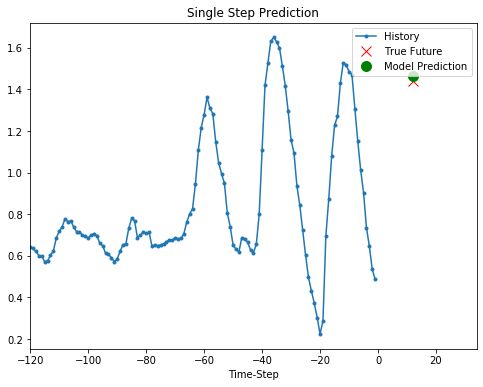

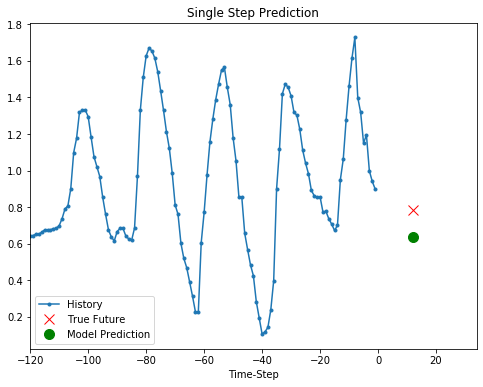

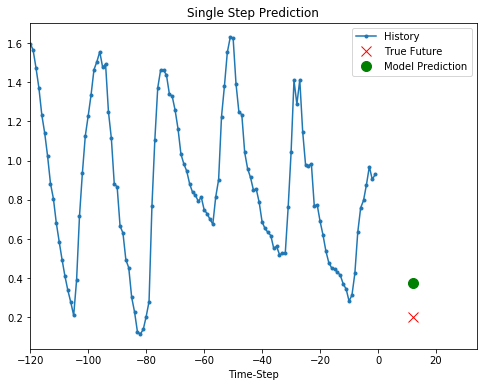

 63936/119759 [===============>..............] - ETA: 23:58 - loss: 0.1561 - mae: 0.15 - ETA: 2:42 - loss: 0.2056 - mae: 0.2056 - ETA: 1:31 - loss: 0.2280 - mae: 0.228 - ETA: 1:09 - loss: 0.2657 - mae: 0.265 - ETA: 57s - loss: 0.2937 - mae: 0.293 - ETA: 49s - loss: 0.2902 - mae: 0.29 - ETA: 45s - loss: 0.2709 - mae: 0.27 - ETA: 41s - loss: 0.2669 - mae: 0.26 - ETA: 39s - loss: 0.2713 - mae: 0.27 - ETA: 37s - loss: 0.2640 - mae: 0.26 - ETA: 35s - loss: 0.2764 - mae: 0.27 - ETA: 34s - loss: 0.2769 - mae: 0.27 - ETA: 32s - loss: 0.2708 - mae: 0.27 - ETA: 31s - loss: 0.2605 - mae: 0.26 - ETA: 30s - loss: 0.2516 - mae: 0.25 - ETA: 30s - loss: 0.2456 - mae: 0.24 - ETA: 29s - loss: 0.2483 - mae: 0.24 - ETA: 28s - loss: 0.2494 - mae: 0.24 - ETA: 27s - loss: 0.2498 - mae: 0.24 - ETA: 27s - loss: 0.2465 - mae: 0.24 - ETA: 27s - loss: 0.2463 - mae: 0.24 - ETA: 26s - loss: 0.2503 - mae: 0.25 - ETA: 26s - loss: 0.2546 - mae: 0.25 - ETA: 26s - loss: 0.2535 - mae: 0.25 - ETA: 25s - loss: 0.2548 - mae

119759/119759 [==============================] - ETA: 10s - loss: 0.2782 - mae: 0.27 - ETA: 10s - loss: 0.2783 - mae: 0.27 - ETA: 9s - loss: 0.2779 - mae: 0.2779 - ETA: 9s - loss: 0.2784 - mae: 0.278 - ETA: 9s - loss: 0.2781 - mae: 0.278 - ETA: 9s - loss: 0.2782 - mae: 0.278 - ETA: 9s - loss: 0.2781 - mae: 0.278 - ETA: 9s - loss: 0.2775 - mae: 0.277 - ETA: 9s - loss: 0.2780 - mae: 0.278 - ETA: 9s - loss: 0.2781 - mae: 0.278 - ETA: 9s - loss: 0.2775 - mae: 0.277 - ETA: 9s - loss: 0.2775 - mae: 0.277 - ETA: 9s - loss: 0.2770 - mae: 0.277 - ETA: 9s - loss: 0.2767 - mae: 0.276 - ETA: 9s - loss: 0.2762 - mae: 0.276 - ETA: 9s - loss: 0.2765 - mae: 0.276 - ETA: 9s - loss: 0.2763 - mae: 0.276 - ETA: 9s - loss: 0.2760 - mae: 0.276 - ETA: 9s - loss: 0.2755 - mae: 0.275 - ETA: 9s - loss: 0.2750 - mae: 0.275 - ETA: 9s - loss: 0.2746 - mae: 0.274 - ETA: 8s - loss: 0.2748 - mae: 0.274 - ETA: 8s - loss: 0.2753 - mae: 0.275 - ETA: 8s - loss: 0.2755 - mae: 0.275 - ETA: 8s - loss: 0.2758 - mae: 0.275 - 

In [26]:
plot_preds(models[0], val_data_single)
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = random_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_val_single, y_val_single)